# Case Study: modelling temperature persistence in Europe

## Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt
import statsmodels.api as sm
import calendar
import ssl
from statsmodels.tsa.api import VAR
import statistics
import scipy.stats as stats
import matplotlib.dates as mdates
from scipy.stats import norm
from scipy.optimize import minimize
import os

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", message="An unsupported index was provided and will be ignored when e.g. forecasting.")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def delete_leap_year(df):
  """ Deletes leap years from the data frame

    Args:
        df (pd.DataFrame): data frame with leap years

    Returns:
        pd.DataFrame: df without the day 02-29

    """
  # Add day and month columns
  df['Day'] = df['Date'].dt.day
  df['Month'] = df['Date'].dt.month
  # Remove the leap days
  df = df[~((df['Month'] == 2) & (df['Day'] == 29))]
  # Remove the day and month columns
  df.drop(columns=['Day', 'Month'], inplace=True)
  # Reset the index
  df.reset_index(drop=True, inplace=True)
  return df

In [3]:
def disable_ssl_verification(): # This is necessary due to bypass the SSL verification.
    context = ssl.create_default_context()
    context.check_hostname = False
    context.verify_mode = ssl.CERT_NONE
    return context

def get_data_url(link):
    """ Imports and preprocesses the data from a certain url link

    Args:
        link (str): url to the data

    Returns:
        pd.DataFrame: df containing the data

    """
    # Disable SSL verification
    ssl_context = disable_ssl_verification()

    # Read the data from the link with SSL verification disabled
    with urllib.request.urlopen(link, context=ssl_context) as response:
        data = response.read().decode('utf-8')

    # Split the data into lines
    data = data.split("\n")
    data_list = []

    for row in data[2:-1]:
        row_list = list(filter(None, row.split(' ')))
        row_list[1] = row_list[1].rstrip('\r')
        data_list.append({'Date': row_list[0], 'Value': row_list[1]})

    # Create a df
    df = pd.DataFrame(data_list)

    # Convert the columns to datetime and int
    df['Date'] = pd.to_datetime(df['Date'])
    df['Value'] = df['Value'].astype(float)

    # Delete leap years
    df = delete_leap_year(df)  # Assuming you have implemented this function elsewhere

    return df

In [4]:
def get_data_path(path):
  """ Reads and preprocesses the data from a certain path

    Args:
        path (str): path to the data

    Returns:
        pd.DataFrame: df containing the data

    """
  # Df file
  df = pd.read_csv(path, skiprows=20, delimiter = ',', na_values='-9999')

  # Remove whitespaces from column names
  df.columns = df.columns.str.replace(' ', '')

  # Select interesting columns
  df = df[['DATE', 'TG']]

  # Convert DATE to datetime
  df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

  # Get temperature
  df['TG'] = df['TG'].apply(lambda x: int(x) / 10 if pd.notna(x) else x)

  # Rename columns to use functions earlier
  df = df.rename(columns={'DATE': 'Date', 'TG': 'Value'})

  # Delete leap years
  df = delete_leap_year(df)

  # Impute missing values (linear as that makes sense for temperatures?)
  df['Value'] = df['Value'].interpolate(method='linear')

  return df

In [5]:
# Import and preprocess the CET data from the paper
df_CET = get_data_url('https://hadleyserver.metoffice.gov.uk/hadcet/data/meantemp_daily_totals.txt')
df_CET.head()

Date  Value
0 1772-01-01    3.2
1 1772-01-02    2.0
2 1772-01-03    2.7
3 1772-01-04    2.7
4 1772-01-05    1.5

In [6]:
# Connect the notebook to my drive where the text files are stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Import and preprocess the other datapoints in Europe
df_Bilt = get_data_path('/content/drive/MyDrive/CaseStudy/Data/bilt.txt')
df_Bremen = get_data_path('/content/drive/MyDrive/CaseStudy/Data/bremen.txt')
df_Dublin = get_data_path('/content/drive/MyDrive/CaseStudy/Data/dublin.txt')
df_Stockholm = get_data_path('/content/drive/MyDrive/CaseStudy/Data/stockholm.txt')
df_Wenen = get_data_path('/content/drive/MyDrive/CaseStudy/Data/wenen.txt')
df_Praag = get_data_path('/content/drive/MyDrive/CaseStudy/Data/praag.txt')
df_Munchen = get_data_path('/content/drive/MyDrive/CaseStudy/Data/munchen.txt')
df_Tortosa = get_data_path('/content/drive/MyDrive/CaseStudy/Data/tortosa.txt')
df_Bologna = get_data_path('/content/drive/MyDrive/CaseStudy/Data/bologna.txt')
df_Zagreb = get_data_path('/content/drive/MyDrive/CaseStudy/Data/zagreb.txt')
df_Lissabon = get_data_path('/content/drive/MyDrive/CaseStudy/Data/lissabon.txt')

## Descriptive statistics

In [9]:
print('CET:')
print(df_CET.describe())
print('\nBilt:')
print(df_Bilt.describe())
print('\nBremen:')
print(df_Bremen.describe())
print('\nDublin:')
print(df_Dublin.describe())
print('\nStockholm:')
print(df_Stockholm.describe())
print('\nWenen:')
print(df_Wenen.describe())
print('\nPraag:')
print(df_Praag.describe())
print('\nMunchen:')
print(df_Munchen.describe())
print('\nTortosa:')
print(df_Tortosa.describe())
print('\nBologna:')
print(df_Bologna.describe())
print('\nZagreb:')
print(df_Zagreb.describe())
print('\nLissabon:')
print(df_Lissabon.describe())

CET:
              Value
count  92012.000000
mean       9.405092
std        5.345248
min      -11.900000
25%        5.400000
50%        9.400000
75%       13.800000
max       28.100000

Bilt:
              Value
count  44864.000000
mean       9.586352
std        6.294137
min      -14.900000
25%        5.100000
50%        9.800000
75%       14.600000
max       29.700000

Bremen:
              Value
count  47784.000000
mean       8.956370
std        7.827633
min      -21.400000
25%        3.000000
50%        9.100000
75%       15.200000
max       29.600000

Dublin:
              Value
count  52164.000000
mean       9.439372
std        4.558739
min      -10.700000
25%        6.000000
50%        9.400000
75%       13.100000
max       23.100000

Stockholm:
              Value
count  97789.000000
mean       6.234181
std        8.378726
min      -27.700000
25%        0.200000
50%        5.800000
75%       13.300000
max       28.300000

Wenen:
              Value
count  61623.000000
mean      

In [ ]:
def plot_average(df, place):
  """ Plots the average temperature for every day over a certain time span

    Args:
        df (pd.DataFrame): df containing temperature over the years
        place (str): place where the data is from

    Returns:
        None

    """
  # Days in a non-leap year
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

  # Calculate the average per day
  df['Day'] = df['Date'].dt.day
  df['Month'] = df['Date'].dt.month
  mean_by_day = df.groupby(['Month', 'Day'])['Value'].mean().reset_index()

  # Make a plot
  plt.figure(figsize=(8, 4))
  plt.plot(days_in_year, mean_by_day['Value'])
  plt.title(f'Average temperature per day of {place}')
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
  plt.axhline(0, color='red', linestyle='--', linewidth=0.5, dashes=(2, 4))
  plt.xlim(days_in_year.min(), days_in_year.max())
  plt.xlabel('Month')
  plt.ylabel('Temperature')
  plt.ylim(-5, 27)
  plt.show()

In [ ]:
def boxplot(df, place):
    """ Plots a boxplot of the temperature values in a DataFrame
    Args:
        df (pd.DataFrame): a df containing temperature over the years
        place (str): place where the data is from


    Returns:
        None

    """
    plt.figure(figsize=(8, 4))
    boxplot = plt.boxplot(df['Value'], vert=False, widths=0.6, patch_artist=True, boxprops=dict(facecolor='none'))
    plt.title(f'Temperature Values of {place}')
    plt.xlabel('Temperature')
    plt.yticks([])
    plt.show()

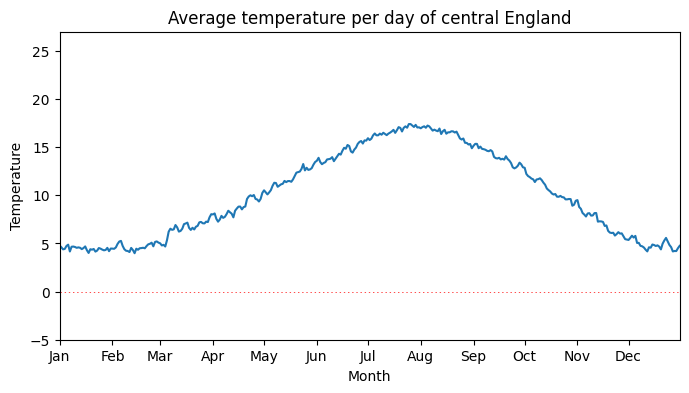

In [ ]:
# Subset of df
subset = df_CET[(df_CET['Date'] >= str(1980)) & (df_CET['Date'] < str(2020 + 1))]
# Plot average temp a day of subset
plot_average(subset, 'central England')

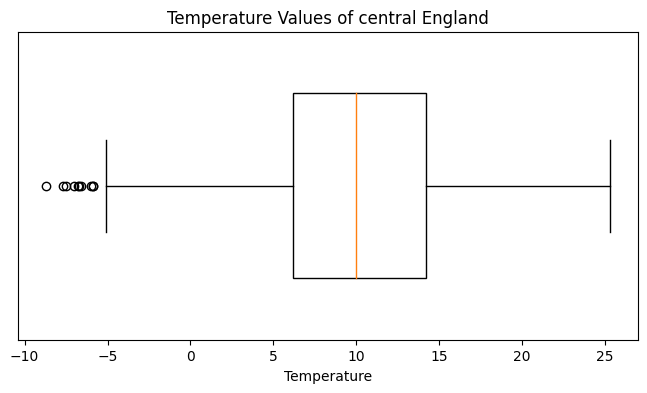

In [ ]:
# Boxplot of subset
boxplot(subset, 'central England')

In [ ]:
# Some descriptive statistics of the subset temp
subset['Value'].describe()

count    14965.000000
mean        10.059031
std          5.196581
min         -8.700000
25%          6.200000
50%         10.000000
75%         14.200000
max         25.300000
Name: Value, dtype: float64

## Helper functions

In [ ]:
def fill_matrix(df, year, day, w):
    """ Fill the matrix with ones for a specic day in a year given a certain window

    Args:
        df (pd.DataFrame): contains the matrix with zeros and ones
        year (int): the year for for which we want to fill the days with ones
        day (str): the day around we want to fill the days with ones
        w (int): the window indicates how many days we want to fill with ones

    Returns:
      None
    """
    # Index of a certain day
    day_ind = df.columns.get_loc(day)

    # Loop throught the window
    for i in range(0, int(w/2)):
        ind_bef = day_ind - i
        ind_aft = day_ind + i

        # Handle if days exceeds year
        if ind_aft >= len(df.columns):
            year_aft = year + 1
            df.loc[year_aft, df.columns[ind_aft - len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_aft < len(df.columns):
          df.loc[year, df.columns[ind_aft]] = 1


        # Handle if days deceeds year
        if ind_bef < 0:
            year_bef = year - 1
            df.loc[year_bef, df.columns[ind_bef + len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_bef >= 0:
          df.loc[year, df.columns[ind_bef]] = 1


In [ ]:
def get_h_matrix(first_year, last_year, day):
    """ Create a matrix containing zeros and ones for a specific block around a
    day within certain years

    Args:
        first_year (str): the first year for which we want to create a window of
        ones
        last_year (str): the last year for which we want to create a window of
        ones
        day (str): the day around we want to fill the days with ones

    Returns:
        pd.DataFrame: df containing zeros and ones for a specific date (note
        that the df contains an extra year before and after the last year)

    """

    # Create a list containing all days of a non-leap year
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

    # Make a df with days as columns and years 1979-2021 as rows
    df = pd.DataFrame(0, index=range(first_year-1, last_year+2), columns=[f'{date.day}-{date.month}' for date in days_in_year])

    # Define window
    w = 30

    # Loop through the years and fill matrix with 1 ones around a specific date given a window w
    for year in range(first_year, last_year + 1):
        fill_matrix(df, year, day,w)

    return df

In [ ]:
def get_subset_df(df, first_year, last_year):
    """ Create a subset of a dataframe given certain years

    Args:
        first_year (str): the first year included in the subset
        last_year (str): the last year included in the subset
        df (pd.DataFrame): df from which we want the subset

    Returns:
        pd.DataFrame: df containing the subset

    """

    # Select the given years
    subset = df[(df['Date'] >= str(first_year)) & (df['Date'] < str(last_year+1))]

    # Create chunks for every year
    chunk_size = 365
    chunks = [subset[i:i+chunk_size] for i in range(0, len(subset), chunk_size)]

    # Create a df
    df_subset = pd.DataFrame()

    # Loop through all the given years
    for year in range(0,(last_year-first_year+1)):
        value_series = chunks[year]['Value'].reset_index(drop=True)
        columns = []

        # Loop through all the days
        for day in range(0, 365):
            value_for_day = value_series[day]
            column_series = pd.Series(value_for_day)
            columns.append(column_series)

        # Fill the df
        df_1_year = pd.concat(columns, axis=1)
        df_subset = pd.concat([df_subset, df_1_year], ignore_index=True)

    # Add the correct index and column names
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
    df_subset.columns = [f'{date.day}-{date.month}' for date in days_in_year]
    df_subset.index = range(first_year, last_year+1)

    return df_subset

In [ ]:
def get_h_min1(h):
    """ Gets the h-matrix of one day earlier

      Args:
          h (pd.DataFrama): the h-matrix of the current day

      Returns:
          pd.DataFrame: h_min1 is the h-matrix of the previous day

      """
    # Shift h
    shifted_h = np.roll(h, 1)

    # Add the correct columns
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
    h_min1 = pd.DataFrame(shifted_h, columns=[f'{date.day}-{date.month}' for date in days_in_year])

    return h_min1

In [ ]:
def compute_phi(y_tilde, y_tilde_min1, h, h_min1):
    """ Computes the phi, upper and lower bound

      Args:
          y_tilde (pd.DataFrama): demeaned temperature values in a block of the
          current day
          y_tilde_min1(pd.DataFrama): demeaned temperature values in a block of
          the previous day
          h (pd.DataFrama): the h-matrix of the current day
          h_min1 (pd.DataFrama): the h-matrix of the previous day

      Returns:
          int: the estimate phi_hat
          int: the upper bound phi_ci_uppper
          int: the lower bound phi_ci_lower

    """
    phi_hat = (y_tilde.values*y_tilde_min1.values).sum() / (y_tilde_min1.values**2*h.values*h_min1.values).sum()
    phi_ci_upper = phi_hat + np.sqrt((1-phi_hat**2)/(h.values*h_min1.values).sum())*norm.ppf(1 - 0.05 / 2)
    phi_ci_lower = phi_hat - np.sqrt((1-phi_hat**2)/(h.values*h_min1.values).sum())*norm.ppf(1 - 0.05 / 2)

    return phi_hat, phi_ci_upper, phi_ci_lower

In [ ]:
def compute_alpha(h, h_min1, y, phi_hat, y_min1):
    """ Computes the phi, upper and lower bound

      Args:
          h (pd.DataFrama): the h-matrix of the current day
          h_min1 (pd.DataFrama): the h-matrix of the previous day
          y (np.array): temperature values in a block of the current day
          phi_hat (int): the estimate of phi
          y_min1 (np.array): temperature values in a block of the previous day

      Returns:
          int: the estimate phi_hat
          int: the upper bound phi_ci_uppper
          int: the lower bound phi_ci_lower

    """
    alpha_hat = (h.values*h_min1.values*(y-phi_hat*y_min1)).sum() / (h.values*h_min1.values).sum()
    alpha_ci_upper = alpha_hat + np.sqrt((((y**2).sum()/h.values.sum())*(1-phi_hat**2))/(h.values*h_min1.values).sum())*norm.ppf(1 - 0.05 / 2)
    alpha_ci_lower = alpha_hat - np.sqrt((((y**2).sum()/h.values.sum())*(1-phi_hat**2))/(h.values*h_min1.values).sum())*norm.ppf(1 - 0.05 / 2)

    return alpha_hat, alpha_ci_upper, alpha_ci_lower

## PAR(1) model

In [ ]:
def estimate_PAR_params(df, first_year, last_year):
    """ Calculate the parameters of an PAR model for every day over a certain
    time period

    Args:
        df (pd.DataFrame): df containing the temperature
        first_year (str): the first year of the time period
        last_year (str): the last year of the time period

    Returns:
        pd.DataFrame: a df containing all the parameter estimates

    """
    # Get the interesting subset of the data
    df_subset = get_subset_df(df, first_year-1, last_year+1)

    # Define lists for parameters
    phi_list = []
    phi_ci_upper_list = []
    phi_ci_lower_list = []

    alpha_list = []
    alpha_ci_upper_list = []
    alpha_ci_lower_list = []

    mu_list = []

    # Loop over the days in a non-leap year
    days_in_year = pd.date_range(start='1/1/2023', end='12/31/2023', freq='D')
    for date in days_in_year:
        # Print statement
        print(f'\r Currently estimating: {calendar.month_name[date.month]} {date.day}' + " " * 15, end='')

        # Obtain variables of the current day
        h = get_h_matrix(first_year, last_year, f'{date.day}-{date.month}')
        y = df_subset.values * h.values
        y_bar = sum(y) / sum(h.values)
        y_tilde = (y - y_bar*h).fillna(0)

        # Obtain variables of the previous day
        h_min1 = get_h_min1(h)
        y_min1 = np.roll(y, 1)
        y_bar_min1 = sum(y_min1) / sum(h_min1.values)
        y_tilde_min1 = (y_min1 - y_bar_min1*h_min1).fillna(0)

        # Compute phi
        phi_hat, phi_ci_upper, phi_ci_lower = compute_phi(y_tilde, y_tilde_min1, h, h_min1)

        # Compute alpha
        alpha_hat, alpha_ci_upper, alpha_ci_lower = compute_alpha(h, h_min1, y, phi_hat, y_min1)

        # Compute mu
        mu_hat = alpha_hat / (1 - phi_hat)

        # Append the results to the lists
        phi_list.append(phi_hat)
        phi_ci_upper_list.append(phi_ci_upper)
        phi_ci_lower_list.append(phi_ci_lower)

        alpha_list.append(alpha_hat)
        alpha_ci_upper_list.append(alpha_ci_upper)
        alpha_ci_lower_list.append(alpha_ci_lower)

        mu_list.append(mu_hat)

    # Append the lists to the df
    PAR_df = pd.DataFrame()
    PAR_df['Date'] = days_in_year
    PAR_df['Phi'] = phi_list
    PAR_df['Phi upper bound'] = phi_ci_upper_list
    PAR_df['Phi lower bound'] = phi_ci_lower_list
    PAR_df['Alpha'] = alpha_list
    PAR_df['Alpha upper bound'] = alpha_ci_upper_list
    PAR_df['Alpha lower bound'] = alpha_ci_lower_list
    PAR_df['Mu'] = mu_list

    # Print a statement when finished
    print('\r Finished estimating PAR parameters!'+ " " * 15, end='')

    return PAR_df

## PQAR(1) Model

In [ ]:
def compute_PQAR_residuals(theta, y, y_min1, h, q):
    """ Calculate the residual of a periodic quantile autoregression model

    Args:
        params (list): phi and alpha
        df (pd.DataFrame): df containing the temperature
        h (pd.DataFrame): h-matrix for a date
        q (float): the quantile we are interested in

    Returns:
        int: residuals of the model with certain params

    """
    # Obtain variables
    alpha = theta[0]
    phi = theta[1]

    # Implement formula
    I = np.where(h * (y - alpha - phi * y_min1) < 0, 1, 0)

    residuals = h * (y - alpha - phi * y_min1) * (q - I)

    return residuals.sum().sum()

In [ ]:
def estimate_PQAR_params(df, first_year, last_year, q):
    """ Calculate the phi and alpha for every day over a certain time period

    Args:
        df (pd.DataFrame): df containing the temperature
        first_year (str): the first year of the time period
        last_year (str): the last year of the time period
        q (float): the quantile we are interested in

    Returns:
        pd.DataFrame: df

    """
    # Get the interesting subset of the data
    df_subset = get_subset_df(df, first_year-1, last_year+1)

    # Define lists for parameters
    alpha_list = []
    phi_list = []
    mu_list = []

    # Obtain variables
    y = df_subset.values
    y_min1 = np.roll(y, 1)
    initial_theta = [3, 0.2]

    # Loop over the days in a non-leap year
    for date in pd.date_range(start='1/1/2023', end='12/31/2023', freq='D'):
        # Print statement
        print(f'\r Currently estimating: {calendar.month_name[date.month]} {date.day}' + " " * 15, end='')

        # Obtain the h-matrix
        h = get_h_matrix(first_year, last_year, f'{date.day}-{date.month}')

        # Find the optimal phi and alpha
        theta_hat = minimize(compute_PQAR_residuals, initial_theta, method = 'SLSQP', args=(y, y_min1, h, q))

        # Compute mu
        alpha_hat = theta_hat.x[0]
        phi_hat = theta_hat.x[1]
        mu_hat = alpha_hat / (1 -  phi_hat)

        # Append to lists
        alpha_list.append(alpha_hat)
        phi_list.append(phi_hat)
        mu_list.append(mu_hat)

    # Append lists to df
    PQAR_df = pd.DataFrame()
    PQAR_df['Date'] = pd.date_range(start='1/1/2023', end='12/31/2023', freq='D')
    PQAR_df['Phi'] = phi_list
    PQAR_df['Alpha'] = alpha_list
    PQAR_df['Mu'] = mu_list

    # Print a statement when finished
    print('\r Finished estimating PQAR parameters!'+ " " * 15, end='')

    return PQAR_df

## Plot function

In [ ]:
def plot(df, first_year, last_year, param, place, model, q=None, df2=None):
  """ Plots a param for the given time periods

    Args:
        df (pd.DataFrame): df containing parameter values for most recent years
        firstyear (list): a list containing the first years
        lastyear (list): a list containing the last years
        param (str): the parameter to plot
        place (str): the place where the data is from
        model (str): name of the model used
        q (str): the quantile we are interested in
        df2 (pd.DataFrame): df containing parameter values for most recent years

    Returns:
      None

    """

  # Map the parameter to the correct label
  label_map = {'Phi': 'ϕ', 'Alpha': 'α', 'Mu': 'µ'}
  label = label_map.get(param)

  # Use different colors if only one time period is given
  color_param = 'black' if df2 is None else 'red'
  color_ci = 'blue' if df2 is None else 'red'

  # Plot the time period of df
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
  plt.figure(figsize=(9, 6))
  plt.plot(days_in_year, df[param], label=f'{label} ({str(first_year[0])}-{str(last_year[0])})', linestyle='-', color=color_param, linewidth=1)

  # Plot the time period of df2 if given
  if df2 is not None:
    plt.plot(days_in_year, df2[param], label=f'{label} ({str(first_year[1])}-{str(last_year[1])})', linestyle='-', color='blue', linewidth=1)

  # Do not plot CIs for mu
  if param != 'Mu':
    # Do not plot CIs for the PQAR model
    if model != 'PQAR(1)':
      plt.plot(days_in_year, df[f'{param} upper bound'], linestyle='--', label='95% CI', color=color_ci, linewidth=0.5, dashes=(2, 4))
      plt.plot(days_in_year, df[f'{param} lower bound'], linestyle='--', color=color_ci, linewidth=0.5, dashes=(2, 4))

      # Plot the CIs of df2 if given
      if df2 is not None:
        plt.plot(days_in_year, df2[f'{param} upper bound'], linestyle='--', label='95% CI', color='blue', linewidth=0.5, dashes=(2, 4))
        plt.plot(days_in_year, df2[f'{param} lower bound'], linestyle='--', color='blue', linewidth=0.5, dashes=(2, 4))

    # Set the label of the y-axis
    plt.ylabel(f'{label}-value')

    # Set the title and y lim for parameter phi
    if param == 'Phi':
      if q == '0.90':
        plt.ylim(0.2,1.4)
      else:
        plt.ylim(0,1.2)
      plt.title(f'Estimation results for {model} parameter {label}t' if q is None else f'Estimation results for {model} parameter {label}t with quantile {q}')
    # Set the title and y lim for parameter alpha
    else:
      if q == '0.10':
        plt.ylim(-4,12)
      elif q == '0.90':
        plt.ylim(-2,14)
      else:
        plt.ylim(-3,13)
      plt.title(f'Estimation results for the {model} intercept {label}t' if q is None else f'Estimation results for the {model} intercept {label}t with quantile {q}')

  # Set some specification for parameter mu
  else:
    plt.ylabel('Mean Temp')
    if q == '0.10':
      plt.ylim(-50,30)
    elif q == '0.90':
      plt.ylim(-10,70)
    else:
      plt.ylim(-30,50)
    plt.title(f'Estimation results for the {model} local mean {label}t' if q is None else f'Estimation results for the {model} local mean {label}t with quantile {q}')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.5, dashes=(2, 4))

  # Set the x-axis
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
  plt.xlim(days_in_year.min(), days_in_year.max())
  plt.xlabel('Month')

  # Add a legend
  plt.legend()

  # Save the plot on my drive
  if q is None:
    image_path = f'/content/drive/MyDrive/CaseStudy/Plots/{place}_{model}_{param}.png'
  else:
    image_path = f'/content/drive/MyDrive/CaseStudy/Plots/{place}_{model}_{q}_{param}.png'
  plt.savefig(image_path)

  # Show the plot
  plt.show()

## Plots of the data

### Central England Temperature

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_CET_1980_2020 = estimate_PAR_params(df_CET, 1980, 2020)
# PAR_df_CET_1900_1940 = estimate_PAR_params(df_CET, 1900, 1940)

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_CET_1980_2020_low = estimate_PQAR_params(df_CET, 1980, 2020, 0.10)
# PQAR_df_CET_1900_1940_low = estimate_PQAR_params(df_CET, 1900, 1940, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_CET_1980_2020_mean = estimate_PQAR_params(df_CET, 1980, 2020, 0.50)
# PQAR_df_CET_1900_1940_mean = estimate_PQAR_params(df_CET, 1900, 1940, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_CET_1980_2020_high = estimate_PQAR_params(df_CET, 1980, 2020, 0.90)
# PQAR_df_CET_1900_1940_high = estimate_PQAR_params(df_CET, 1900, 1940, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_CET_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_CET_1980_2020.feather")
# PAR_df_CET_1900_1940.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_CET_1900_1940.feather")

# PQAR_df_CET_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1980_2020_low.feather")
# PQAR_df_CET_1900_1940_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1900_1940_low.feather")

# PQAR_df_CET_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1980_2020_mean.feather")
# PQAR_df_CET_1900_1940_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1900_1940_mean.feather")

# PQAR_df_CET_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1980_2020_high.feather")
# PQAR_df_CET_1900_1940_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1900_1940_high.feather")

In [ ]:
# Read df
PAR_df_CET_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_CET_1980_2020.feather")
PAR_df_CET_1900_1940 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_CET_1900_1940.feather")

PQAR_df_CET_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1980_2020_low.feather")
PQAR_df_CET_1900_1940_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1900_1940_low.feather")

PQAR_df_CET_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1980_2020_mean.feather")
PQAR_df_CET_1900_1940_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1900_1940_mean.feather")

PQAR_df_CET_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1980_2020_high.feather")
PQAR_df_CET_1900_1940_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_CET_1900_1940_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_CET_jan = PAR_df_CET_1980_2020['Phi'].loc[14]-PAR_df_CET_1900_1940['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Central England for PAR(1): {Delta_Phi_PAR_CET_jan}')

Delta_Phi_PQAR_CET_jan_low = PQAR_df_CET_1980_2020_low['Phi'].loc[14]-PQAR_df_CET_1900_1940_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Central England for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_CET_jan_low}')

Delta_Phi_PQAR_CET_jan_mean = PQAR_df_CET_1980_2020_mean['Phi'].loc[14]-PQAR_df_CET_1900_1940_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Central England for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_CET_jan_mean}')

Delta_Phi_PQAR_CET_jan_high = PQAR_df_CET_1980_2020_high['Phi'].loc[14]-PQAR_df_CET_1900_1940_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Central England for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_CET_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_CET_jul = PAR_df_CET_1980_2020['Phi'].loc[195]-PAR_df_CET_1900_1940['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Central England for PAR(1): {Delta_Phi_PAR_CET_jul}')

Delta_Phi_PQAR_CET_jul_low = PQAR_df_CET_1980_2020_low['Phi'].loc[195]-PQAR_df_CET_1900_1940_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Central England for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_CET_jul_low}')

Delta_Phi_PQAR_CET_jul_mean = PQAR_df_CET_1980_2020_mean['Phi'].loc[195]-PQAR_df_CET_1900_1940_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Central England for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_CET_jul_mean}')

Delta_Phi_PQAR_CET_jul_high = PQAR_df_CET_1980_2020_high['Phi'].loc[195]-PQAR_df_CET_1900_1940_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Central England for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_CET_jul_high}')

Difference in Phi for January 15 in Central England for PAR(1): 0.013273837693290713
Difference in Phi for January 15 in Central England for PQAR(1) with quantile 0.10: 0.004562301445433459
Difference in Phi for January 15 in Central England for PQAR(1) with quantile 0.50: -0.007971808880664621
Difference in Phi for January 15 in Central England for PQAR(1) with quantile 0.90: 0.06723178944013153
Difference in Phi for July 15 in Central England for PAR(1): 0.009309621711350302
Difference in Phi for July 15 in Central England for PQAR(1) with quantile 0.10: 0.004262762865909986
Difference in Phi for July 15 in Central England for PQAR(1) with quantile 0.50: 0.0057036380497064165
Difference in Phi for July 15 in Central England for PQAR(1) with quantile 0.90: -0.007414343415633073


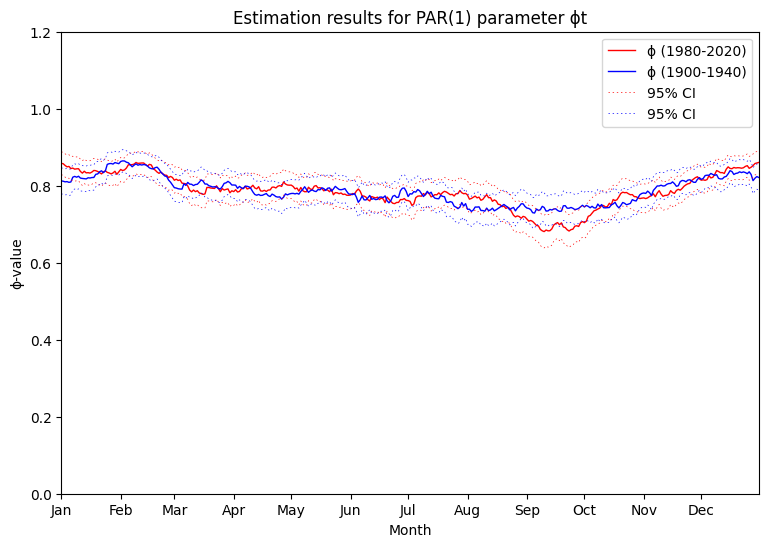

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_CET_1980_2020, [1980, 1900], [2020, 1940], 'Phi', 'CET', 'PAR(1)', df2=PAR_df_CET_1900_1940)

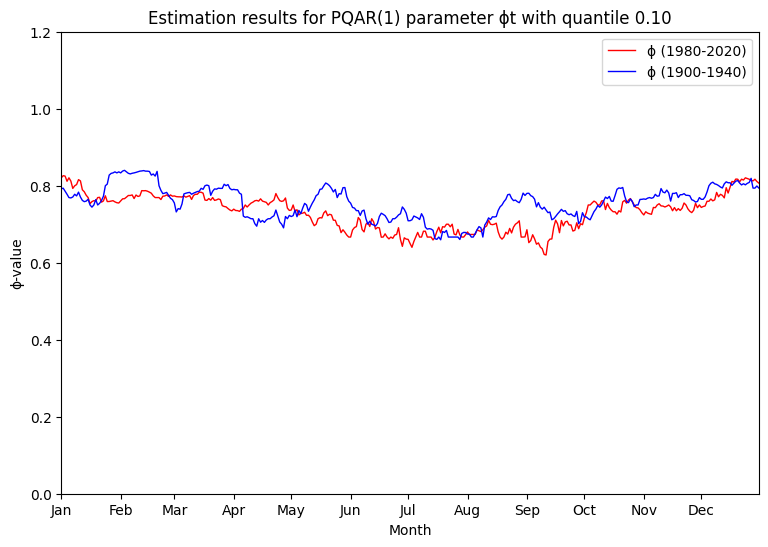

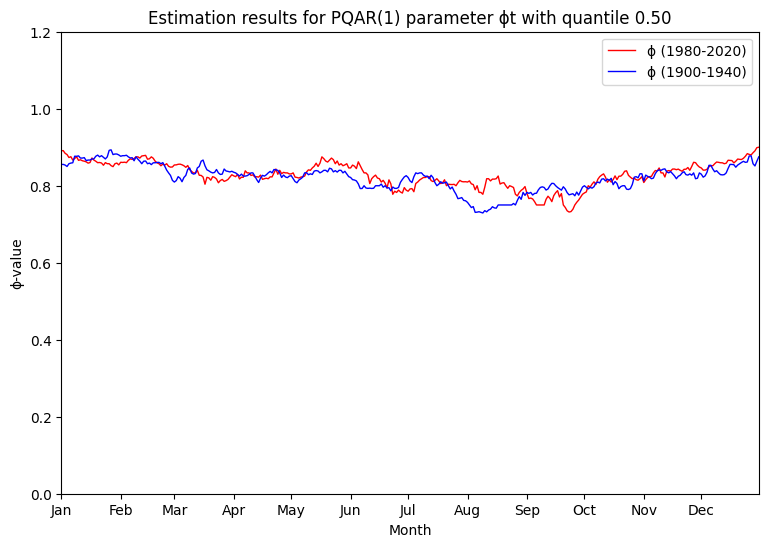

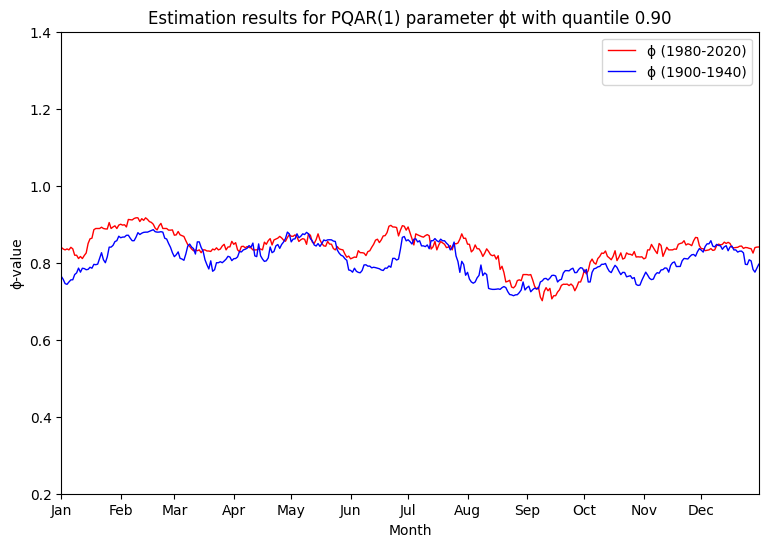

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_CET_1980_2020_low, [1980, 1900], [2020, 1940], 'Phi', 'CET', 'PQAR(1)', q='0.10', df2=PQAR_df_CET_1900_1940_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_CET_1980_2020_mean, [1980, 1900], [2020, 1940], 'Phi', 'CET', 'PQAR(1)', q='0.50', df2=PQAR_df_CET_1900_1940_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_CET_1980_2020_high, [1980, 1900], [2020, 1940], 'Phi', 'CET', 'PQAR(1)', q='0.90', df2=PQAR_df_CET_1900_1940_high)

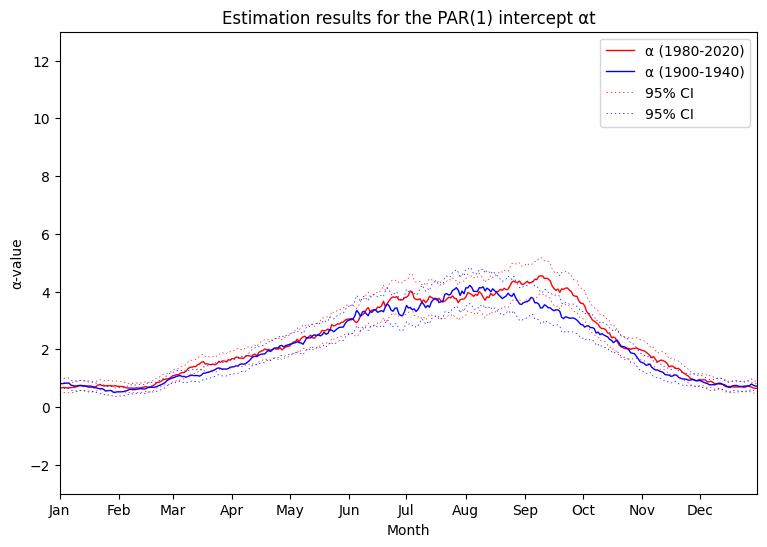

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_CET_1980_2020, [1980, 1900], [2020, 1940], 'Alpha', 'CET', 'PAR(1)', df2=PAR_df_CET_1900_1940)

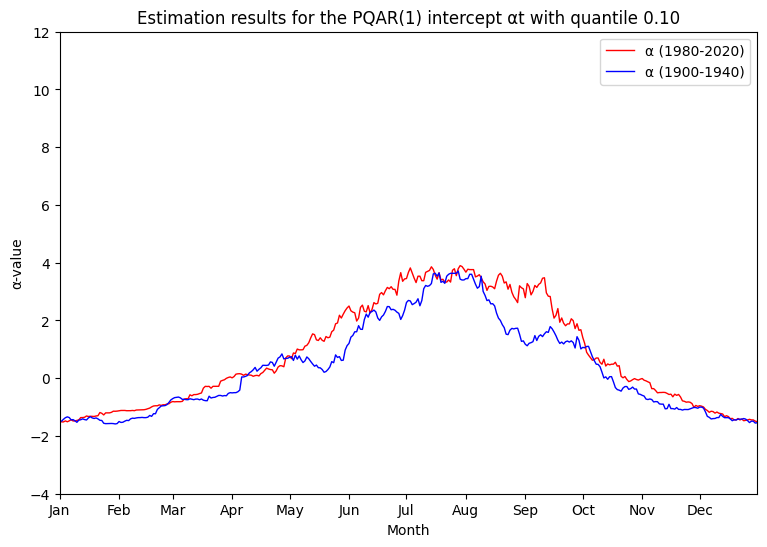

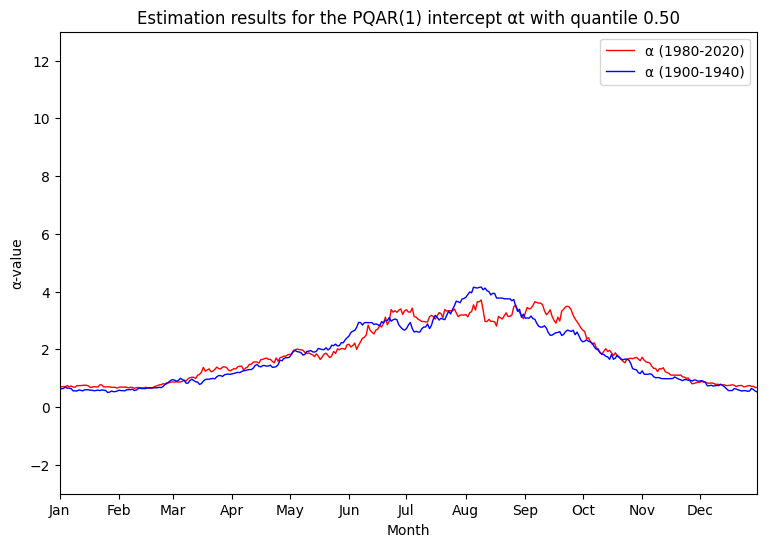

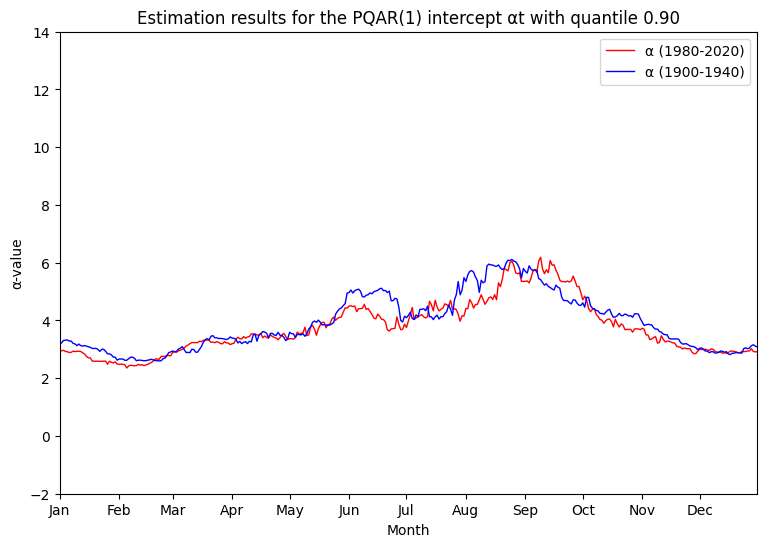

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_CET_1980_2020_low, [1980, 1900], [2020, 1940], 'Alpha', 'CET', 'PQAR(1)', q='0.10', df2=PQAR_df_CET_1900_1940_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_CET_1980_2020_mean, [1980, 1900], [2020, 1940], 'Alpha', 'CET', 'PQAR(1)', q='0.50', df2=PQAR_df_CET_1900_1940_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_CET_1980_2020_high, [1980, 1900], [2020, 1940], 'Alpha', 'CET', 'PQAR(1)', q='0.90', df2=PQAR_df_CET_1900_1940_high)

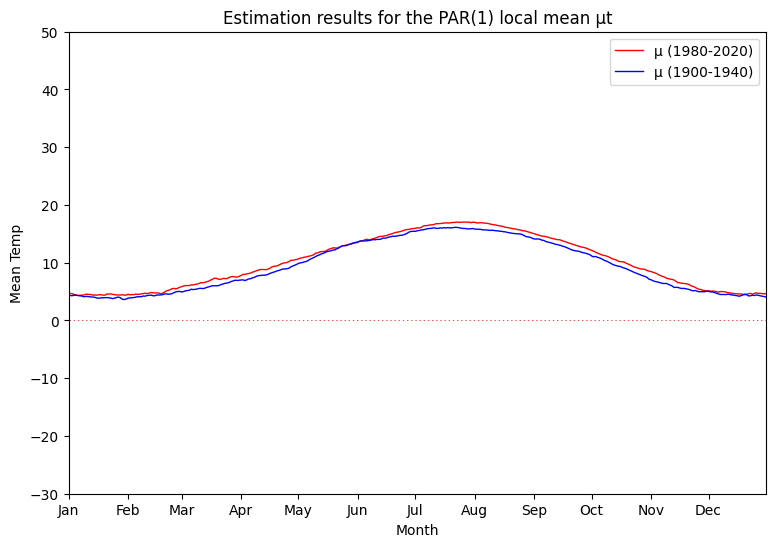

In [ ]:
# Plot the local mean Mu
plot(PAR_df_CET_1980_2020, [1980, 1900], [2020, 1940], 'Mu', 'CET', 'PAR(1)', df2=PAR_df_CET_1900_1940)

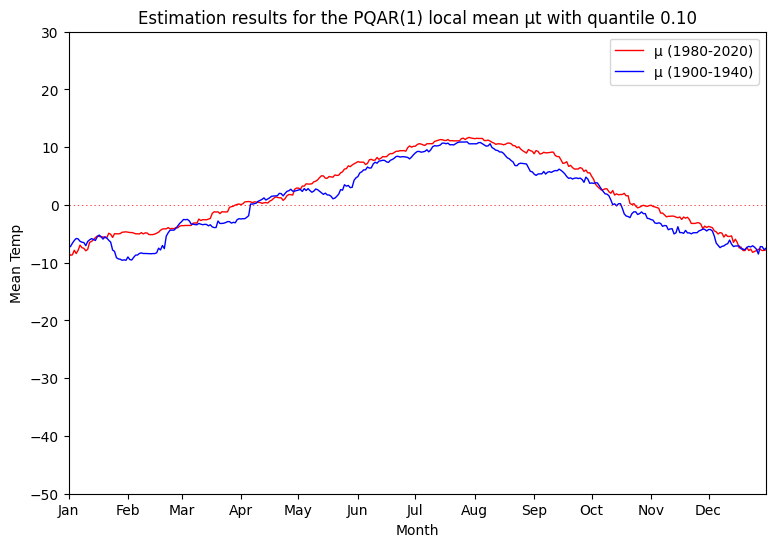

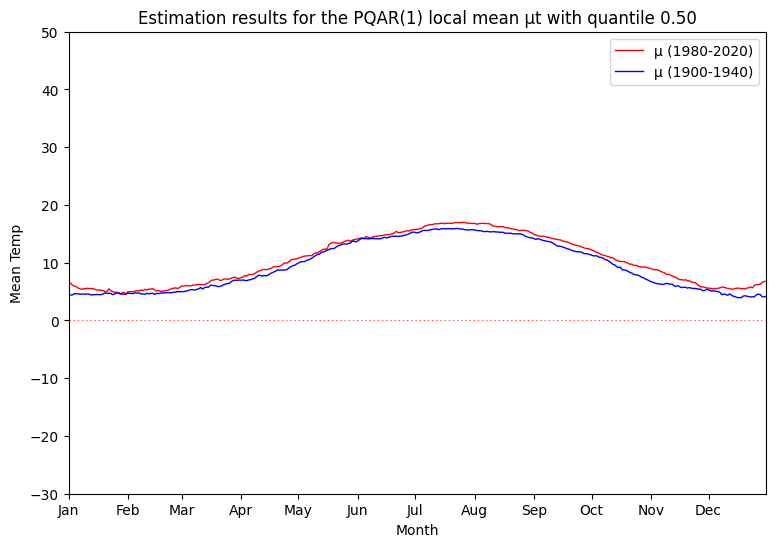

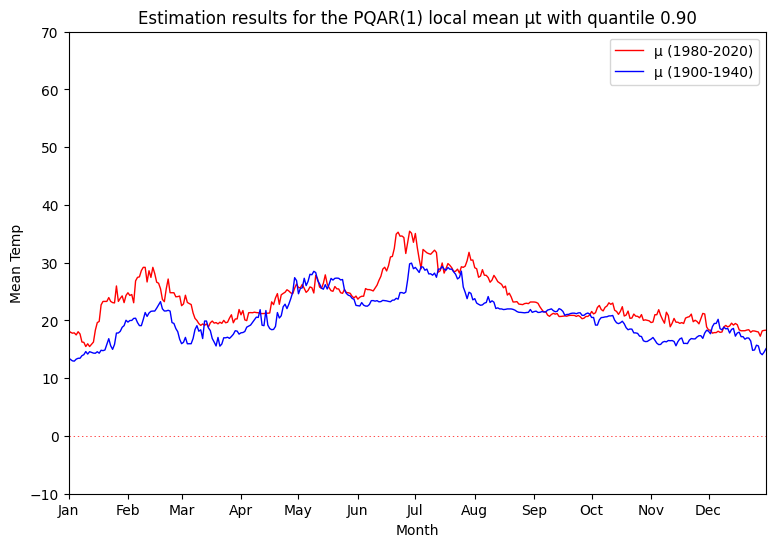

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_CET_1980_2020_low, [1980, 1900], [2020, 1940], 'Mu', 'CET', 'PQAR(1)', q='0.10', df2=PQAR_df_CET_1900_1940_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_CET_1980_2020_mean, [1980, 1900], [2020, 1940], 'Mu', 'CET', 'PQAR(1)', q='0.50', df2=PQAR_df_CET_1900_1940_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_CET_1980_2020_high, [1980, 1900], [2020, 1940], 'Mu', 'CET', 'PQAR(1)', q='0.90', df2=PQAR_df_CET_1900_1940_high)

### Bilt

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Bilt_1980_2020 = estimate_PAR_params(df_Bilt, 1980, 2020)
# PAR_df_Bilt_1902_1942 = estimate_PAR_params(df_Bilt, 1902, 1942) # dataset is from 1901

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Bilt_1980_2020_low = estimate_PQAR_params(df_Bilt, 1980, 2020, 0.10)
# PQAR_df_Bilt_1902_1942_low = estimate_PQAR_params(df_Bilt, 1902, 1942, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Bilt_1980_2020_mean = estimate_PQAR_params(df_Bilt, 1980, 2020, 0.50)
# PQAR_df_Bilt_1902_1942_mean = estimate_PQAR_params(df_Bilt, 1902, 1942, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Bilt_1980_2020_high = estimate_PQAR_params(df_Bilt, 1980, 2020, 0.90)
# PQAR_df_Bilt_1902_1942_high = estimate_PQAR_params(df_Bilt, 1902, 1942, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Bilt_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bilt_1980_2020.feather")
# PAR_df_Bilt_1902_1942.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bilt_1902_1942.feather")

# PQAR_df_Bilt_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1980_2020_low.feather")
# PQAR_df_Bilt_1902_1942_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1902_1942_low.feather")

# PQAR_df_Bilt_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1980_2020_mean.feather")
# PQAR_df_Bilt_1902_1942_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1902_1942_mean.feather")

# PQAR_df_Bilt_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1980_2020_high.feather")
# PQAR_df_Bilt_1902_1942_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1902_1942_high.feather")

In [ ]:
# Read df
PAR_df_Bilt_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bilt_1980_2020.feather")
PAR_df_Bilt_1902_1942 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bilt_1902_1942.feather")

PQAR_df_Bilt_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1980_2020_low.feather")
PQAR_df_Bilt_1902_1942_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1902_1942_low.feather")

PQAR_df_Bilt_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1980_2020_mean.feather")
PQAR_df_Bilt_1902_1942_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1902_1942_mean.feather")

PQAR_df_Bilt_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1980_2020_high.feather")
PQAR_df_Bilt_1902_1942_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bilt_1902_1942_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Bilt_jan = PAR_df_Bilt_1980_2020['Phi'].loc[14]-PAR_df_Bilt_1902_1942['Phi'].loc[14]
print(f'Difference in Phi for January 15 in de Bilt for PAR(1): {Delta_Phi_PAR_Bilt_jan}')

Delta_Phi_PQAR_Bilt_jan_low = PQAR_df_Bilt_1980_2020_low['Phi'].loc[14]-PQAR_df_Bilt_1902_1942_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in de Bilt for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Bilt_jan_low}')

Delta_Phi_PQAR_Bilt_jan_mean = PQAR_df_Bilt_1980_2020_mean['Phi'].loc[14]-PQAR_df_Bilt_1902_1942_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in de Bilt for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Bilt_jan_mean}')

Delta_Phi_PQAR_Bilt_jan_high = PQAR_df_Bilt_1980_2020_high['Phi'].loc[14]-PQAR_df_Bilt_1902_1942_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in de Bilt for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Bilt_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Bilt_jul = PAR_df_Bilt_1980_2020['Phi'].loc[195]-PAR_df_Bilt_1902_1942['Phi'].loc[195]
print(f'Difference in Phi for July 15 in de Bilt for PAR(1): {Delta_Phi_PAR_Bilt_jul}')

Delta_Phi_PQAR_Bilt_jul_low = PQAR_df_Bilt_1980_2020_low['Phi'].loc[195]-PQAR_df_Bilt_1902_1942_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in de Bilt for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Bilt_jul_low}')

Delta_Phi_PQAR_Bilt_jul_mean = PQAR_df_Bilt_1980_2020_mean['Phi'].loc[195]-PQAR_df_Bilt_1902_1942_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in de Bilt for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Bilt_jul_mean}')

Delta_Phi_PQAR_Bilt_jul_high = PQAR_df_Bilt_1980_2020_high['Phi'].loc[195]-PQAR_df_Bilt_1902_1942_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in de Bilt for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Bilt_jul_high}')

Difference in Phi for January 15 in de Bilt for PAR(1): 0.025259702864482647
Difference in Phi for January 15 in de Bilt for PQAR(1) with quantile 0.10: -0.06944619971256438
Difference in Phi for January 15 in de Bilt for PQAR(1) with quantile 0.50: 0.009944969269321424
Difference in Phi for January 15 in de Bilt for PQAR(1) with quantile 0.90: 0.09416866774535049
Difference in Phi for July 15 in de Bilt for PAR(1): 0.014756546106932555
Difference in Phi for July 15 in de Bilt for PQAR(1) with quantile 0.10: 0.011976815562496967
Difference in Phi for July 15 in de Bilt for PQAR(1) with quantile 0.50: 0.05952209770230987
Difference in Phi for July 15 in de Bilt for PQAR(1) with quantile 0.90: 0.0033822954377813463


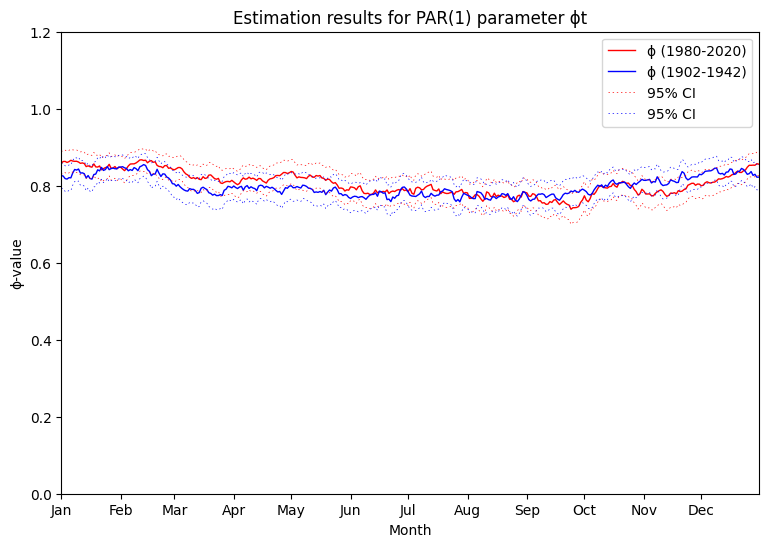

In [ ]:
# Plot the Phi pPARameter of the PAR model
plot(PAR_df_Bilt_1980_2020, [1980, 1902], [2020, 1942], 'Phi', 'Bilt', 'PAR(1)', df2=PAR_df_Bilt_1902_1942)

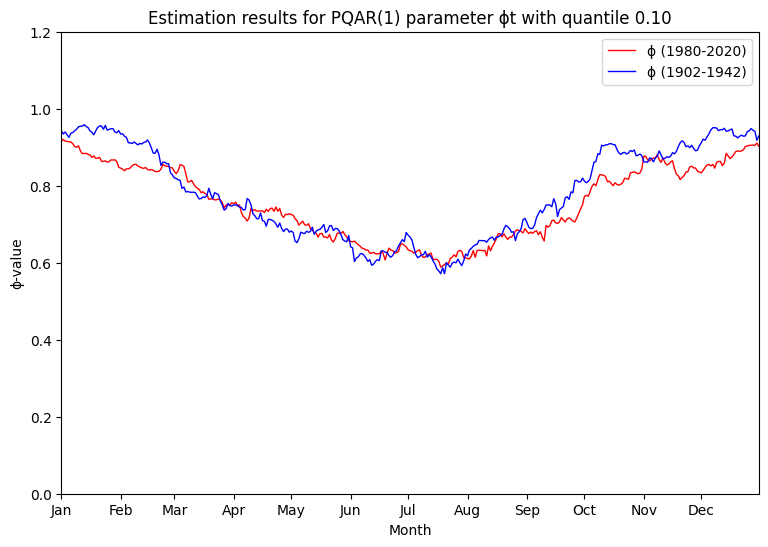

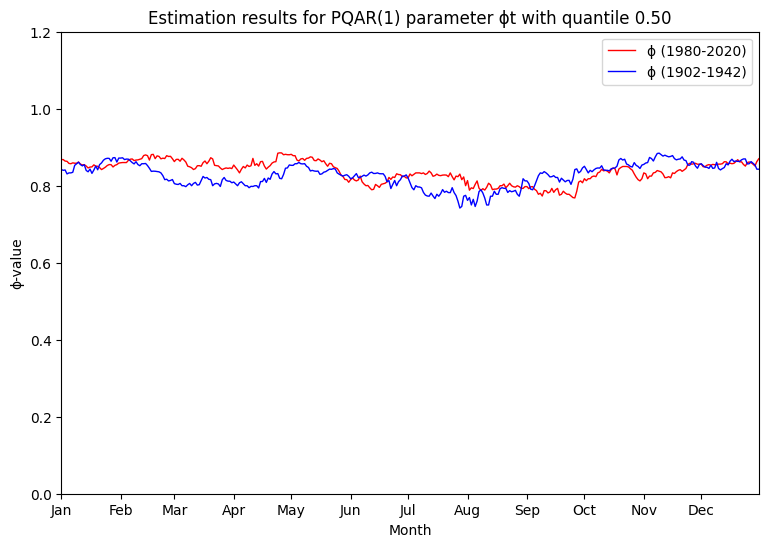

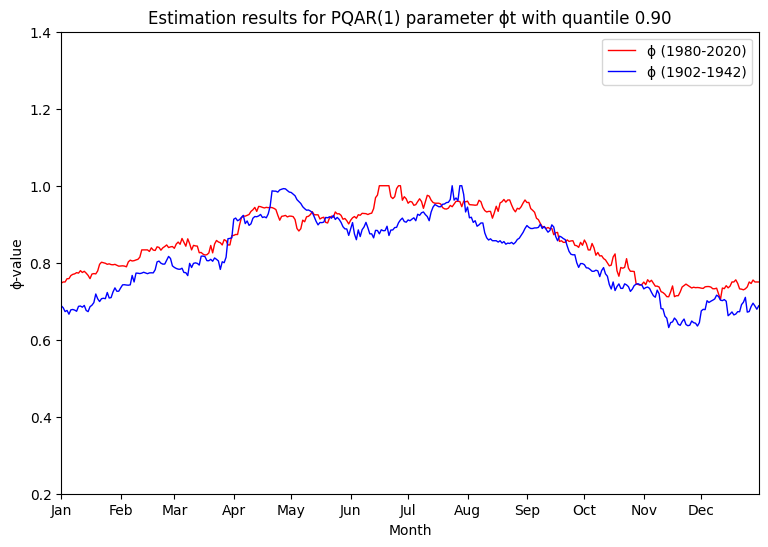

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Bilt_1980_2020_low, [1980, 1902], [2020, 1942], 'Phi', 'Bilt', 'PQAR(1)', q='0.10', df2=PQAR_df_Bilt_1902_1942_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Bilt_1980_2020_mean, [1980, 1902], [2020, 1942], 'Phi', 'Bilt', 'PQAR(1)', q='0.50', df2=PQAR_df_Bilt_1902_1942_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Bilt_1980_2020_high, [1980, 1902], [2020, 1942], 'Phi', 'Bilt', 'PQAR(1)', q='0.90', df2=PQAR_df_Bilt_1902_1942_high)

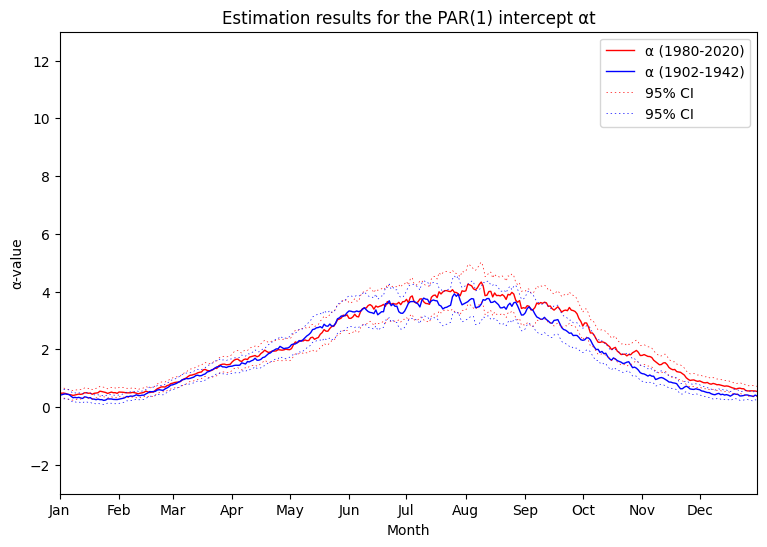

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Bilt_1980_2020, [1980, 1902], [2020, 1942], 'Alpha', 'Bilt', 'PAR(1)', df2=PAR_df_Bilt_1902_1942)

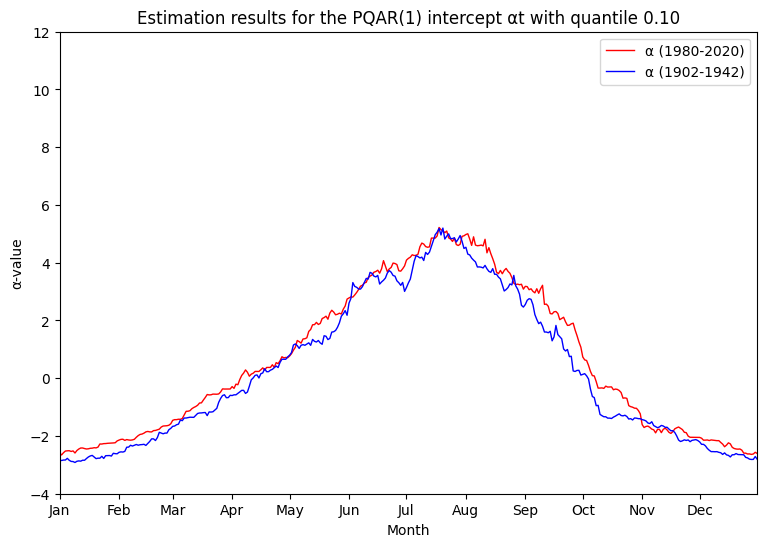

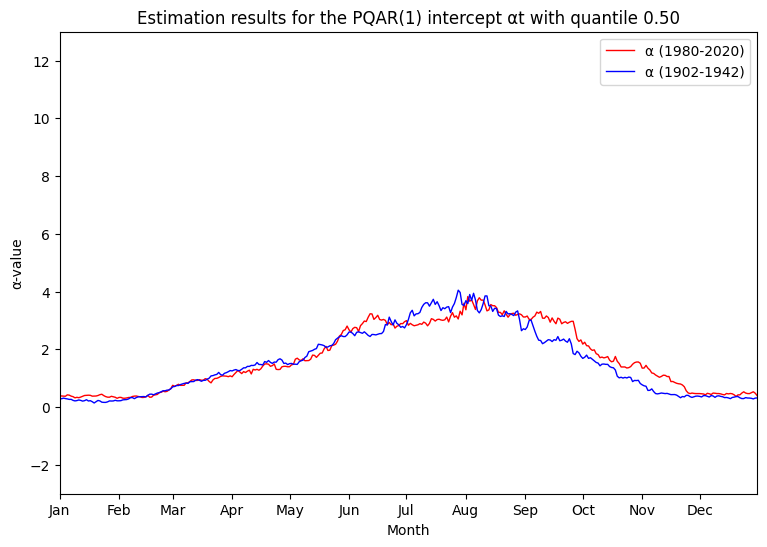

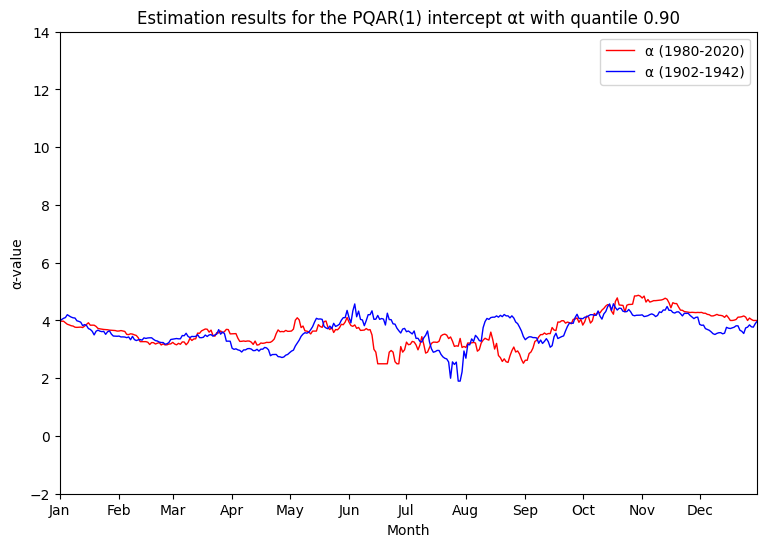

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Bilt_1980_2020_low, [1980, 1902], [2020, 1942], 'Alpha', 'Bilt', 'PQAR(1)', q='0.10', df2=PQAR_df_Bilt_1902_1942_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Bilt_1980_2020_mean, [1980, 1902], [2020, 1942], 'Alpha', 'Bilt', 'PQAR(1)', q='0.50', df2=PQAR_df_Bilt_1902_1942_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Bilt_1980_2020_high, [1980, 1902], [2020, 1942], 'Alpha', 'Bilt', 'PQAR(1)', q='0.90', df2=PQAR_df_Bilt_1902_1942_high)

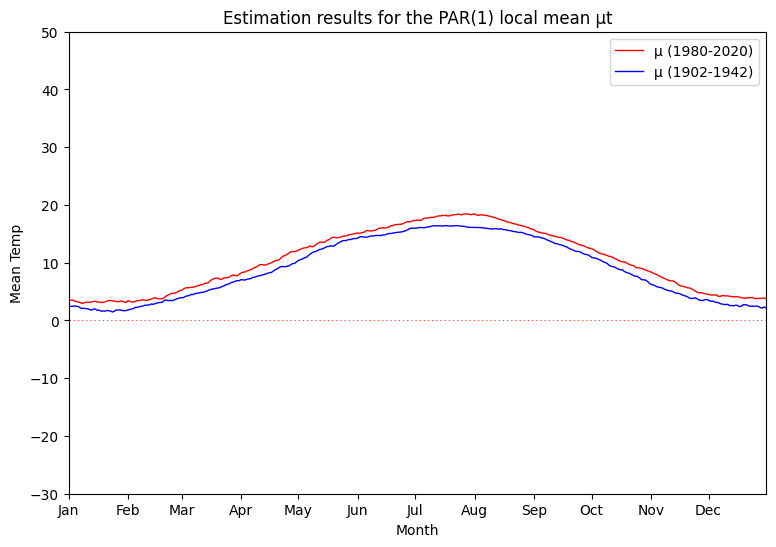

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Bilt_1980_2020, [1980, 1902], [2020, 1942], 'Mu', 'Bilt', 'PAR(1)', df2=PAR_df_Bilt_1902_1942)

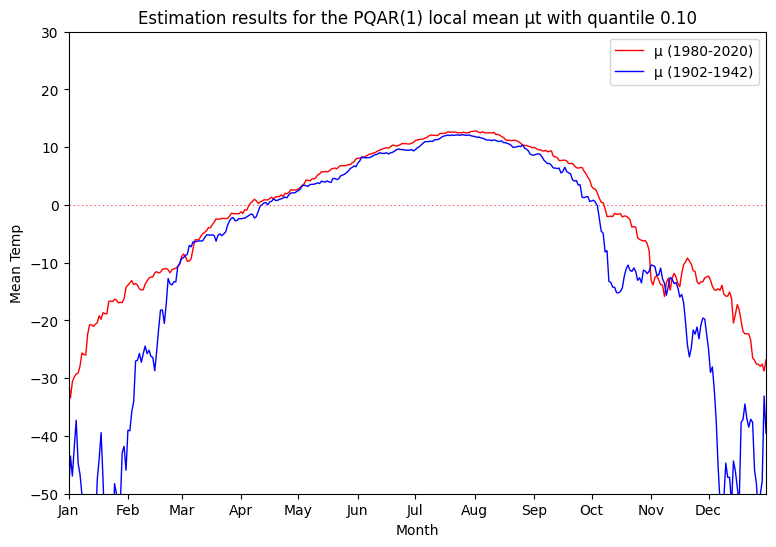

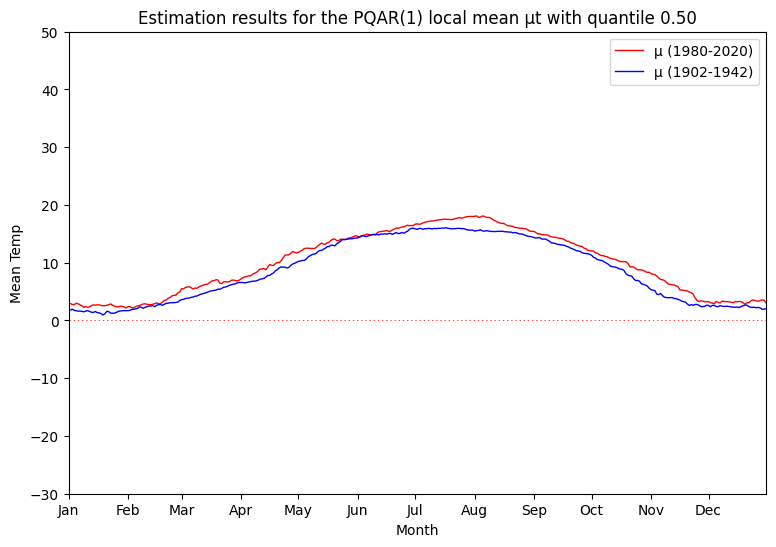

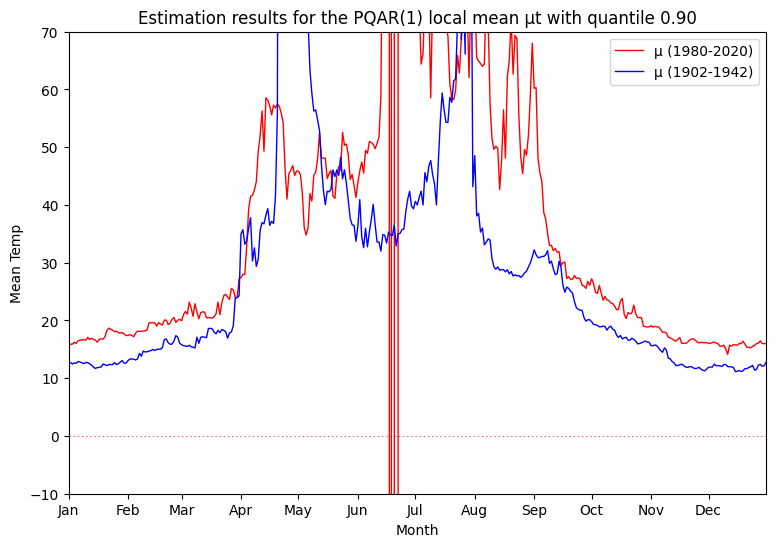

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Bilt_1980_2020_low, [1980, 1902], [2020, 1942], 'Mu', 'Bilt', 'PQAR(1)', q='0.10', df2=PQAR_df_Bilt_1902_1942_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Bilt_1980_2020_mean, [1980, 1902], [2020, 1942], 'Mu', 'Bilt', 'PQAR(1)', q='0.50', df2=PQAR_df_Bilt_1902_1942_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Bilt_1980_2020_high, [1980, 1902], [2020, 1942], 'Mu', 'Bilt', 'PQAR(1)', q='0.90', df2=PQAR_df_Bilt_1902_1942_high)

### Bremen

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Bremen_1980_2020 = estimate_PAR_params(df_Bremen, 1980, 2020)
# PAR_df_Bremen_1900_1940 = estimate_PAR_params(df_Bremen, 1900, 1940) # dataset is from 1900

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Bremen_1980_2020_low = estimate_PQAR_params(df_Bremen, 1980, 2020, 0.10)
# PQAR_df_Bremen_1900_1940_low = estimate_PQAR_params(df_Bremen, 1900, 1940, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Bremen_1980_2020_mean = estimate_PQAR_params(df_Bremen, 1980, 2020, 0.50)
# PQAR_df_Bremen_1900_1940_mean = estimate_PQAR_params(df_Bremen, 1900, 1940, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Bremen_1980_2020_high = estimate_PQAR_params(df_Bremen, 1980, 2020, 0.90)
# PQAR_df_Bremen_1900_1940_high = estimate_PQAR_params(df_Bremen, 1900, 1940, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Bremen_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bremen_1980_2020.feather")
# PAR_df_Bremen_1900_1940.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bremen_1900_1940.feather")

# PQAR_df_Bremen_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1980_2020_low.feather")
# PQAR_df_Bremen_1900_1940_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1900_1940_low.feather")

# PQAR_df_Bremen_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1980_2020_mean.feather")
# PQAR_df_Bremen_1900_1940_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1900_1940_mean.feather")

# PQAR_df_Bremen_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1980_2020_high.feather")
# PQAR_df_Bremen_1900_1940_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1900_1940_high.feather")

In [ ]:
# Read df
PAR_df_Bremen_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bremen_1980_2020.feather")
PAR_df_Bremen_1900_1940 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bremen_1900_1940.feather")

PQAR_df_Bremen_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1980_2020_low.feather")
PQAR_df_Bremen_1900_1940_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1900_1940_low.feather")

PQAR_df_Bremen_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1980_2020_mean.feather")
PQAR_df_Bremen_1900_1940_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1900_1940_mean.feather")

PQAR_df_Bremen_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1980_2020_high.feather")
PQAR_df_Bremen_1900_1940_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bremen_1900_1940_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Bremen_jan = PAR_df_Bremen_1980_2020['Phi'].loc[14]-PAR_df_Bremen_1900_1940['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Bremen for PAR(1): {Delta_Phi_PAR_Bremen_jan}')

Delta_Phi_PQAR_Bremen_jan_low = PQAR_df_Bremen_1980_2020_low['Phi'].loc[14]-PQAR_df_Bremen_1900_1940_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Bremen for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Bremen_jan_low}')

Delta_Phi_PQAR_Bremen_jan_mean = PQAR_df_Bremen_1980_2020_mean['Phi'].loc[14]-PQAR_df_Bremen_1900_1940_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Bremen for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Bremen_jan_mean}')

Delta_Phi_PQAR_Bremen_jan_high = PQAR_df_Bremen_1980_2020_high['Phi'].loc[14]-PQAR_df_Bremen_1900_1940_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Bremen for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Bremen_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Bremen_jul = PAR_df_Bremen_1980_2020['Phi'].loc[195]-PAR_df_Bremen_1900_1940['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Bremen for PAR(1): {Delta_Phi_PAR_Bremen_jul}')

Delta_Phi_PQAR_Bremen_jul_low = PQAR_df_Bremen_1980_2020_low['Phi'].loc[195]-PQAR_df_Bremen_1900_1940_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Bremen for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Bremen_jul_low}')

Delta_Phi_PQAR_Bremen_jul_mean = PQAR_df_Bremen_1980_2020_mean['Phi'].loc[195]-PQAR_df_Bremen_1900_1940_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Bremen for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Bremen_jul_mean}')

Delta_Phi_PQAR_Bremen_jul_high = PQAR_df_Bremen_1980_2020_high['Phi'].loc[195]-PQAR_df_Bremen_1900_1940_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Bremen for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Bremen_jul_high}')

Difference in Phi for January 15 in Bremen for PAR(1): 0.015036730895829464
Difference in Phi for January 15 in Bremen for PQAR(1) with quantile 0.10: -0.00756895402406077
Difference in Phi for January 15 in Bremen for PQAR(1) with quantile 0.50: 0.0052753232032034525
Difference in Phi for January 15 in Bremen for PQAR(1) with quantile 0.90: 0.09138659251549652
Difference in Phi for July 15 in Bremen for PAR(1): 0.10941663025965698
Difference in Phi for July 15 in Bremen for PQAR(1) with quantile 0.10: 0.12196648108822933
Difference in Phi for July 15 in Bremen for PQAR(1) with quantile 0.50: 0.11026327086431875
Difference in Phi for July 15 in Bremen for PQAR(1) with quantile 0.90: 0.018342829665769278


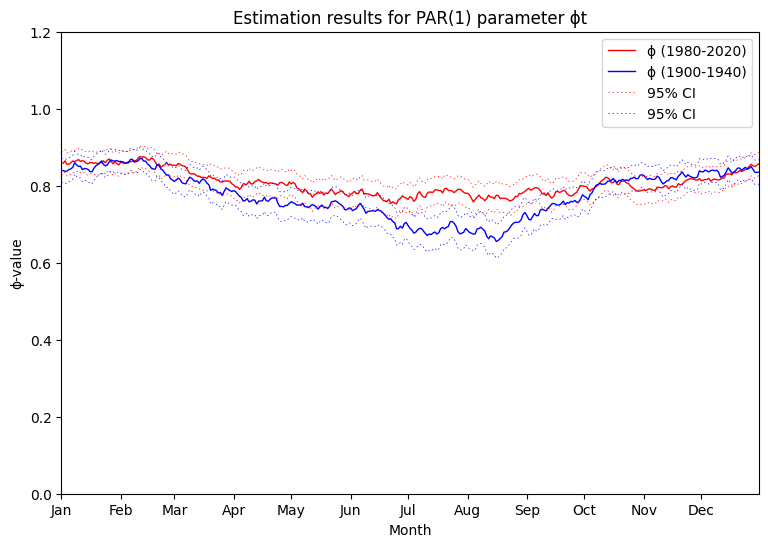

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_Bremen_1980_2020, [1980, 1900], [2020, 1940], 'Phi', 'Bremen', 'PAR(1)', df2=PAR_df_Bremen_1900_1940)

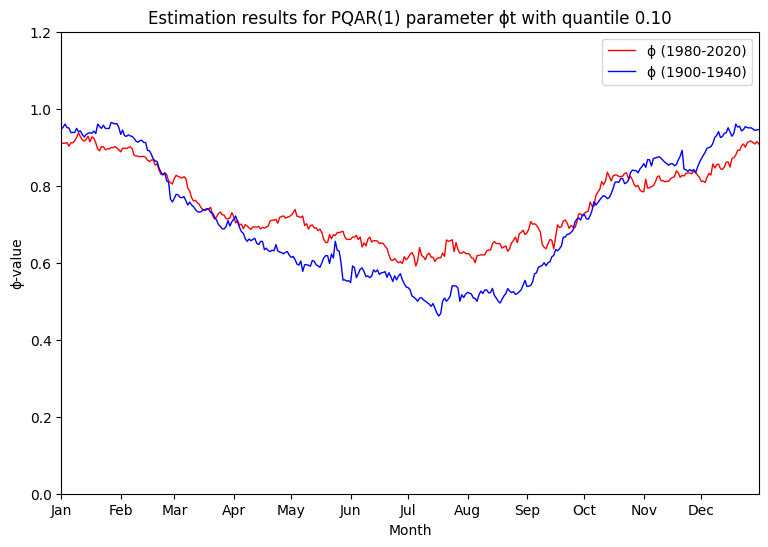

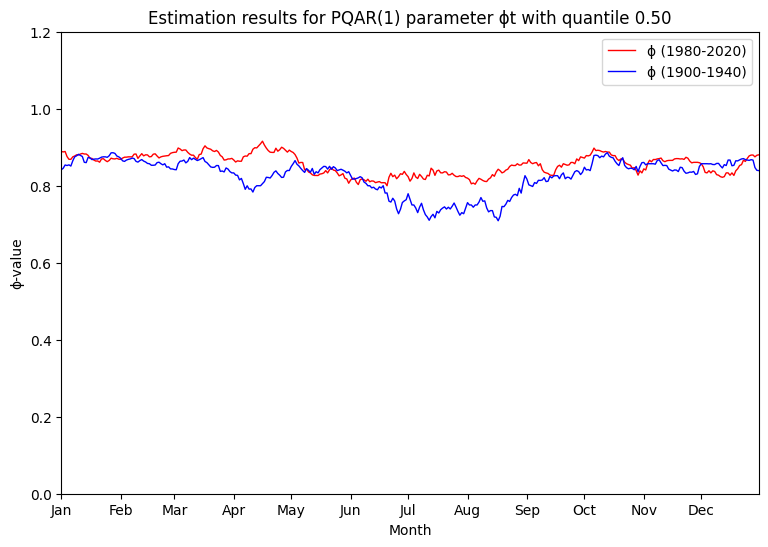

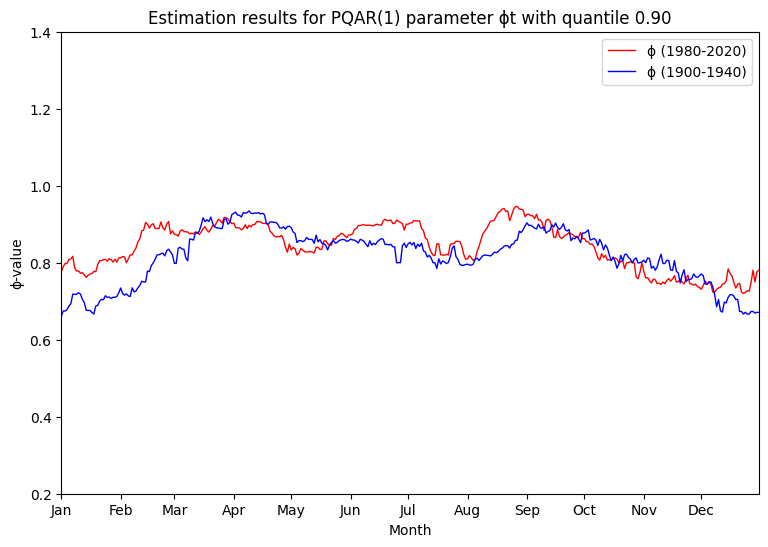

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Bremen_1980_2020_low, [1980, 1900], [2020, 1940], 'Phi', 'Bremen', 'PQAR(1)', q='0.10', df2=PQAR_df_Bremen_1900_1940_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Bremen_1980_2020_mean, [1980, 1900], [2020, 1940], 'Phi', 'Bremen', 'PQAR(1)', q='0.50', df2=PQAR_df_Bremen_1900_1940_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Bremen_1980_2020_high, [1980, 1900], [2020, 1940], 'Phi', 'Bremen', 'PQAR(1)', q='0.90', df2=PQAR_df_Bremen_1900_1940_high)

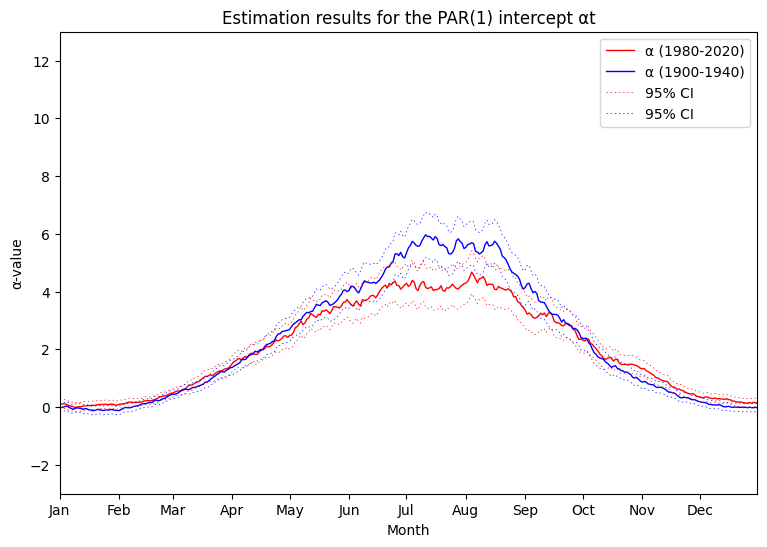

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Bremen_1980_2020, [1980, 1900], [2020, 1940], 'Alpha', 'Bremen', 'PAR(1)', df2=PAR_df_Bremen_1900_1940)

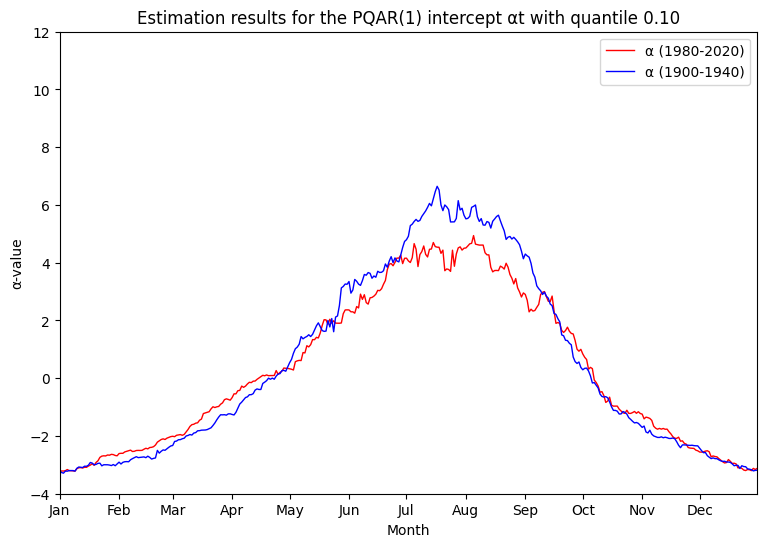

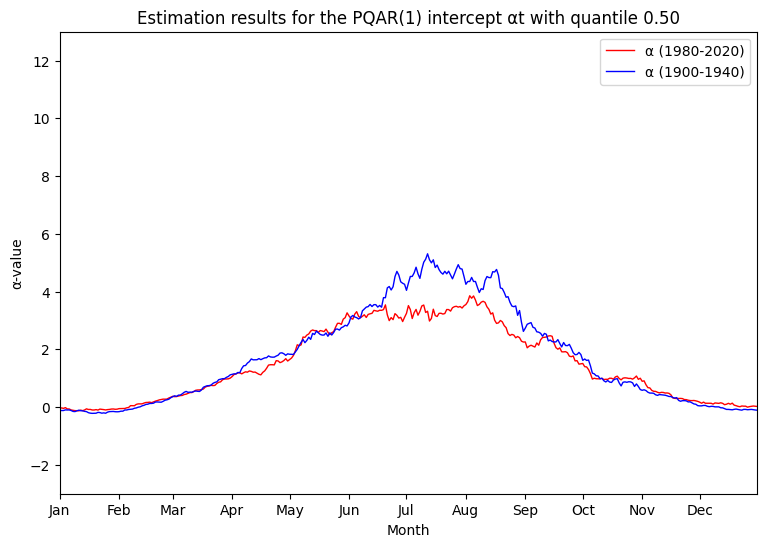

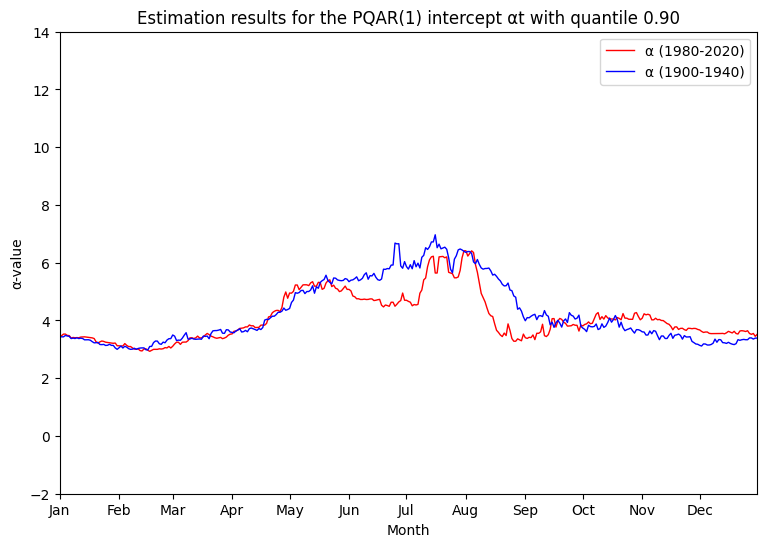

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Bremen_1980_2020_low, [1980, 1900], [2020, 1940], 'Alpha', 'Bremen', 'PQAR(1)', q='0.10', df2=PQAR_df_Bremen_1900_1940_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Bremen_1980_2020_mean, [1980, 1900], [2020, 1940], 'Alpha', 'Bremen', 'PQAR(1)', q='0.50', df2=PQAR_df_Bremen_1900_1940_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Bremen_1980_2020_high, [1980, 1900], [2020, 1940], 'Alpha', 'Bremen', 'PQAR(1)', q='0.90', df2=PQAR_df_Bremen_1900_1940_high)

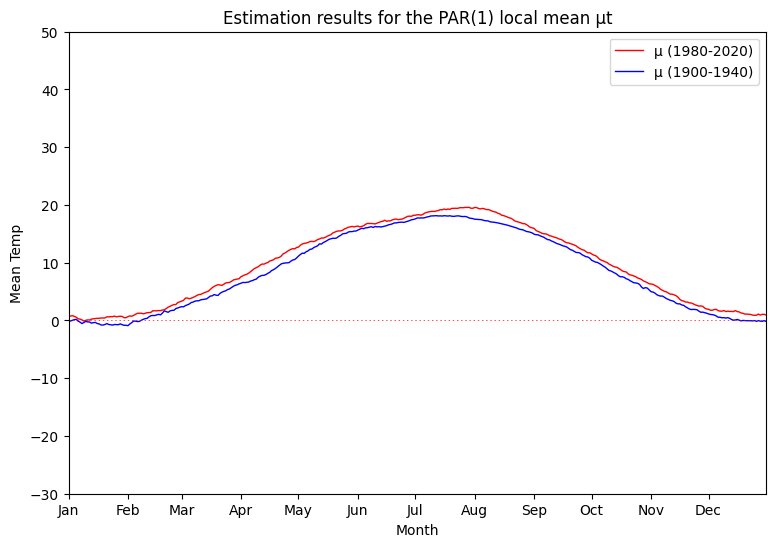

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Bremen_1980_2020, [1980, 1900], [2020, 1940], 'Mu', 'Bremen', 'PAR(1)', df2=PAR_df_Bremen_1900_1940)

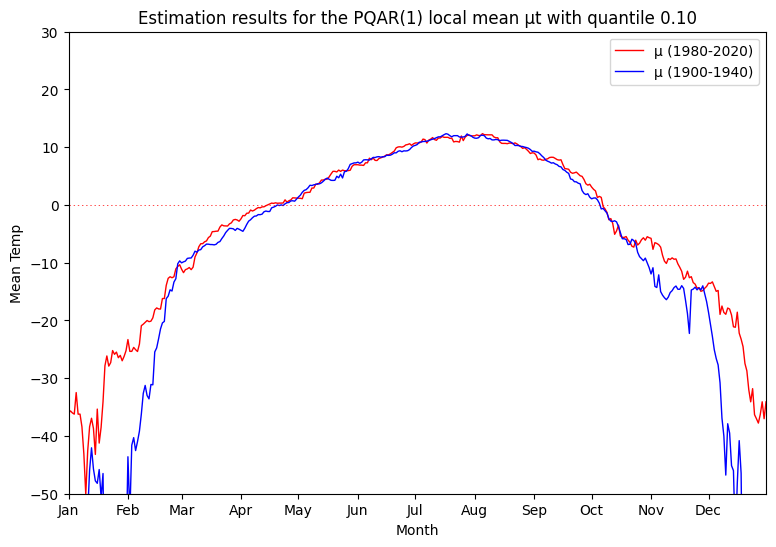

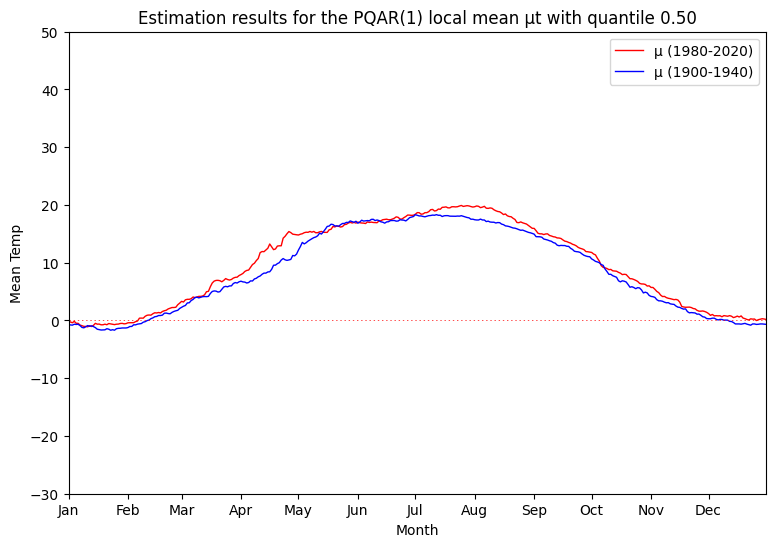

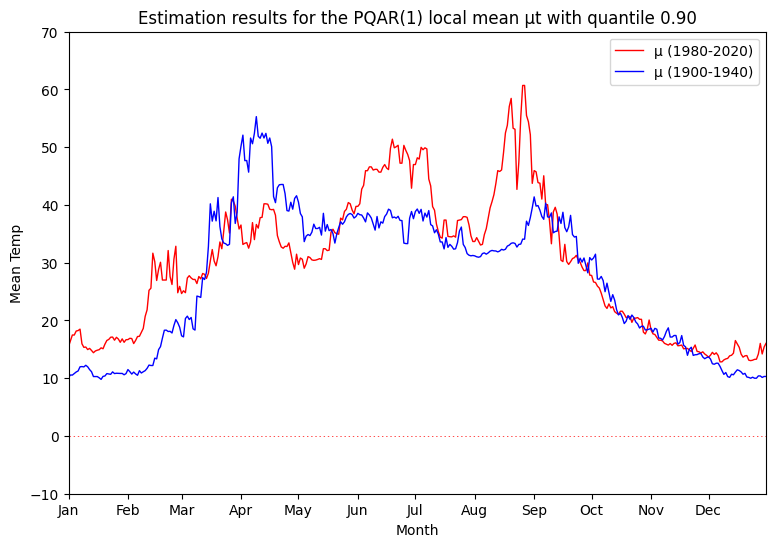

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Bremen_1980_2020_low, [1980, 1900], [2020, 1940], 'Mu', 'Bremen', 'PQAR(1)', q='0.10', df2=PQAR_df_Bremen_1900_1940_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Bremen_1980_2020_mean, [1980, 1900], [2020, 1940], 'Mu', 'Bremen', 'PQAR(1)', q='0.50', df2=PQAR_df_Bremen_1900_1940_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Bremen_1980_2020_high, [1980, 1900], [2020, 1940], 'Mu', 'Bremen', 'PQAR(1)', q='0.90', df2=PQAR_df_Bremen_1900_1940_high)

### Dublin

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Dublin_1980_2020 = estimate_PAR_params(df_Dublin, 1980, 2020)
# PAR_df_Dublin_1900_1940 = estimate_PAR_params(df_Dublin, 1900, 1940)

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Dublin_1980_2020_low = estimate_PQAR_params(df_Dublin, 1980, 2020, 0.10)
# PQAR_df_Dublin_1900_1940_low = estimate_PQAR_params(df_Dublin, 1900, 1940, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Dublin_1980_2020_mean = estimate_PQAR_params(df_Dublin, 1980, 2020, 0.50)
# PQAR_df_Dublin_1900_1940_mean = estimate_PQAR_params(df_Dublin, 1900, 1940, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Dublin_1980_2020_high = estimate_PQAR_params(df_Dublin, 1980, 2020, 0.90)
# PQAR_df_Dublin_1900_1940_high = estimate_PQAR_params(df_Dublin, 1900, 1940, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Dublin_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Dublin_1980_2020.feather")
# PAR_df_Dublin_1900_1940.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Dublin_1900_1940.feather")

# PQAR_df_Dublin_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1980_2020_low.feather")
# PQAR_df_Dublin_1900_1940_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1900_1940_low.feather")

# PQAR_df_Dublin_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1980_2020_mean.feather")
# PQAR_df_Dublin_1900_1940_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1900_1940_mean.feather")

# PQAR_df_Dublin_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1980_2020_high.feather")
# PQAR_df_Dublin_1900_1940_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1900_1940_high.feather")

In [ ]:
# Read df
PAR_df_Dublin_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Dublin_1980_2020.feather")
PAR_df_Dublin_1900_1940 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Dublin_1900_1940.feather")

PQAR_df_Dublin_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1980_2020_low.feather")
PQAR_df_Dublin_1900_1940_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1900_1940_low.feather")

PQAR_df_Dublin_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1980_2020_mean.feather")
PQAR_df_Dublin_1900_1940_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1900_1940_mean.feather")

PQAR_df_Dublin_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1980_2020_high.feather")
PQAR_df_Dublin_1900_1940_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Dublin_1900_1940_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Dublin_jan = PAR_df_Dublin_1980_2020['Phi'].loc[14]-PAR_df_Dublin_1900_1940['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Dublin for PAR(1): {Delta_Phi_PAR_Dublin_jan}')

Delta_Phi_PQAR_Dublin_jan_low = PQAR_df_Dublin_1980_2020_low['Phi'].loc[14]-PQAR_df_Dublin_1900_1940_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Dublin for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Dublin_jan_low}')

Delta_Phi_PQAR_Dublin_jan_mean = PQAR_df_Dublin_1980_2020_mean['Phi'].loc[14]-PQAR_df_Dublin_1900_1940_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Dublin for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Dublin_jan_mean}')

Delta_Phi_PQAR_Dublin_jan_high = PQAR_df_Dublin_1980_2020_high['Phi'].loc[14]-PQAR_df_Dublin_1900_1940_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Dublin for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Dublin_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Dublin_jul = PAR_df_Dublin_1980_2020['Phi'].loc[195]-PAR_df_Dublin_1900_1940['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Dublin for PAR(1): {Delta_Phi_PAR_Dublin_jul}')

Delta_Phi_PQAR_Dublin_jul_low = PQAR_df_Dublin_1980_2020_low['Phi'].loc[195]-PQAR_df_Dublin_1900_1940_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Dublin for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Dublin_jul_low}')

Delta_Phi_PQAR_Dublin_jul_mean = PQAR_df_Dublin_1980_2020_mean['Phi'].loc[195]-PQAR_df_Dublin_1900_1940_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Dublin for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Dublin_jul_mean}')

Delta_Phi_PQAR_Dublin_jul_high = PQAR_df_Dublin_1980_2020_high['Phi'].loc[195]-PQAR_df_Dublin_1900_1940_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Dublin for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Dublin_jul_high}')

Difference in Phi for January 15 in Dublin for PAR(1): 0.0441858936287467
Difference in Phi for January 15 in Dublin for PQAR(1) with quantile 0.10: -0.09228032346411374
Difference in Phi for January 15 in Dublin for PQAR(1) with quantile 0.50: 0.04626982692397141
Difference in Phi for January 15 in Dublin for PQAR(1) with quantile 0.90: 0.33632294753042363
Difference in Phi for July 15 in Dublin for PAR(1): 0.02243454984411941
Difference in Phi for July 15 in Dublin for PQAR(1) with quantile 0.10: 0.005691973120334315
Difference in Phi for July 15 in Dublin for PQAR(1) with quantile 0.50: 0.01354583533831244
Difference in Phi for July 15 in Dublin for PQAR(1) with quantile 0.90: 0.07300774252438458


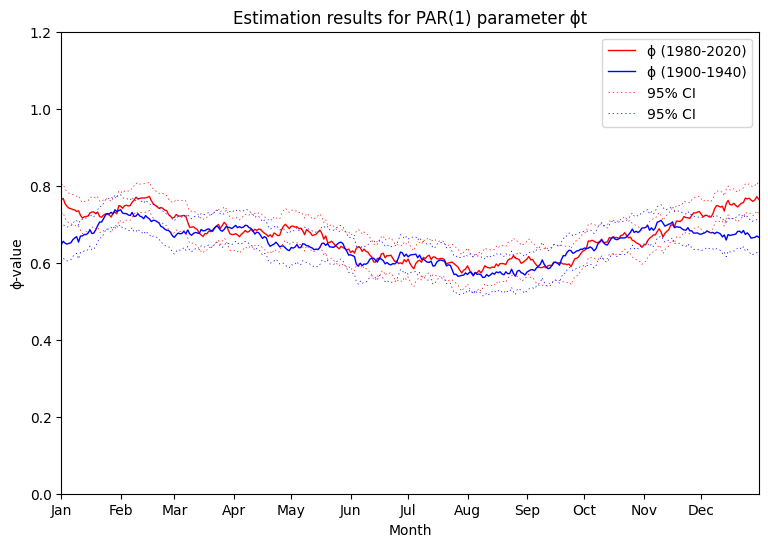

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_Dublin_1980_2020, [1980, 1900], [2020, 1940], 'Phi', 'Dublin', 'PAR(1)', df2=PAR_df_Dublin_1900_1940)

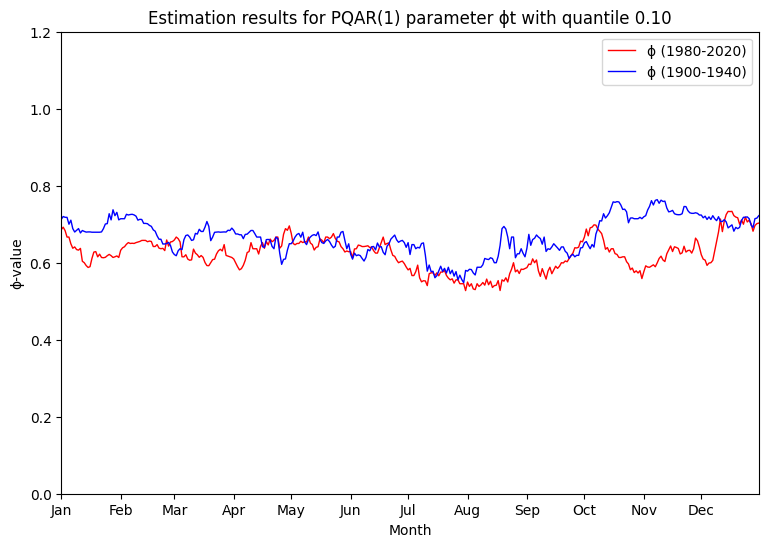

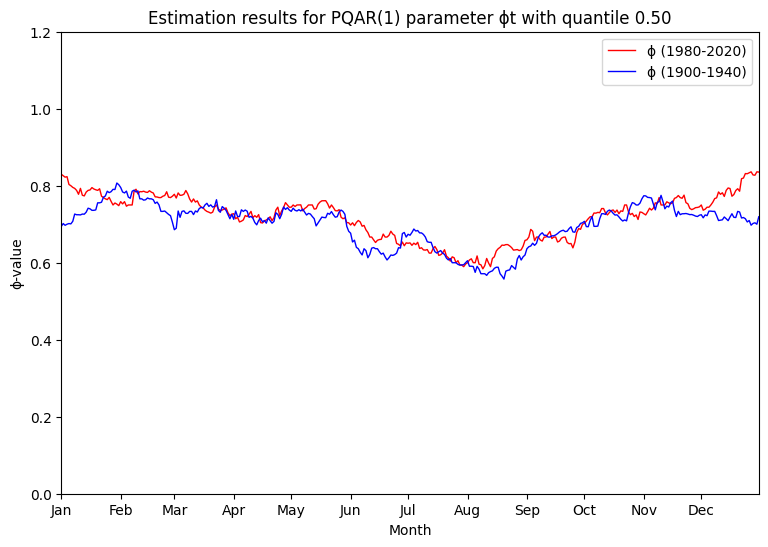

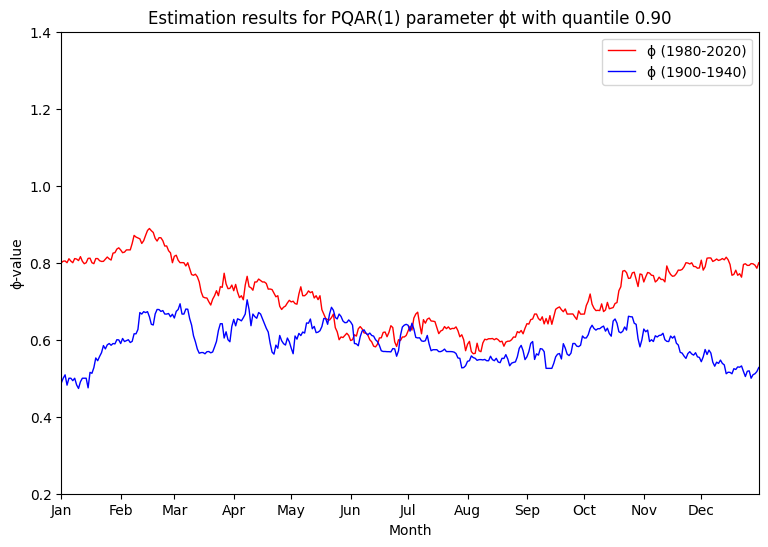

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Dublin_1980_2020_low, [1980, 1900], [2020, 1940], 'Phi', 'Dublin', 'PQAR(1)', q='0.10', df2=PQAR_df_Dublin_1900_1940_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Dublin_1980_2020_mean, [1980, 1900], [2020, 1940], 'Phi', 'Dublin', 'PQAR(1)', q='0.50', df2=PQAR_df_Dublin_1900_1940_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Dublin_1980_2020_high, [1980, 1900], [2020, 1940], 'Phi', 'Dublin', 'PQAR(1)', q='0.90', df2=PQAR_df_Dublin_1900_1940_high)

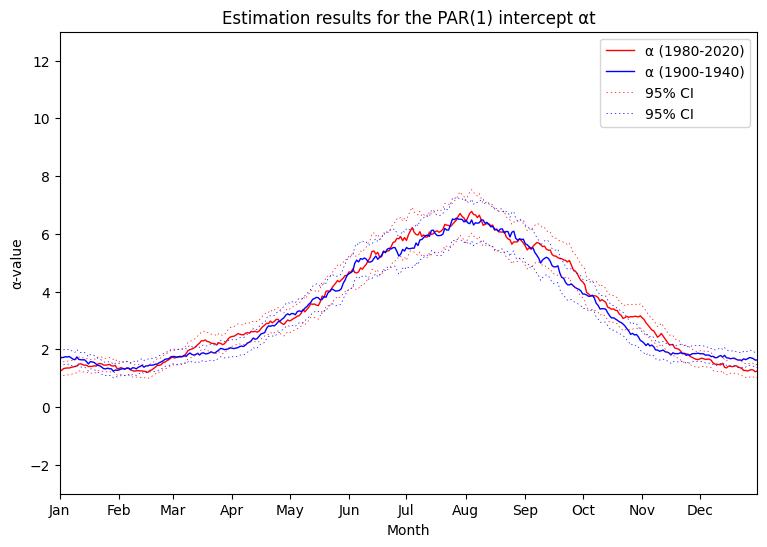

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Dublin_1980_2020, [1980, 1900], [2020, 1940], 'Alpha', 'Dublin', 'PAR(1)', df2=PAR_df_Dublin_1900_1940)

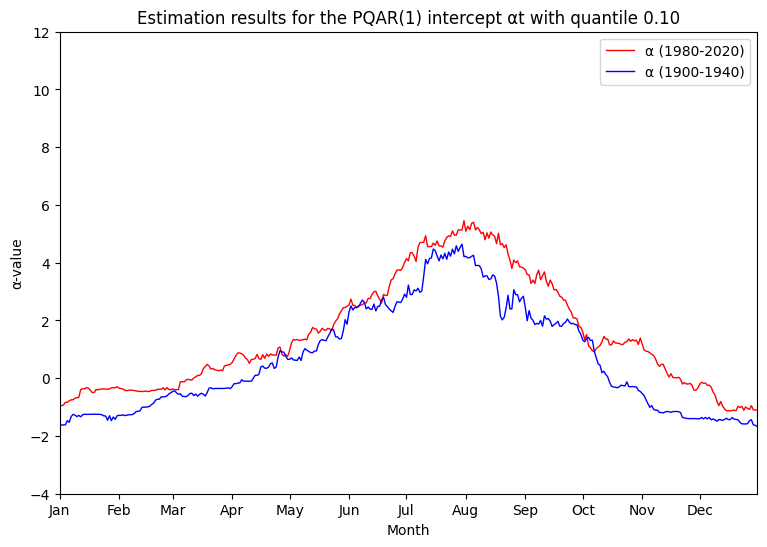

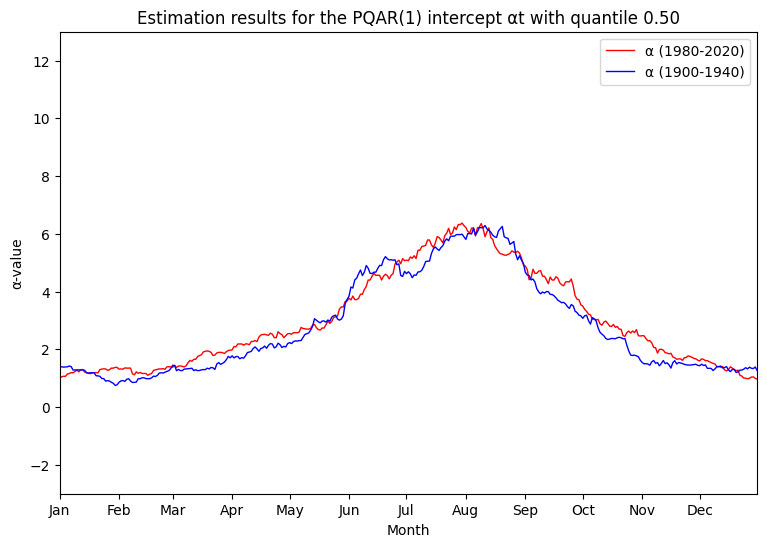

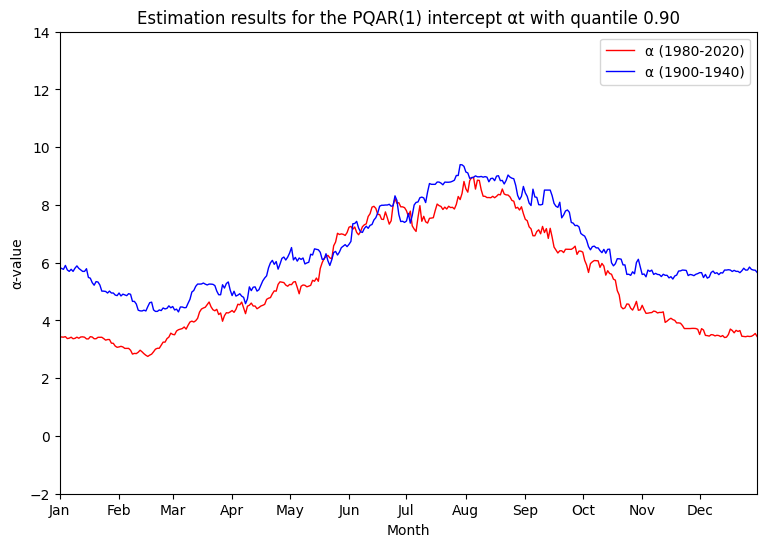

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Dublin_1980_2020_low, [1980, 1900], [2020, 1940], 'Alpha', 'Dublin', 'PQAR(1)', q='0.10', df2=PQAR_df_Dublin_1900_1940_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Dublin_1980_2020_mean, [1980, 1900], [2020, 1940], 'Alpha', 'Dublin', 'PQAR(1)', q='0.50', df2=PQAR_df_Dublin_1900_1940_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Dublin_1980_2020_high, [1980, 1900], [2020, 1940], 'Alpha', 'Dublin', 'PQAR(1)', q='0.90', df2=PQAR_df_Dublin_1900_1940_high)

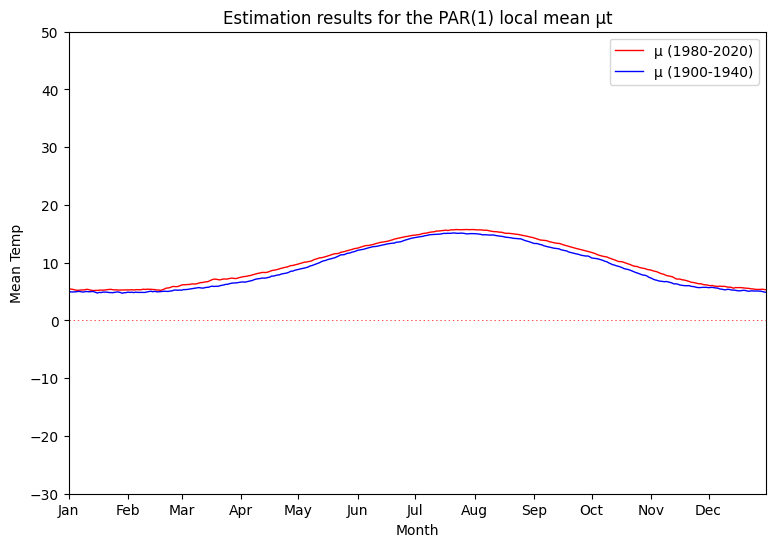

In [ ]:
# Plot the local mean Mu
plot(PAR_df_Dublin_1980_2020, [1980, 1900], [2020, 1940], 'Mu', 'Dublin', 'PAR(1)', df2=PAR_df_Dublin_1900_1940)

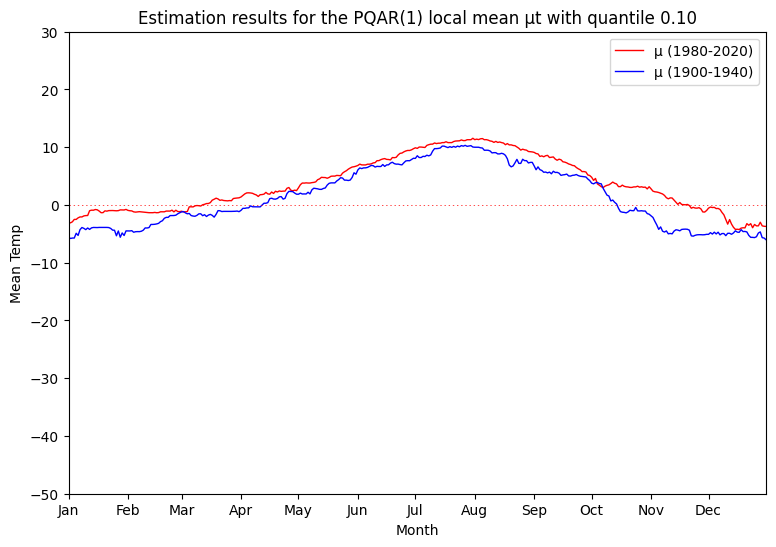

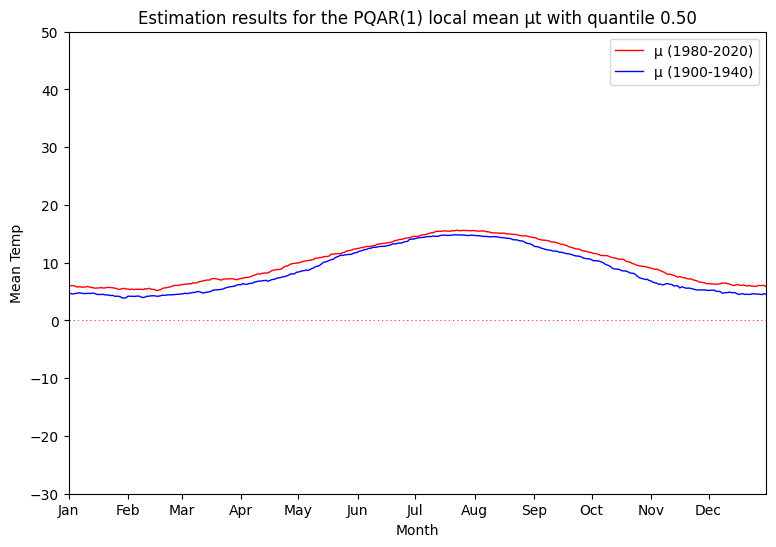

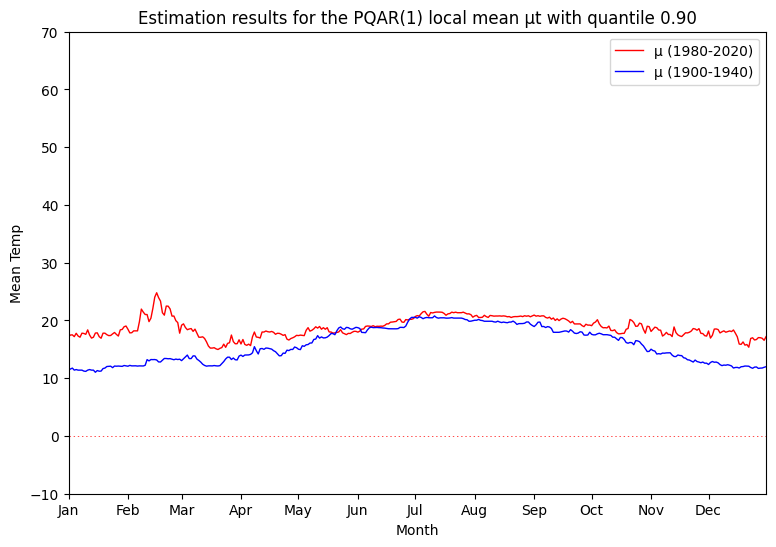

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Dublin_1980_2020_low, [1980, 1900], [2020, 1940], 'Mu', 'Dublin', 'PQAR(1)', q='0.10', df2=PQAR_df_Dublin_1900_1940_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Dublin_1980_2020_mean, [1980, 1900], [2020, 1940], 'Mu', 'Dublin', 'PQAR(1)', q='0.50', df2=PQAR_df_Dublin_1900_1940_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Dublin_1980_2020_high, [1980, 1900], [2020, 1940], 'Mu', 'Dublin', 'PQAR(1)', q='0.90', df2=PQAR_df_Dublin_1900_1940_high)

### Stockholm

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Stockholm_1980_2020 = estimate_PAR_params(df_Stockholm, 1980, 2020)
# PAR_df_Stockholm_1900_1940 = estimate_PAR_params(df_Stockholm, 1900, 1940)

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Stockholm_1980_2020_low = estimate_PQAR_params(df_Stockholm, 1980, 2020, 0.10)
# PQAR_df_Stockholm_1900_1940_low = estimate_PQAR_params(df_Stockholm, 1900, 1940, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Stockholm_1980_2020_mean = estimate_PQAR_params(df_Stockholm, 1980, 2020, 0.50)
# PQAR_df_Stockholm_1900_1940_mean = estimate_PQAR_params(df_Stockholm, 1900, 1940, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Stockholm_1980_2020_high = estimate_PQAR_params(df_Stockholm, 1980, 2020, 0.90)
# PQAR_df_Stockholm_1900_1940_high = estimate_PQAR_params(df_Stockholm, 1900, 1940, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Stockholm_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Stockholm_1980_2020.feather")
# PAR_df_Stockholm_1900_1940.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Stockholm_1900_1940.feather")

# PQAR_df_Stockholm_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1980_2020_low.feather")
# PQAR_df_Stockholm_1900_1940_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1900_1940_low.feather")

# PQAR_df_Stockholm_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1980_2020_mean.feather")
# PQAR_df_Stockholm_1900_1940_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1900_1940_mean.feather")

# PQAR_df_Stockholm_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1980_2020_high.feather")
# PQAR_df_Stockholm_1900_1940_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1900_1940_high.feather")

In [ ]:
# Read df
PAR_df_Stockholm_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Stockholm_1980_2020.feather")
PAR_df_Stockholm_1900_1940 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Stockholm_1900_1940.feather")

PQAR_df_Stockholm_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1980_2020_low.feather")
PQAR_df_Stockholm_1900_1940_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1900_1940_low.feather")

PQAR_df_Stockholm_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1980_2020_mean.feather")
PQAR_df_Stockholm_1900_1940_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1900_1940_mean.feather")

PQAR_df_Stockholm_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1980_2020_high.feather")
PQAR_df_Stockholm_1900_1940_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Stockholm_1900_1940_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Stockholm_jan = PAR_df_Stockholm_1980_2020['Phi'].loc[14]-PAR_df_Stockholm_1900_1940['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Stockholm for PAR(1): {Delta_Phi_PAR_Stockholm_jan}')

Delta_Phi_PQAR_Stockholm_jan_low = PQAR_df_Stockholm_1980_2020_low['Phi'].loc[14]-PQAR_df_Stockholm_1900_1940_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Stockholm for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Stockholm_jan_low}')

Delta_Phi_PQAR_Stockholm_jan_mean = PQAR_df_Stockholm_1980_2020_mean['Phi'].loc[14]-PQAR_df_Stockholm_1900_1940_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Stockholm for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Stockholm_jan_mean}')

Delta_Phi_PQAR_Stockholm_jan_high = PQAR_df_Stockholm_1980_2020_high['Phi'].loc[14]-PQAR_df_Stockholm_1900_1940_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Stockholm for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Stockholm_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Stockholm_jul = PAR_df_Stockholm_1980_2020['Phi'].loc[195]-PAR_df_Stockholm_1900_1940['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Stockholm for PAR(1): {Delta_Phi_PAR_Stockholm_jul}')

Delta_Phi_PQAR_Stockholm_jul_low = PQAR_df_Stockholm_1980_2020_low['Phi'].loc[195]-PQAR_df_Stockholm_1900_1940_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Stockholm for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Stockholm_jul_low}')

Delta_Phi_PQAR_Stockholm_jul_mean = PQAR_df_Stockholm_1980_2020_mean['Phi'].loc[195]-PQAR_df_Stockholm_1900_1940_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Stockholm for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Stockholm_jul_mean}')

Delta_Phi_PQAR_Stockholm_jul_high = PQAR_df_Stockholm_1980_2020_high['Phi'].loc[195]-PQAR_df_Stockholm_1900_1940_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Stockholm for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Stockholm_jul_high}')

Difference in Phi for January 15 in Stockholm for PAR(1): 0.11326966872386257
Difference in Phi for January 15 in Stockholm for PQAR(1) with quantile 0.10: 0.07306816583887188
Difference in Phi for January 15 in Stockholm for PQAR(1) with quantile 0.50: 0.057005676959899554
Difference in Phi for January 15 in Stockholm for PQAR(1) with quantile 0.90: 0.16480807998562208
Difference in Phi for July 15 in Stockholm for PAR(1): 0.03311259879768658
Difference in Phi for July 15 in Stockholm for PQAR(1) with quantile 0.10: -0.004573032130033905
Difference in Phi for July 15 in Stockholm for PQAR(1) with quantile 0.50: 0.05884754612042231
Difference in Phi for July 15 in Stockholm for PQAR(1) with quantile 0.90: 0.02789568276733767


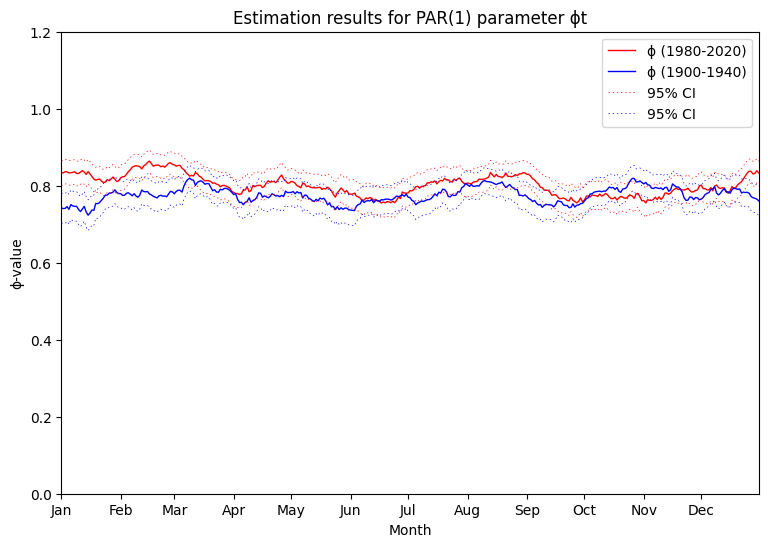

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_Stockholm_1980_2020, [1980, 1900], [2020, 1940], 'Phi', 'Stockholm', 'PAR(1)', df2=PAR_df_Stockholm_1900_1940)

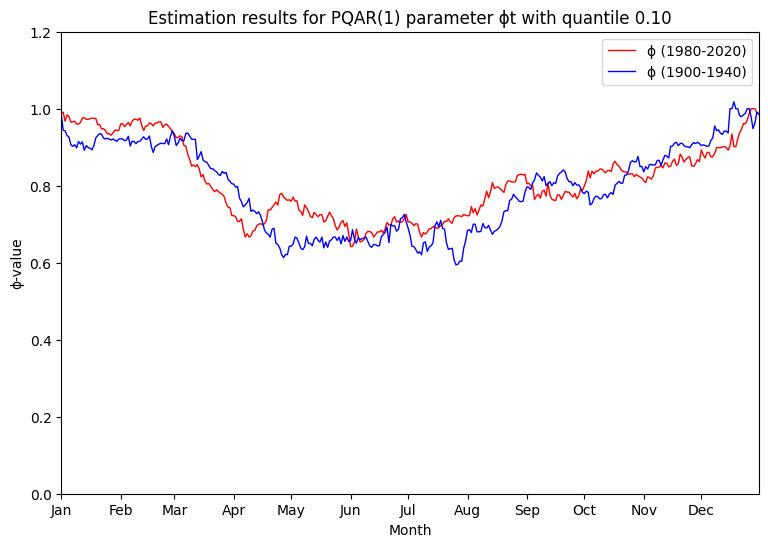

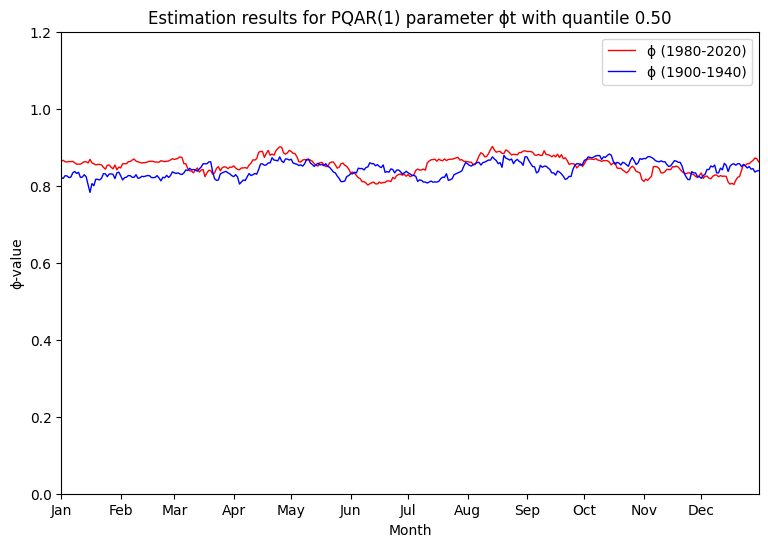

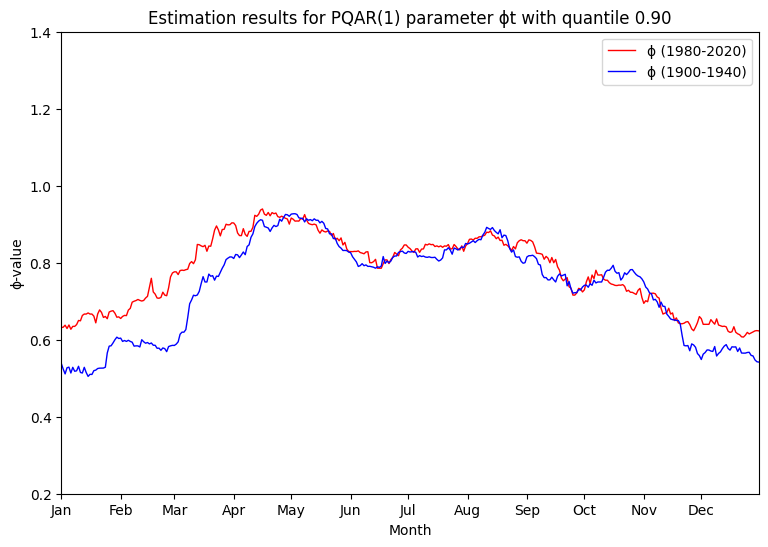

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Stockholm_1980_2020_low, [1980, 1900], [2020, 1940], 'Phi', 'Stockholm', 'PQAR(1)', q='0.10', df2=PQAR_df_Stockholm_1900_1940_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Stockholm_1980_2020_mean, [1980, 1900], [2020, 1940], 'Phi', 'Stockholm', 'PQAR(1)', q='0.50', df2=PQAR_df_Stockholm_1900_1940_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Stockholm_1980_2020_high, [1980, 1900], [2020, 1940], 'Phi', 'Stockholm', 'PQAR(1)', q='0.90', df2=PQAR_df_Stockholm_1900_1940_high)

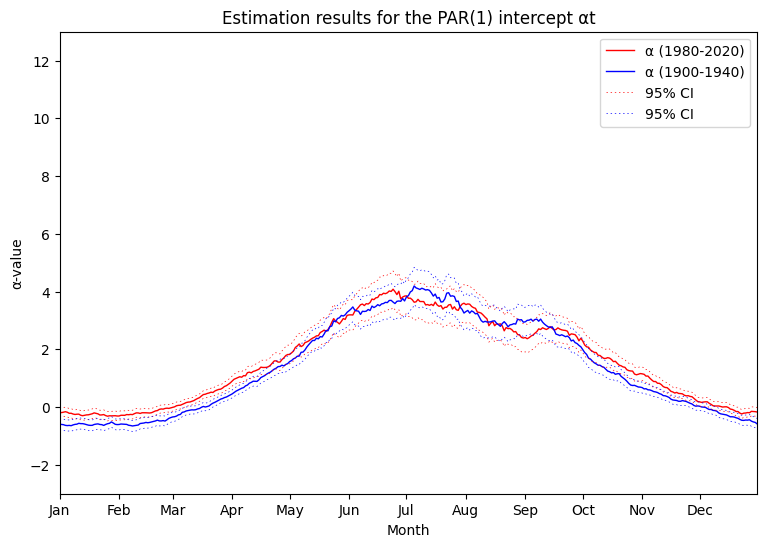

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Stockholm_1980_2020, [1980, 1900], [2020, 1940], 'Alpha', 'Stockholm', 'PAR(1)', df2=PAR_df_Stockholm_1900_1940)

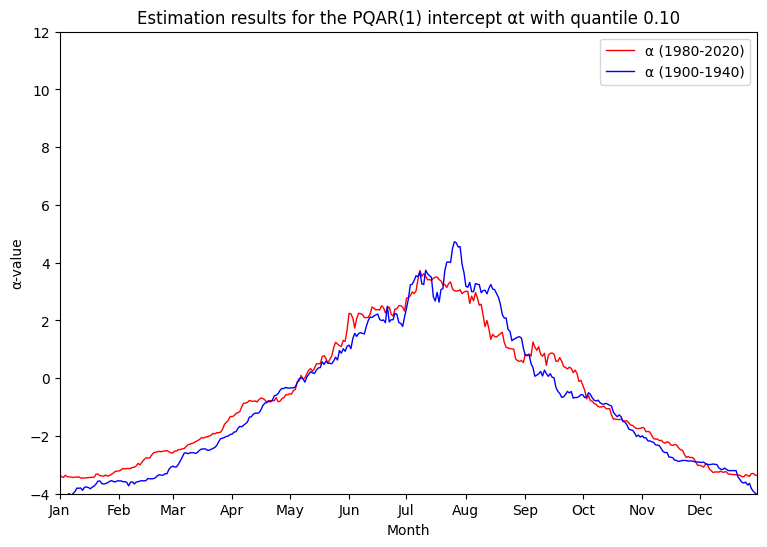

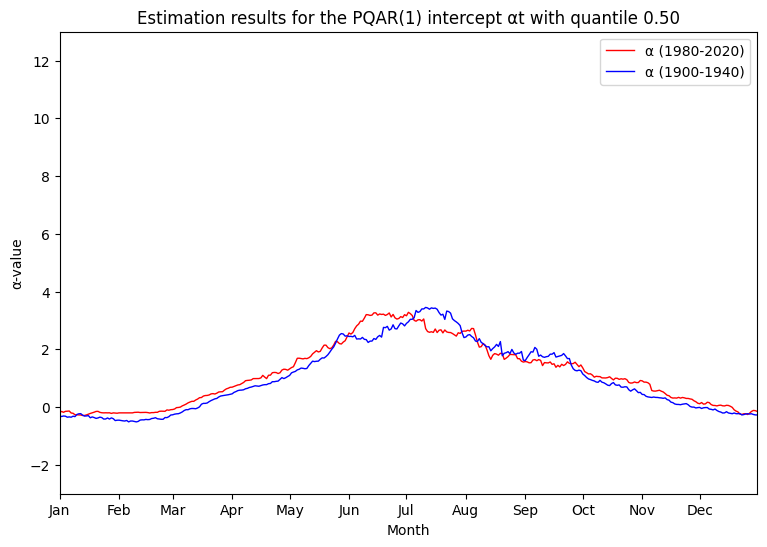

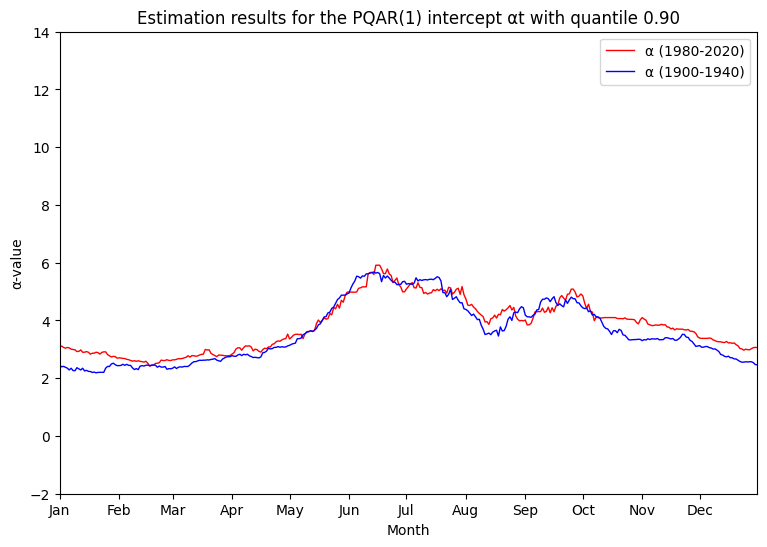

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Stockholm_1980_2020_low, [1980, 1900], [2020, 1940], 'Alpha', 'Stockholm', 'PQAR(1)', q='0.10', df2=PQAR_df_Stockholm_1900_1940_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Stockholm_1980_2020_mean, [1980, 1900], [2020, 1940], 'Alpha', 'Stockholm', 'PQAR(1)', q='0.50', df2=PQAR_df_Stockholm_1900_1940_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Stockholm_1980_2020_high, [1980, 1900], [2020, 1940], 'Alpha', 'Stockholm', 'PQAR(1)', q='0.90', df2=PQAR_df_Stockholm_1900_1940_high)

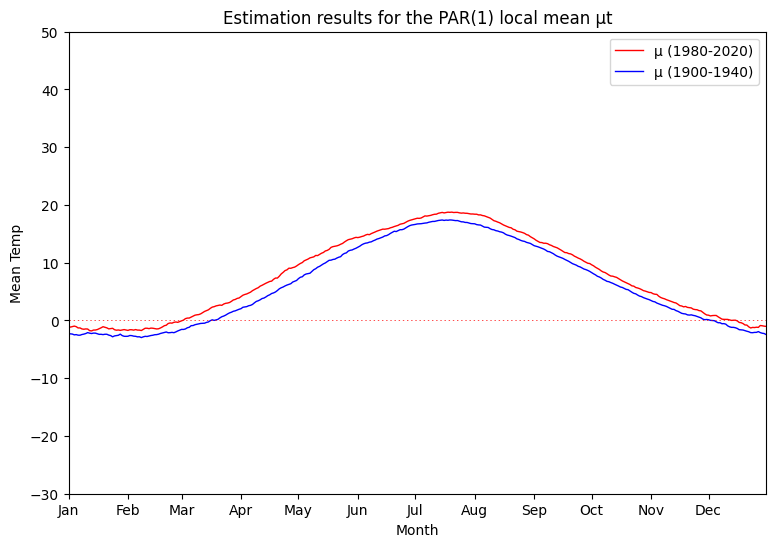

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Stockholm_1980_2020, [1980, 1900], [2020, 1940], 'Mu', 'Stockholm', 'PAR(1)', df2=PAR_df_Stockholm_1900_1940)

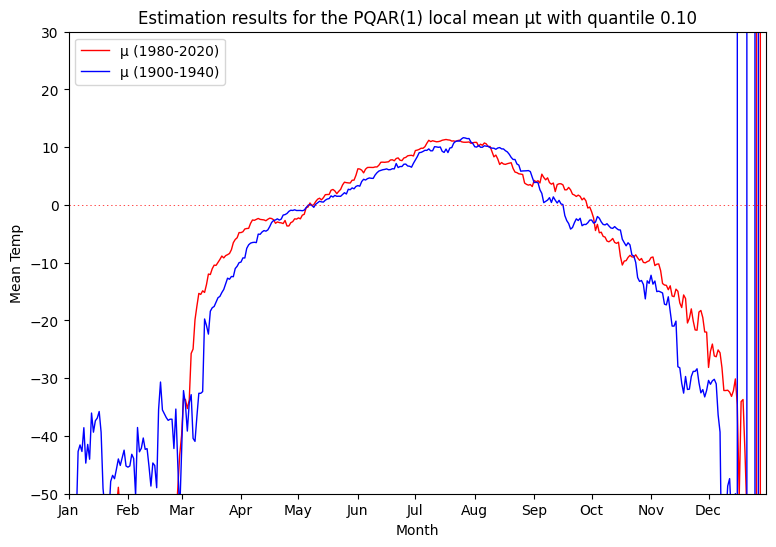

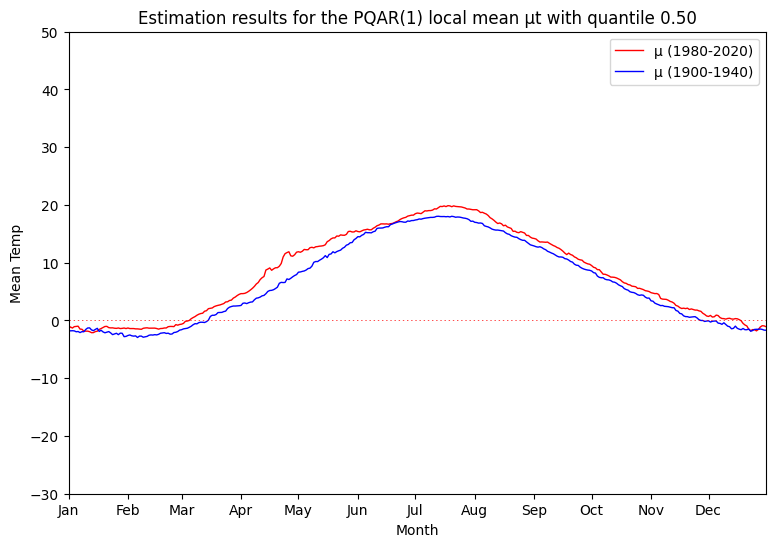

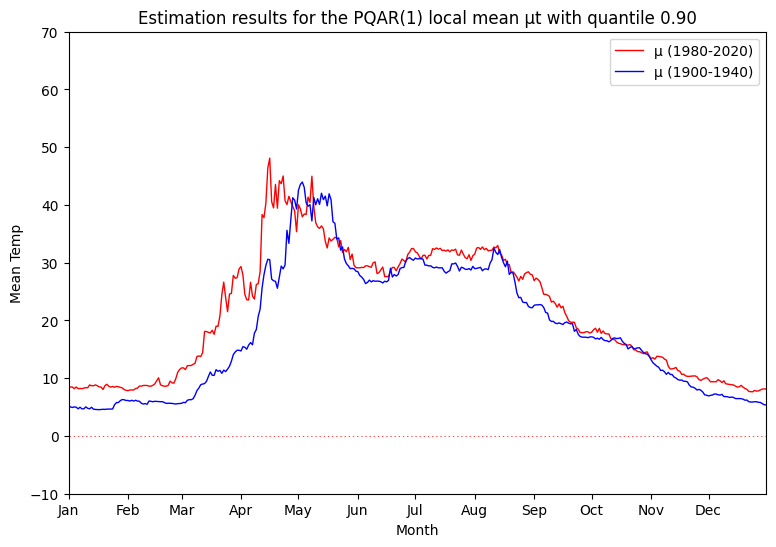

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Stockholm_1980_2020_low, [1980, 1900], [2020, 1940], 'Mu', 'Stockholm', 'PQAR(1)', q='0.10', df2=PQAR_df_Stockholm_1900_1940_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Stockholm_1980_2020_mean, [1980, 1900], [2020, 1940], 'Mu', 'Stockholm', 'PQAR(1)', q='0.50', df2=PQAR_df_Stockholm_1900_1940_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Stockholm_1980_2020_high, [1980, 1900], [2020, 1940], 'Mu', 'Stockholm', 'PQAR(1)', q='0.90', df2=PQAR_df_Stockholm_1900_1940_high)

### Wenen

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Wenen_1980_2020 = estimate_PAR_params(df_Wenen, 1980, 2020)
# PAR_df_Wenen_1900_1940 = estimate_PAR_params(df_Wenen, 1900, 1940)

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Wenen_1980_2020_low = estimate_PQAR_params(df_Wenen, 1980, 2020, 0.10)
# PQAR_df_Wenen_1900_1940_low = estimate_PQAR_params(df_Wenen, 1900, 1940, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Wenen_1980_2020_mean = estimate_PQAR_params(df_Wenen, 1980, 2020, 0.50)
# PQAR_df_Wenen_1900_1940_mean = estimate_PQAR_params(df_Wenen, 1900, 1940, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Wenen_1980_2020_high = estimate_PQAR_params(df_Wenen, 1980, 2020, 0.90)
# PQAR_df_Wenen_1900_1940_high = estimate_PQAR_params(df_Wenen, 1900, 1940, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Wenen_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Wenen_1980_2020.feather")
# PAR_df_Wenen_1900_1940.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Wenen_1900_1940.feather")

# PQAR_df_Wenen_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1980_2020_low.feather")
# PQAR_df_Wenen_1900_1940_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1900_1940_low.feather")

# PQAR_df_Wenen_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1980_2020_mean.feather")
# PQAR_df_Wenen_1900_1940_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1900_1940_mean.feather")

# PQAR_df_Wenen_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1980_2020_high.feather")
# PQAR_df_Wenen_1900_1940_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1900_1940_high.feather")

In [ ]:
# Read df
PAR_df_Wenen_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Wenen_1980_2020.feather")
PAR_df_Wenen_1900_1940 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Wenen_1900_1940.feather")

PQAR_df_Wenen_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1980_2020_low.feather")
PQAR_df_Wenen_1900_1940_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1900_1940_low.feather")

PQAR_df_Wenen_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1980_2020_mean.feather")
PQAR_df_Wenen_1900_1940_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1900_1940_mean.feather")

PQAR_df_Wenen_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1980_2020_high.feather")
PQAR_df_Wenen_1900_1940_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Wenen_1900_1940_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Wenen_jan = PAR_df_Wenen_1980_2020['Phi'].loc[14]-PAR_df_Wenen_1900_1940['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Wenen for PAR(1): {Delta_Phi_PAR_Wenen_jan}')

Delta_Phi_PQAR_Wenen_jan_low = PQAR_df_Wenen_1980_2020_low['Phi'].loc[14]-PQAR_df_Wenen_1900_1940_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Wenen for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Wenen_jan_low}')

Delta_Phi_PQAR_Wenen_jan_mean = PQAR_df_Wenen_1980_2020_mean['Phi'].loc[14]-PQAR_df_Wenen_1900_1940_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Wenen for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Wenen_jan_mean}')

Delta_Phi_PQAR_Wenen_jan_high = PQAR_df_Wenen_1980_2020_high['Phi'].loc[14]-PQAR_df_Wenen_1900_1940_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Wenen for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Wenen_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Wenen_jul = PAR_df_Wenen_1980_2020['Phi'].loc[195]-PAR_df_Wenen_1900_1940['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Wenen for PAR(1): {Delta_Phi_PAR_Wenen_jul}')

Delta_Phi_PQAR_Wenen_jul_low = PQAR_df_Wenen_1980_2020_low['Phi'].loc[195]-PQAR_df_Wenen_1900_1940_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Wenen for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Wenen_jul_low}')

Delta_Phi_PQAR_Wenen_jul_mean = PQAR_df_Wenen_1980_2020_mean['Phi'].loc[195]-PQAR_df_Wenen_1900_1940_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Wenen for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Wenen_jul_mean}')

Delta_Phi_PQAR_Wenen_jul_high = PQAR_df_Wenen_1980_2020_high['Phi'].loc[195]-PQAR_df_Wenen_1900_1940_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Wenen for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Wenen_jul_high}')

Difference in Phi for January 15 in Wenen for PAR(1): -0.007821759673446893
Difference in Phi for January 15 in Wenen for PQAR(1) with quantile 0.10: -0.059635130744668086
Difference in Phi for January 15 in Wenen for PQAR(1) with quantile 0.50: -0.0194160104960982
Difference in Phi for January 15 in Wenen for PQAR(1) with quantile 0.90: 0.06460871448598593
Difference in Phi for July 15 in Wenen for PAR(1): 0.04588182037220645
Difference in Phi for July 15 in Wenen for PQAR(1) with quantile 0.10: 0.04918707701928515
Difference in Phi for July 15 in Wenen for PQAR(1) with quantile 0.50: 0.034768804596700176
Difference in Phi for July 15 in Wenen for PQAR(1) with quantile 0.90: -0.005656221500425773


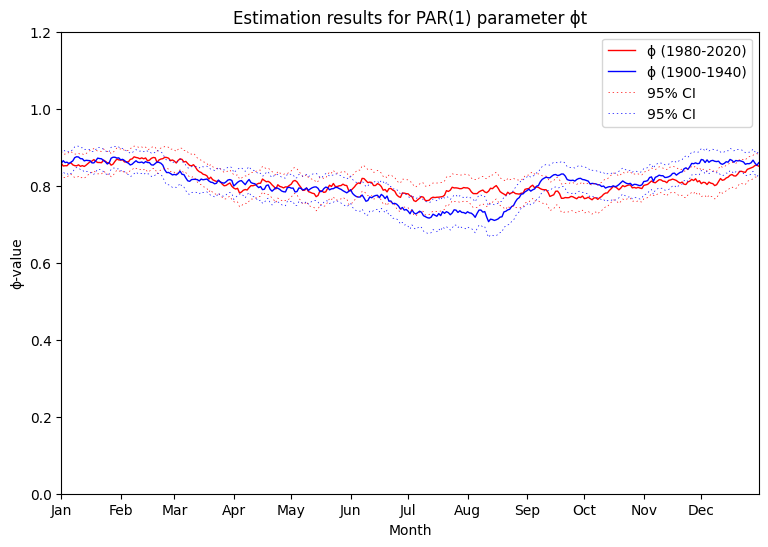

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_Wenen_1980_2020, [1980, 1900], [2020, 1940], 'Phi', 'Wenen', 'PAR(1)', df2=PAR_df_Wenen_1900_1940)

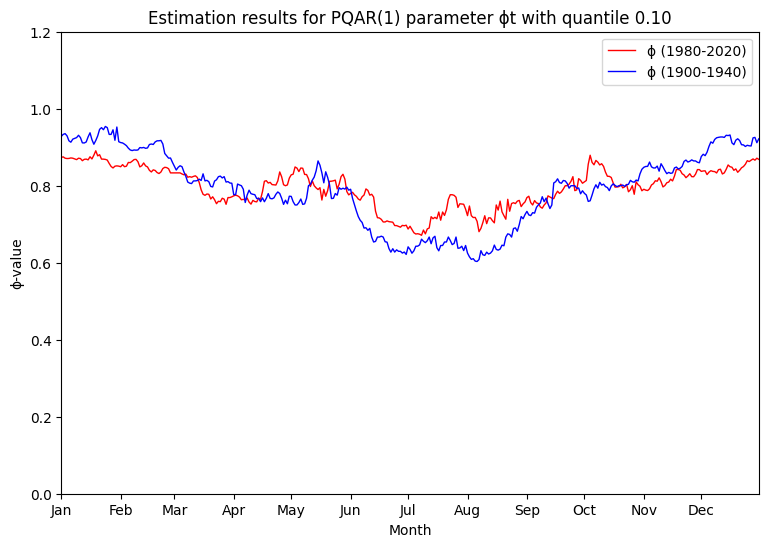

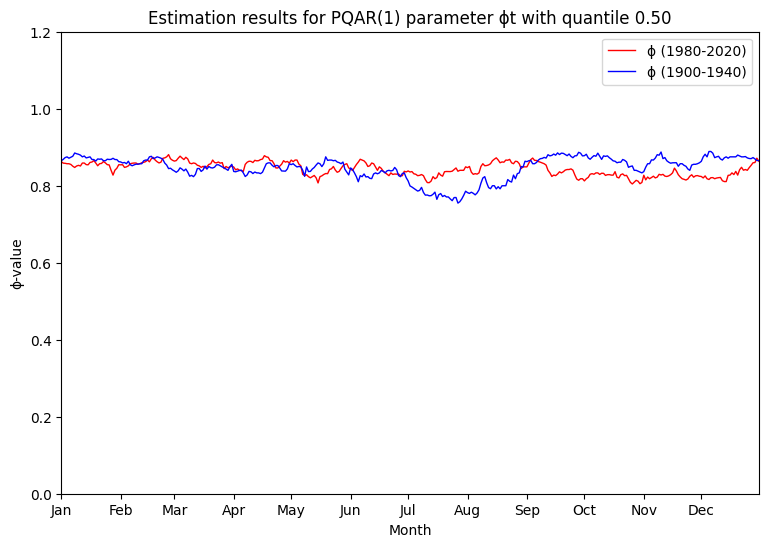

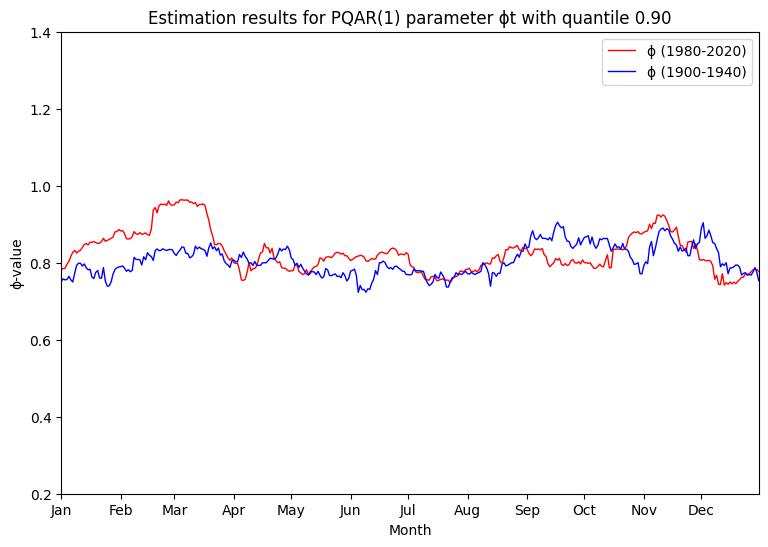

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Wenen_1980_2020_low, [1980, 1900], [2020, 1940], 'Phi', 'Wenen', 'PQAR(1)', q='0.10', df2=PQAR_df_Wenen_1900_1940_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Wenen_1980_2020_mean, [1980, 1900], [2020, 1940], 'Phi', 'Wenen', 'PQAR(1)', q='0.50', df2=PQAR_df_Wenen_1900_1940_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Wenen_1980_2020_high, [1980, 1900], [2020, 1940], 'Phi', 'Wenen', 'PQAR(1)', q='0.90', df2=PQAR_df_Wenen_1900_1940_high)

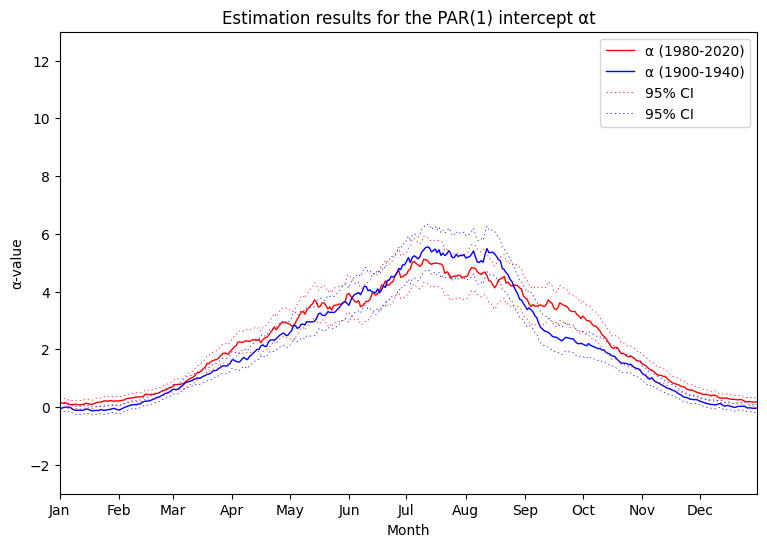

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Wenen_1980_2020, [1980, 1900], [2020, 1940], 'Alpha', 'Wenen', 'PAR(1)', df2=PAR_df_Wenen_1900_1940)

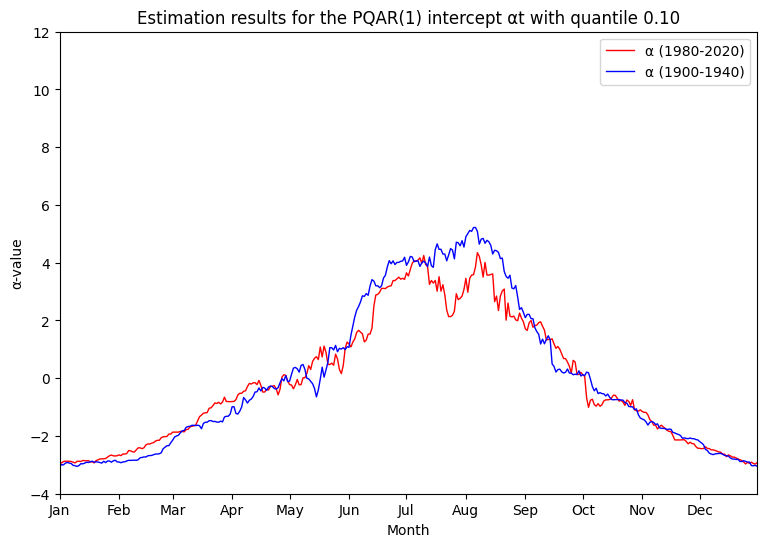

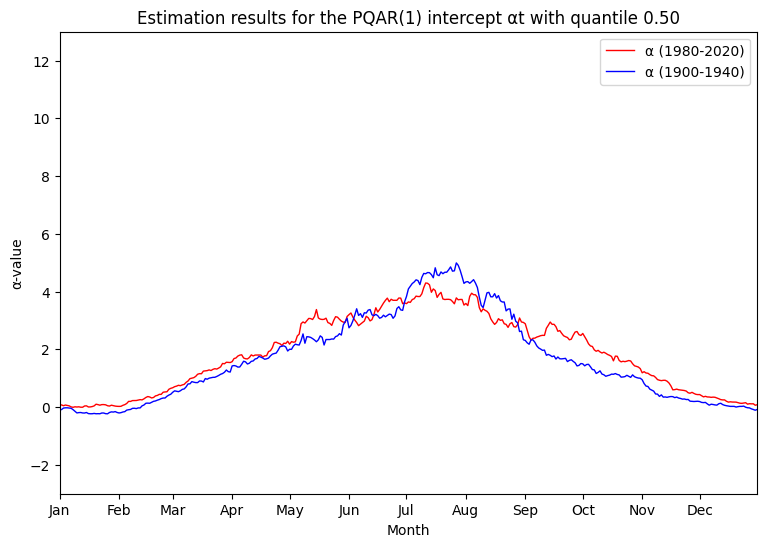

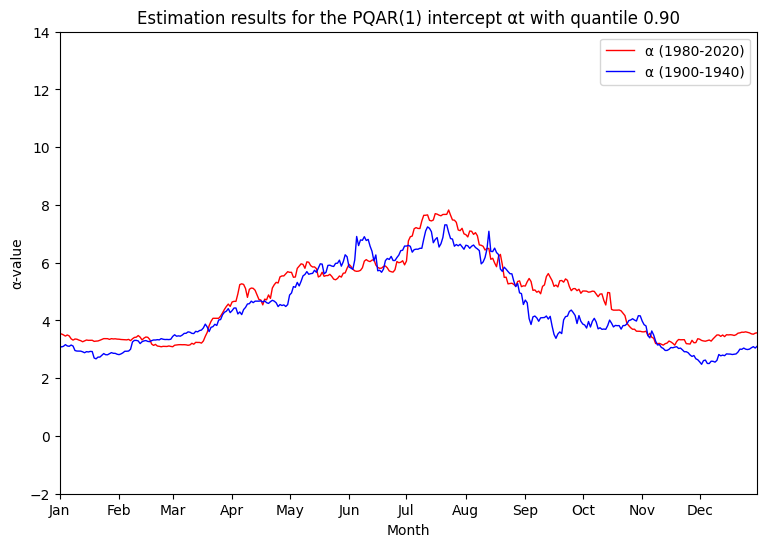

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Wenen_1980_2020_low, [1980, 1900], [2020, 1940], 'Alpha', 'Wenen', 'PQAR(1)', q='0.10', df2=PQAR_df_Wenen_1900_1940_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Wenen_1980_2020_mean, [1980, 1900], [2020, 1940], 'Alpha', 'Wenen', 'PQAR(1)', q='0.50', df2=PQAR_df_Wenen_1900_1940_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Wenen_1980_2020_high, [1980, 1900], [2020, 1940], 'Alpha', 'Wenen', 'PQAR(1)', q='0.90', df2=PQAR_df_Wenen_1900_1940_high)

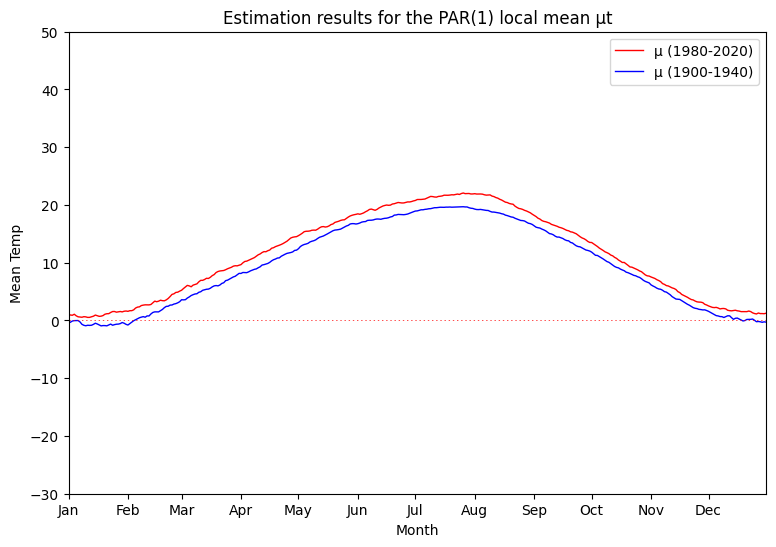

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Wenen_1980_2020, [1980, 1900], [2020, 1940], 'Mu', 'Wenen', 'PAR(1)', df2=PAR_df_Wenen_1900_1940)

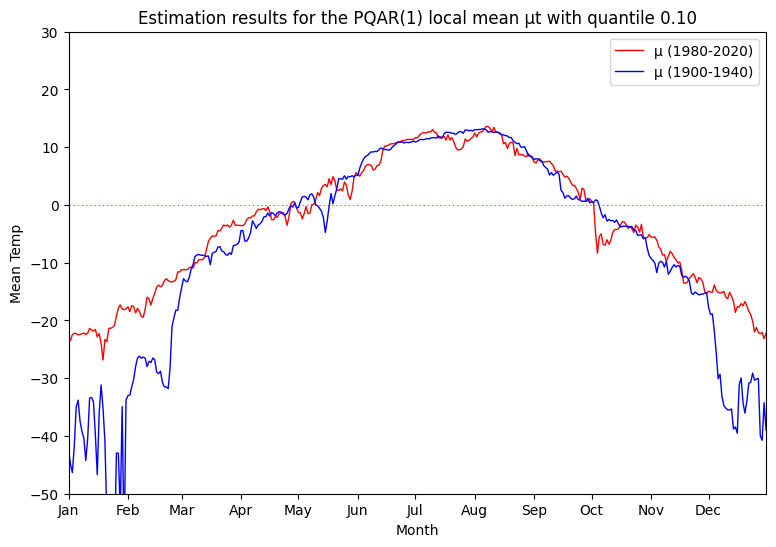

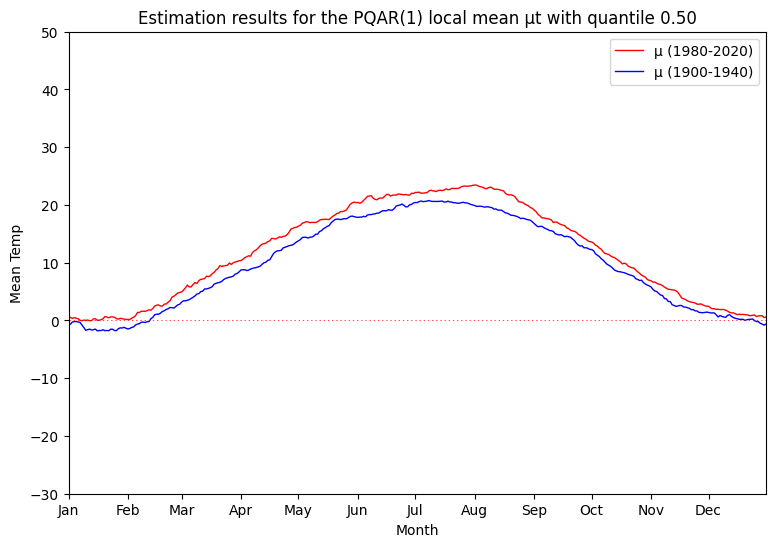

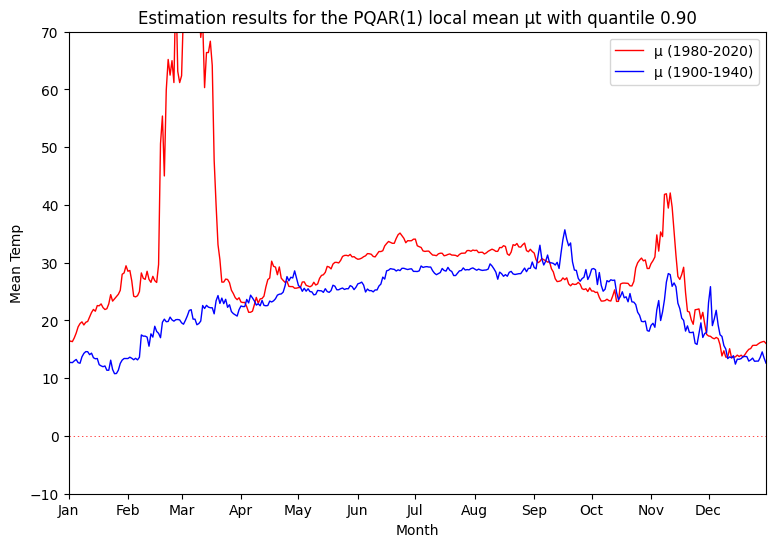

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Wenen_1980_2020_low, [1980, 1900], [2020, 1940], 'Mu', 'Wenen', 'PQAR(1)', q='0.10', df2=PQAR_df_Wenen_1900_1940_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Wenen_1980_2020_mean, [1980, 1900], [2020, 1940], 'Mu', 'Wenen', 'PQAR(1)', q='0.50', df2=PQAR_df_Wenen_1900_1940_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Wenen_1980_2020_high, [1980, 1900], [2020, 1940], 'Mu', 'Wenen', 'PQAR(1)', q='0.90', df2=PQAR_df_Wenen_1900_1940_high)

### Praag

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Praag_1980_2020 = estimate_PAR_params(df_Praag, 1980, 2020)
# PAR_df_Praag_1900_1940 = estimate_PAR_params(df_Praag, 1900, 1940)

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Praag_1980_2020_low = estimate_PQAR_params(df_Praag, 1980, 2020, 0.10)
# PQAR_df_Praag_1900_1940_low = estimate_PQAR_params(df_Praag, 1900, 1940, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Praag_1980_2020_mean = estimate_PQAR_params(df_Praag, 1980, 2020, 0.50)
# PQAR_df_Praag_1900_1940_mean = estimate_PQAR_params(df_Praag, 1900, 1940, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Praag_1980_2020_high = estimate_PQAR_params(df_Praag, 1980, 2020, 0.90)
# PQAR_df_Praag_1900_1940_high = estimate_PQAR_params(df_Praag, 1900, 1940, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Praag_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Praag_1980_2020.feather")
# PAR_df_Praag_1900_1940.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Praag_1900_1940.feather")

# PQAR_df_Praag_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1980_2020_low.feather")
# PQAR_df_Praag_1900_1940_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1900_1940_low.feather")

# PQAR_df_Praag_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1980_2020_mean.feather")
# PQAR_df_Praag_1900_1940_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1900_1940_mean.feather")

# PQAR_df_Praag_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1980_2020_high.feather")
# PQAR_df_Praag_1900_1940_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1900_1940_high.feather")

In [ ]:
# Read df
PAR_df_Praag_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Praag_1980_2020.feather")
PAR_df_Praag_1900_1940 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Praag_1900_1940.feather")

PQAR_df_Praag_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1980_2020_low.feather")
PQAR_df_Praag_1900_1940_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1900_1940_low.feather")

PQAR_df_Praag_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1980_2020_mean.feather")
PQAR_df_Praag_1900_1940_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1900_1940_mean.feather")

PQAR_df_Praag_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1980_2020_high.feather")
PQAR_df_Praag_1900_1940_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Praag_1900_1940_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Praag_jan = PAR_df_Praag_1980_2020['Phi'].loc[14]-PAR_df_Praag_1900_1940['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Prague for PAR(1): {Delta_Phi_PAR_Praag_jan}')

Delta_Phi_PQAR_Praag_jan_low = PQAR_df_Praag_1980_2020_low['Phi'].loc[14]-PQAR_df_Praag_1900_1940_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Prague for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Praag_jan_low}')

Delta_Phi_PQAR_Praag_jan_mean = PQAR_df_Praag_1980_2020_mean['Phi'].loc[14]-PQAR_df_Praag_1900_1940_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Prague for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Praag_jan_mean}')

Delta_Phi_PQAR_Praag_jan_high = PQAR_df_Praag_1980_2020_high['Phi'].loc[14]-PQAR_df_Praag_1900_1940_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Prague for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Praag_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Praag_jul = PAR_df_Praag_1980_2020['Phi'].loc[195]-PAR_df_Praag_1900_1940['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Prague for PAR(1): {Delta_Phi_PAR_Praag_jul}')

Delta_Phi_PQAR_Praag_jul_low = PQAR_df_Praag_1980_2020_low['Phi'].loc[195]-PQAR_df_Praag_1900_1940_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Prague for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Praag_jul_low}')

Delta_Phi_PQAR_Praag_jul_mean = PQAR_df_Praag_1980_2020_mean['Phi'].loc[195]-PQAR_df_Praag_1900_1940_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Prague for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Praag_jul_mean}')

Delta_Phi_PQAR_Praag_jul_high = PQAR_df_Praag_1980_2020_high['Phi'].loc[195]-PQAR_df_Praag_1900_1940_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Prague for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Praag_jul_high}')

Difference in Phi for January 15 in Prague for PAR(1): 0.009138284730220492
Difference in Phi for January 15 in Prague for PQAR(1) with quantile 0.10: -0.03276135696600857
Difference in Phi for January 15 in Prague for PQAR(1) with quantile 0.50: 0.001880570948207927
Difference in Phi for January 15 in Prague for PQAR(1) with quantile 0.90: 0.1008334602137757
Difference in Phi for July 15 in Prague for PAR(1): 0.032862324130889964
Difference in Phi for July 15 in Prague for PQAR(1) with quantile 0.10: 0.04045203565243427
Difference in Phi for July 15 in Prague for PQAR(1) with quantile 0.50: 0.03589114862970688
Difference in Phi for July 15 in Prague for PQAR(1) with quantile 0.90: 0.018407231146712832


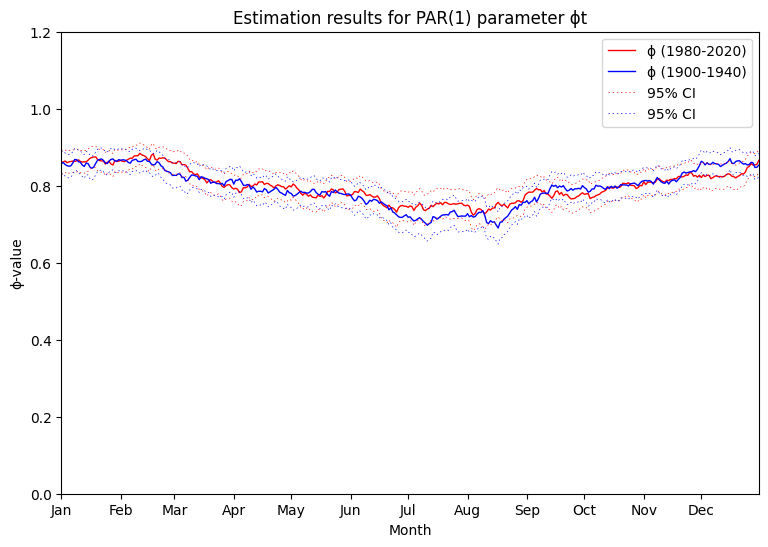

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_Praag_1980_2020, [1980, 1900], [2020, 1940], 'Phi', 'Praag', 'PAR(1)', df2=PAR_df_Praag_1900_1940)

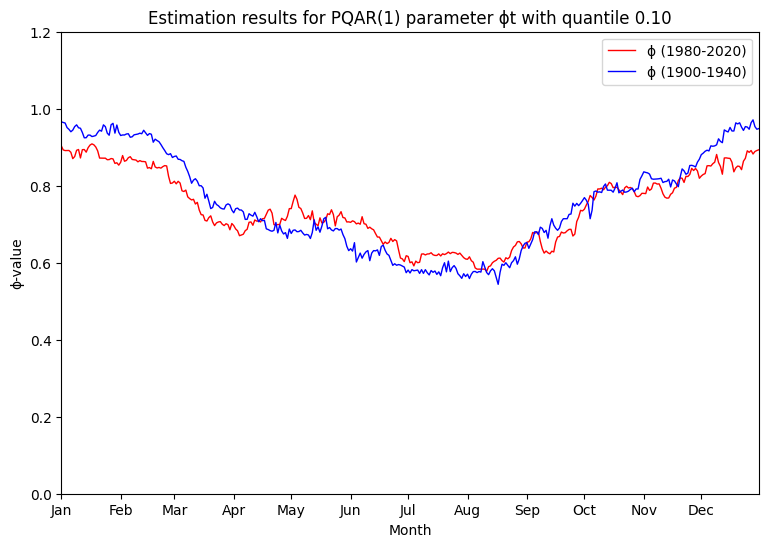

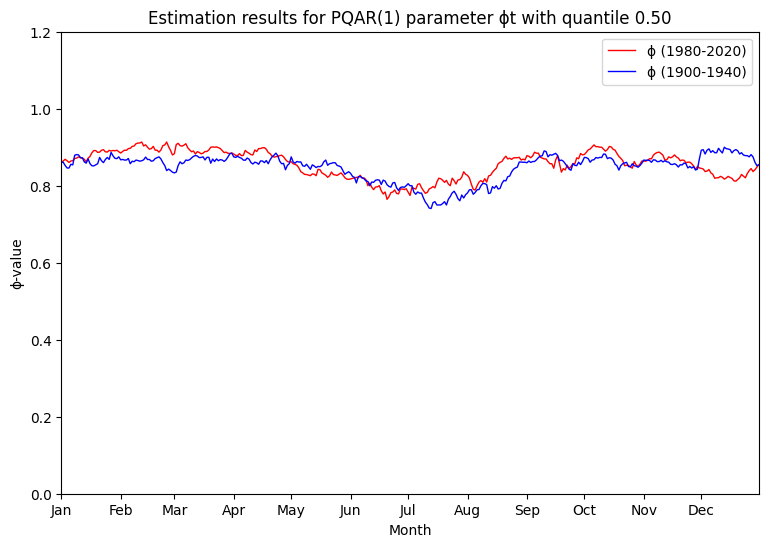

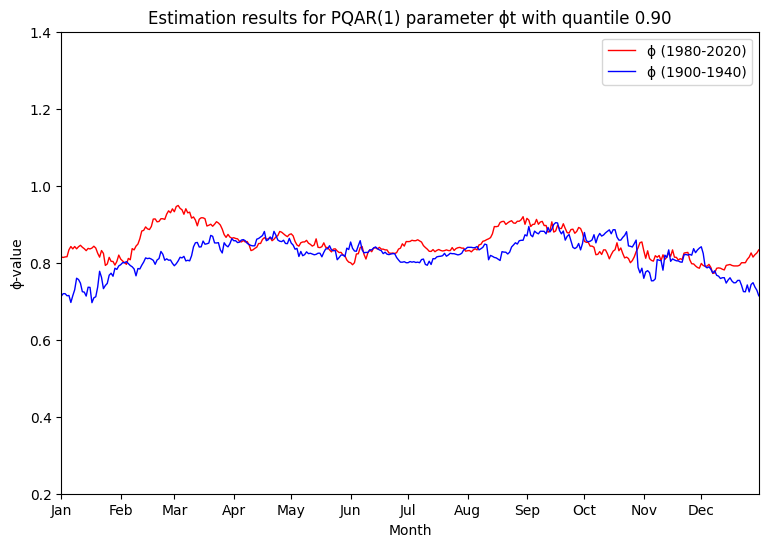

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Praag_1980_2020_low, [1980, 1900], [2020, 1940], 'Phi', 'Praag', 'PQAR(1)', q='0.10', df2=PQAR_df_Praag_1900_1940_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Praag_1980_2020_mean, [1980, 1900], [2020, 1940], 'Phi', 'Praag', 'PQAR(1)', q='0.50', df2=PQAR_df_Praag_1900_1940_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Praag_1980_2020_high, [1980, 1900], [2020, 1940], 'Phi', 'Praag', 'PQAR(1)', q='0.90', df2=PQAR_df_Praag_1900_1940_high)

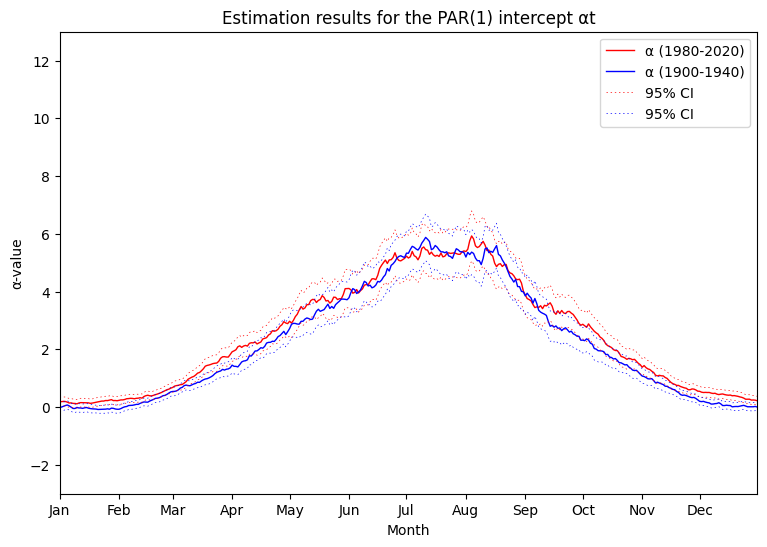

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Praag_1980_2020, [1980, 1900], [2020, 1940], 'Alpha', 'Praag', 'PAR(1)', df2=PAR_df_Praag_1900_1940)

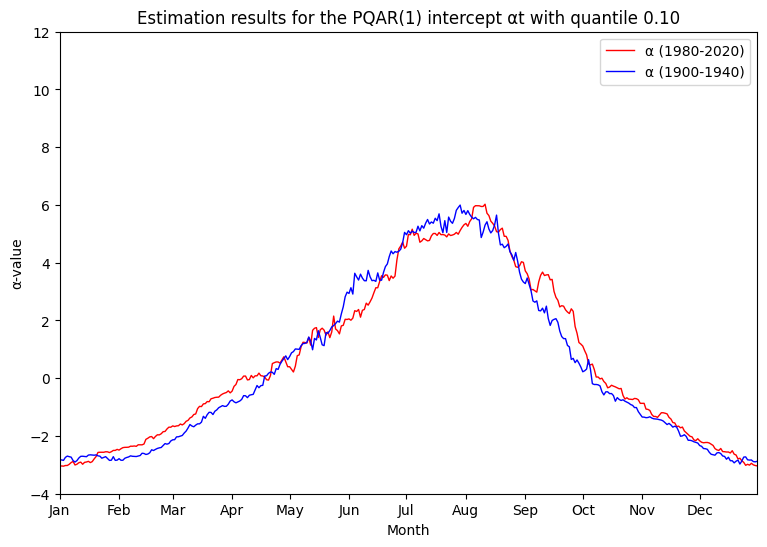

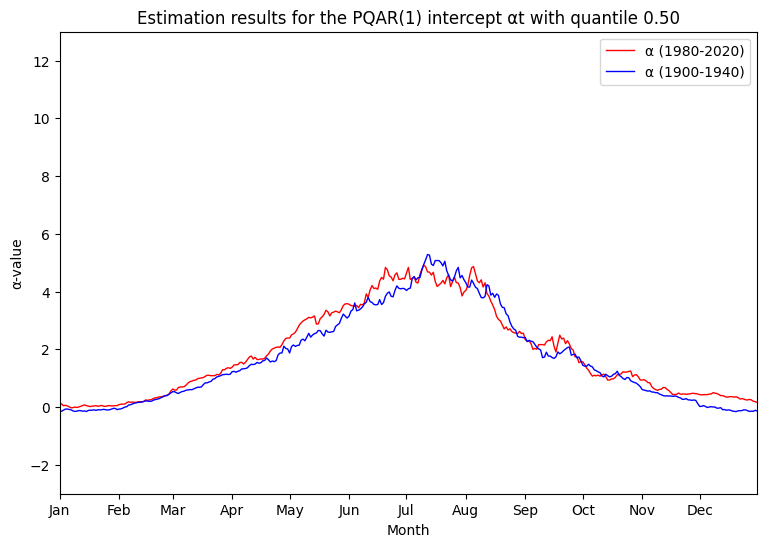

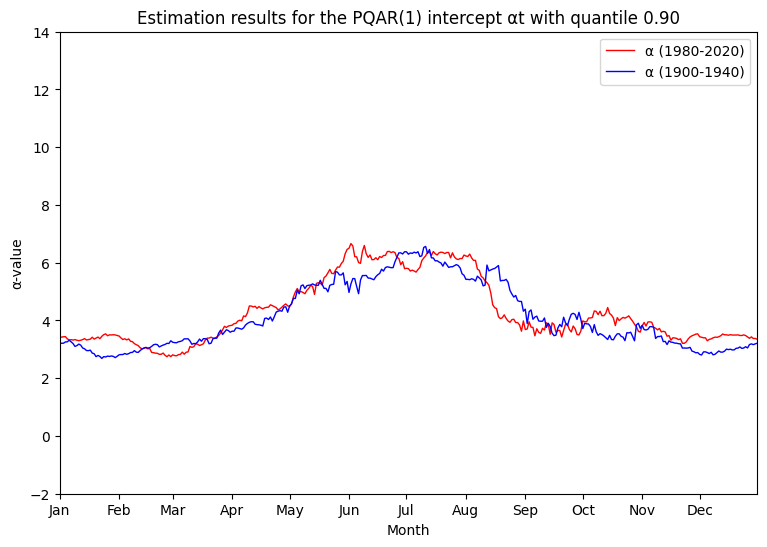

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Praag_1980_2020_low, [1980, 1900], [2020, 1940], 'Alpha', 'Praag', 'PQAR(1)', q='0.10', df2=PQAR_df_Praag_1900_1940_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Praag_1980_2020_mean, [1980, 1900], [2020, 1940], 'Alpha', 'Praag', 'PQAR(1)', q='0.50', df2=PQAR_df_Praag_1900_1940_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Praag_1980_2020_high, [1980, 1900], [2020, 1940], 'Alpha', 'Praag', 'PQAR(1)', q='0.90', df2=PQAR_df_Praag_1900_1940_high)

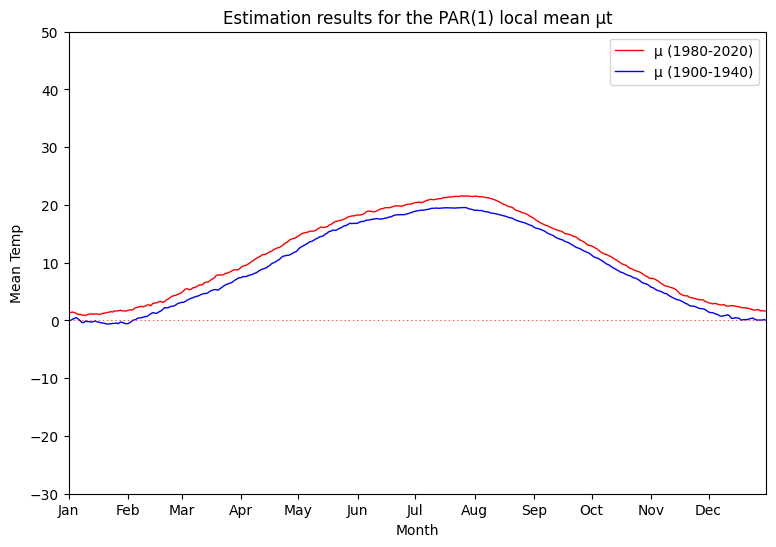

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Praag_1980_2020, [1980, 1900], [2020, 1940], 'Mu', 'Praag', 'PAR(1)', df2=PAR_df_Praag_1900_1940)

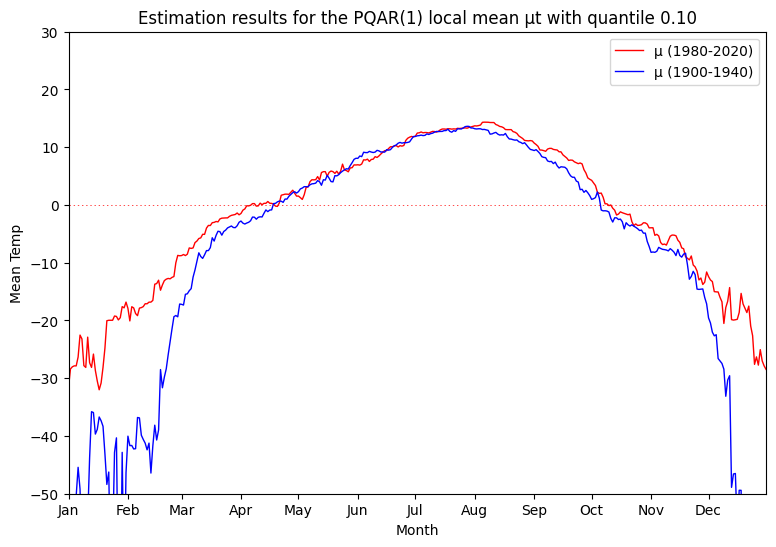

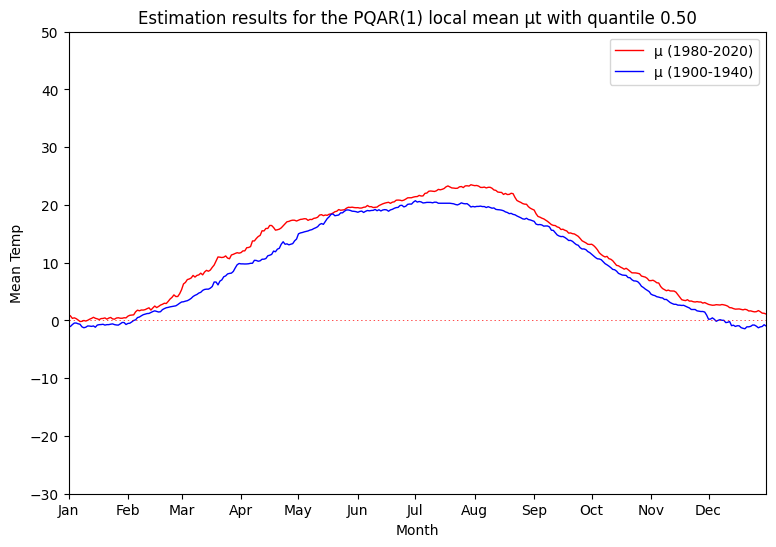

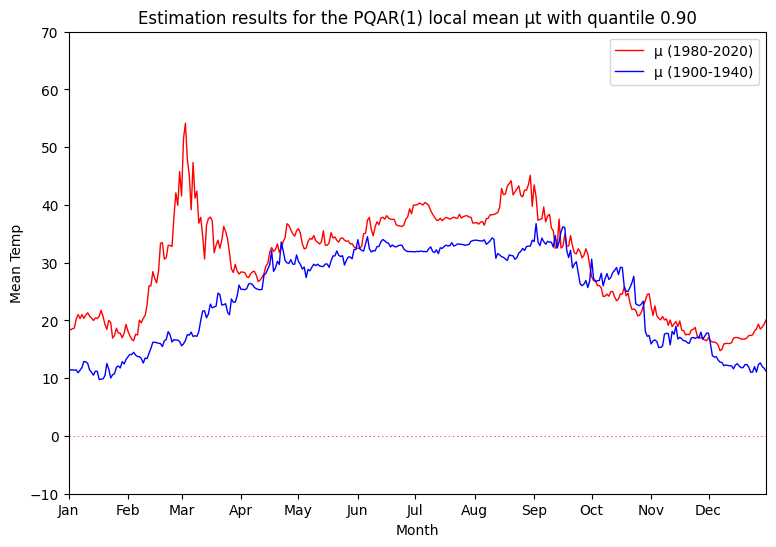

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Praag_1980_2020_low, [1980, 1900], [2020, 1940], 'Mu', 'Praag', 'PQAR(1)', q='0.10', df2=PQAR_df_Praag_1900_1940_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Praag_1980_2020_mean, [1980, 1900], [2020, 1940], 'Mu', 'Praag', 'PQAR(1)', q='0.50', df2=PQAR_df_Praag_1900_1940_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Praag_1980_2020_high, [1980, 1900], [2020, 1940], 'Mu', 'Praag', 'PQAR(1)', q='0.90', df2=PQAR_df_Praag_1900_1940_high)

### München

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Munchen_1980_2020 = estimate_PAR_params(df_Munchen, 1980, 2020)
# PAR_df_Munchen_1900_1940 = estimate_PAR_params(df_Munchen, 1900, 1940)

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Munchen_1980_2020_low = estimate_PQAR_params(df_Munchen, 1980, 2020, 0.10)
# PQAR_df_Munchen_1900_1940_low = estimate_PQAR_params(df_Munchen, 1900, 1940, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Munchen_1980_2020_mean = estimate_PQAR_params(df_Munchen, 1980, 2020, 0.50)
# PQAR_df_Munchen_1900_1940_mean = estimate_PQAR_params(df_Munchen, 1900, 1940, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Munchen_1980_2020_high = estimate_PQAR_params(df_Munchen, 1980, 2020, 0.90)
# PQAR_df_Munchen_1900_1940_high = estimate_PQAR_params(df_Munchen, 1900, 1940, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Munchen_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Munchen_1980_2020.feather")
# PAR_df_Munchen_1900_1940.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Munchen_1900_1940.feather")

# PQAR_df_Munchen_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1980_2020_low.feather")
# PQAR_df_Munchen_1900_1940_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1900_1940_low.feather")

# PQAR_df_Munchen_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1980_2020_mean.feather")
# PQAR_df_Munchen_1900_1940_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1900_1940_mean.feather")

# PQAR_df_Munchen_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1980_2020_high.feather")
# PQAR_df_Munchen_1900_1940_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1900_1940_high.feather")

In [ ]:
# Read df
PAR_df_Munchen_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Munchen_1980_2020.feather")
PAR_df_Munchen_1900_1940 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Munchen_1900_1940.feather")

PQAR_df_Munchen_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1980_2020_low.feather")
PQAR_df_Munchen_1900_1940_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1900_1940_low.feather")

PQAR_df_Munchen_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1980_2020_mean.feather")
PQAR_df_Munchen_1900_1940_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1900_1940_mean.feather")

PQAR_df_Munchen_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1980_2020_high.feather")
PQAR_df_Munchen_1900_1940_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Munchen_1900_1940_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Munchen_jan = PAR_df_Munchen_1980_2020['Phi'].loc[14]-PAR_df_Munchen_1900_1940['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Munchen for PAR(1): {Delta_Phi_PAR_Munchen_jan}')

Delta_Phi_PQAR_Munchen_jan_low = PQAR_df_Munchen_1980_2020_low['Phi'].loc[14]-PQAR_df_Munchen_1900_1940_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Munchen for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Munchen_jan_low}')

Delta_Phi_PQAR_Munchen_jan_mean = PQAR_df_Munchen_1980_2020_mean['Phi'].loc[14]-PQAR_df_Munchen_1900_1940_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Munchen for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Munchen_jan_mean}')

Delta_Phi_PQAR_Munchen_jan_high = PQAR_df_Munchen_1980_2020_high['Phi'].loc[14]-PQAR_df_Munchen_1900_1940_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Munchen for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Munchen_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Munchen_jul = PAR_df_Munchen_1980_2020['Phi'].loc[195]-PAR_df_Munchen_1900_1940['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Munchen for PAR(1): {Delta_Phi_PAR_Munchen_jul}')

Delta_Phi_PQAR_Munchen_jul_low = PQAR_df_Munchen_1980_2020_low['Phi'].loc[195]-PQAR_df_Munchen_1900_1940_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Munchen for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Munchen_jul_low}')

Delta_Phi_PQAR_Munchen_jul_mean = PQAR_df_Munchen_1980_2020_mean['Phi'].loc[195]-PQAR_df_Munchen_1900_1940_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Munchen for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Munchen_jul_mean}')

Delta_Phi_PQAR_Munchen_jul_high = PQAR_df_Munchen_1980_2020_high['Phi'].loc[195]-PQAR_df_Munchen_1900_1940_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Munchen for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Munchen_jul_high}')

Difference in Phi for January 15 in Munchen for PAR(1): 0.03629063465422222
Difference in Phi for January 15 in Munchen for PQAR(1) with quantile 0.10: -0.041657319594711306
Difference in Phi for January 15 in Munchen for PQAR(1) with quantile 0.50: 0.040499036370133856
Difference in Phi for January 15 in Munchen for PQAR(1) with quantile 0.90: 0.1146308159150855
Difference in Phi for July 15 in Munchen for PAR(1): 0.05269203762984076
Difference in Phi for July 15 in Munchen for PQAR(1) with quantile 0.10: 0.0739276461185554
Difference in Phi for July 15 in Munchen for PQAR(1) with quantile 0.50: 0.04201825306025975
Difference in Phi for July 15 in Munchen for PQAR(1) with quantile 0.90: 0.0034268431831285806


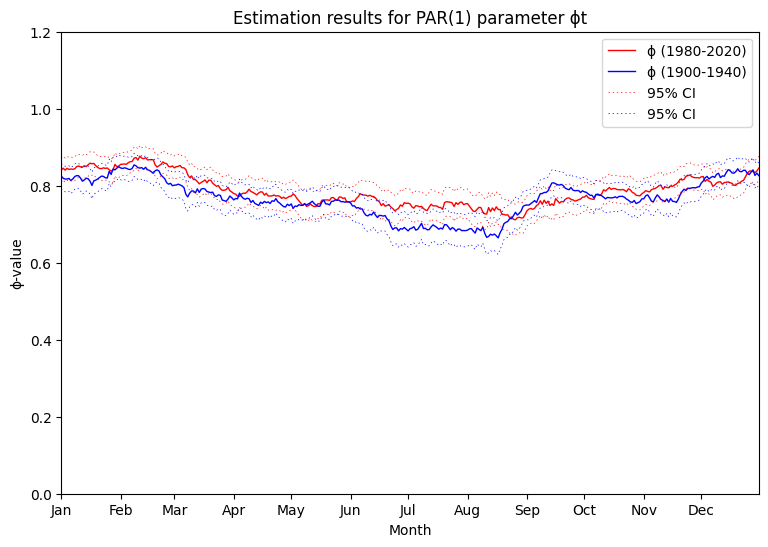

In [ ]:
# Plot the Phi pPARameter of the PAR model
plot(PAR_df_Munchen_1980_2020, [1980, 1900], [2020, 1940], 'Phi', 'Munchen', 'PAR(1)', df2=PAR_df_Munchen_1900_1940)

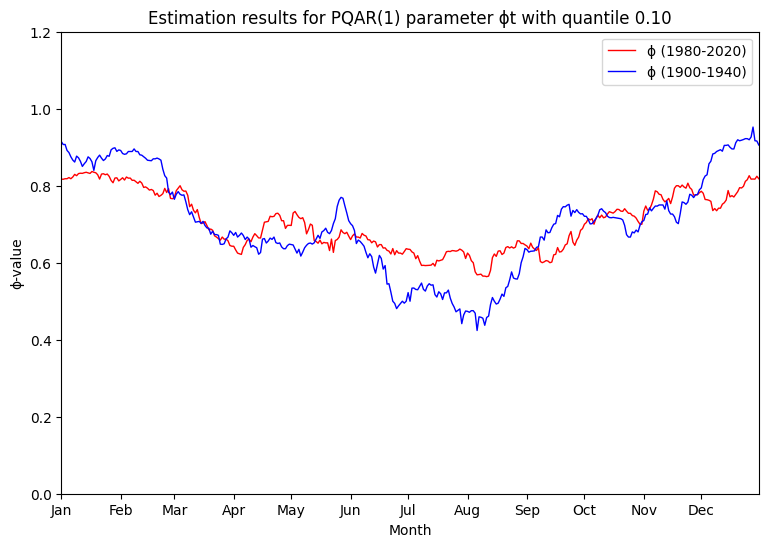

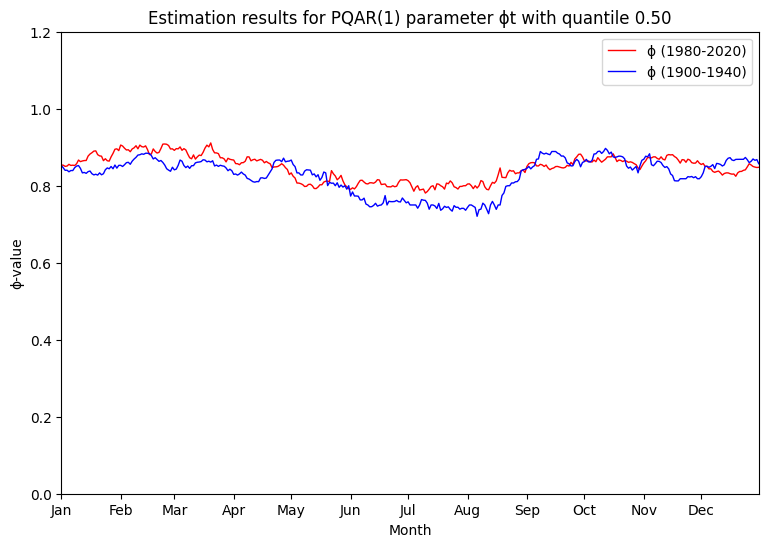

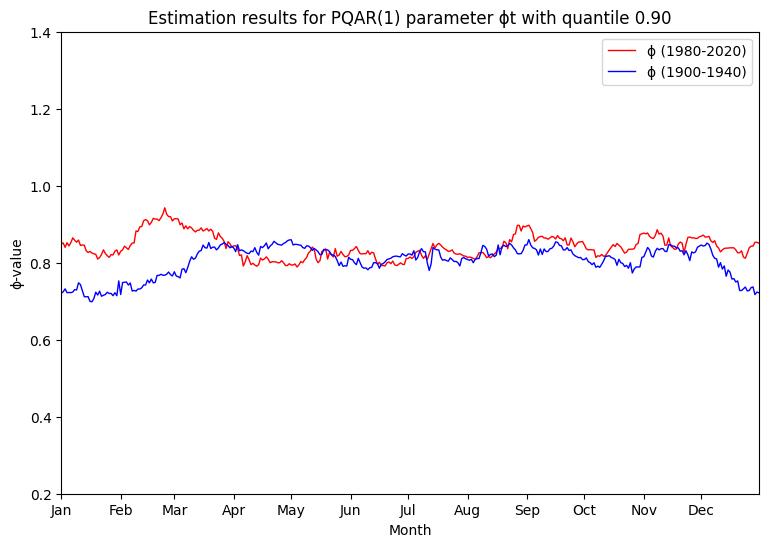

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Munchen_1980_2020_low, [1980, 1900], [2020, 1940], 'Phi', 'Munchen', 'PQAR(1)', q='0.10', df2=PQAR_df_Munchen_1900_1940_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Munchen_1980_2020_mean, [1980, 1900], [2020, 1940], 'Phi', 'Munchen', 'PQAR(1)', q='0.50', df2=PQAR_df_Munchen_1900_1940_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Munchen_1980_2020_high, [1980, 1900], [2020, 1940], 'Phi', 'Munchen', 'PQAR(1)', q='0.90', df2=PQAR_df_Munchen_1900_1940_high)

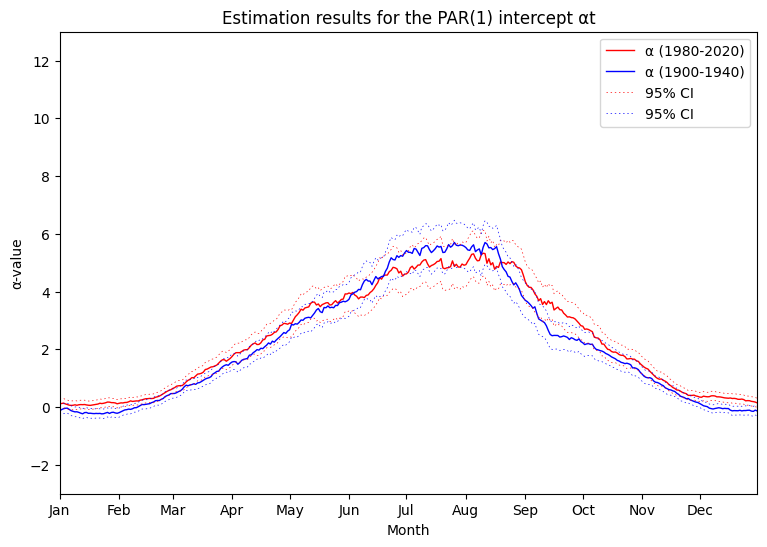

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Munchen_1980_2020, [1980, 1900], [2020, 1940], 'Alpha', 'Munchen', 'PAR(1)', df2=PAR_df_Munchen_1900_1940)

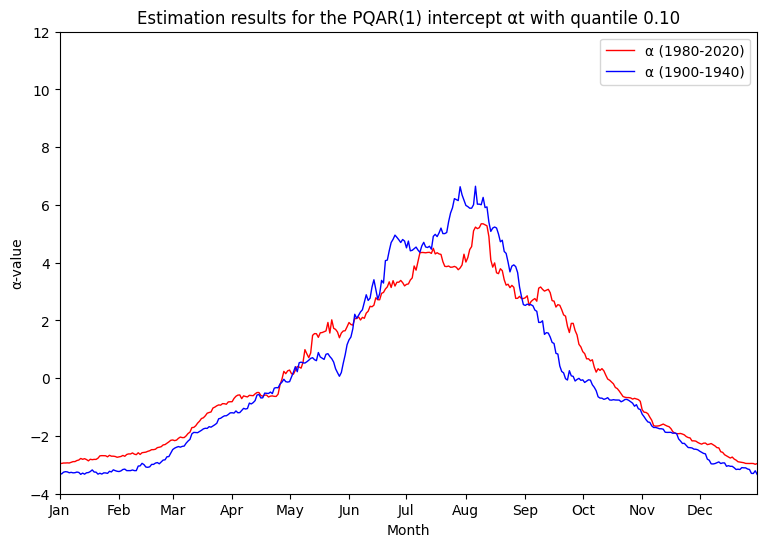

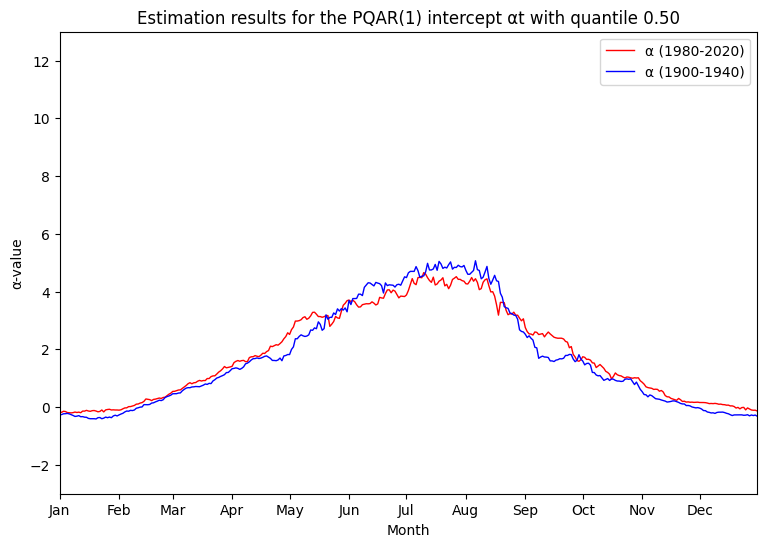

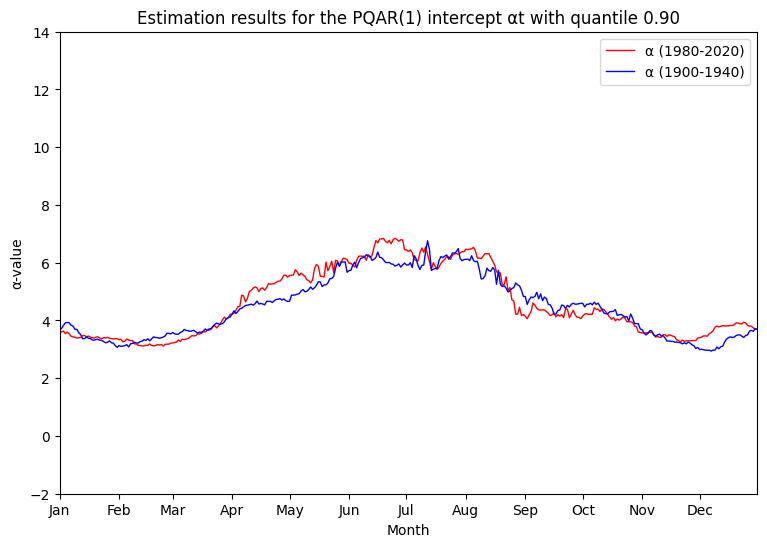

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Munchen_1980_2020_low, [1980, 1900], [2020, 1940], 'Alpha', 'Munchen', 'PQAR(1)', q='0.10', df2=PQAR_df_Munchen_1900_1940_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Munchen_1980_2020_mean, [1980, 1900], [2020, 1940], 'Alpha', 'Munchen', 'PQAR(1)', q='0.50', df2=PQAR_df_Munchen_1900_1940_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Munchen_1980_2020_high, [1980, 1900], [2020, 1940], 'Alpha', 'Munchen', 'PQAR(1)', q='0.90', df2=PQAR_df_Munchen_1900_1940_high)

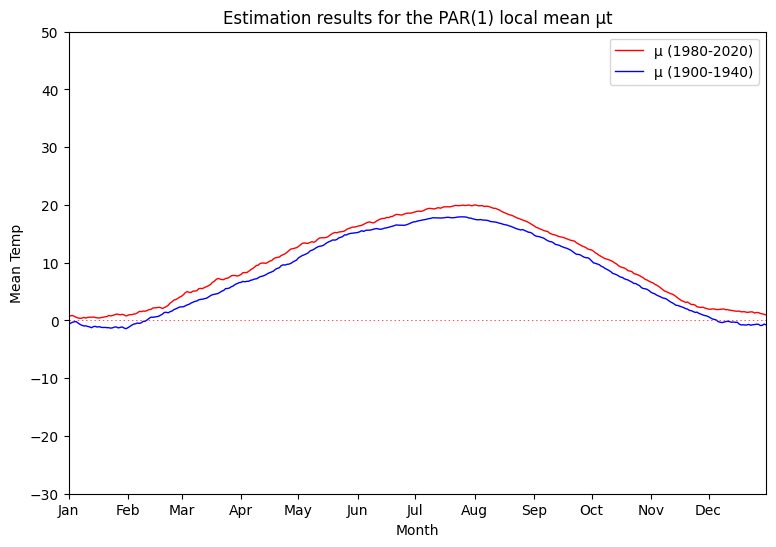

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Munchen_1980_2020, [1980, 1900], [2020, 1940], 'Mu', 'Munchen', 'PAR(1)', df2=PAR_df_Munchen_1900_1940)

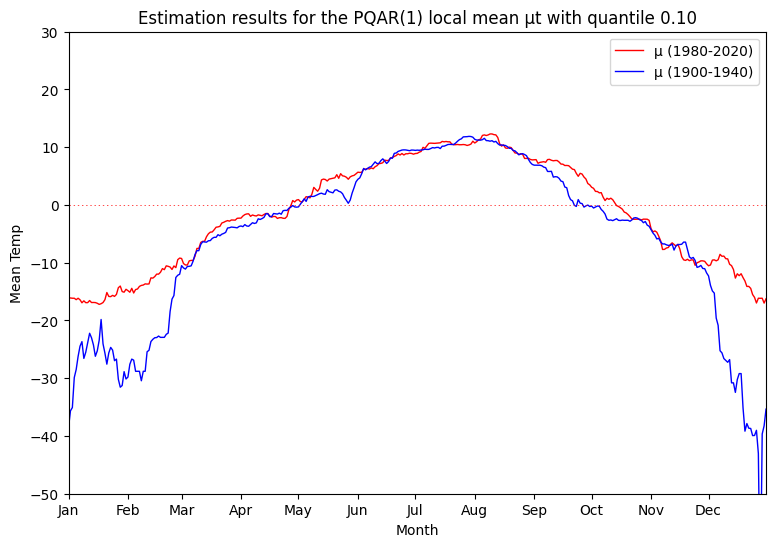

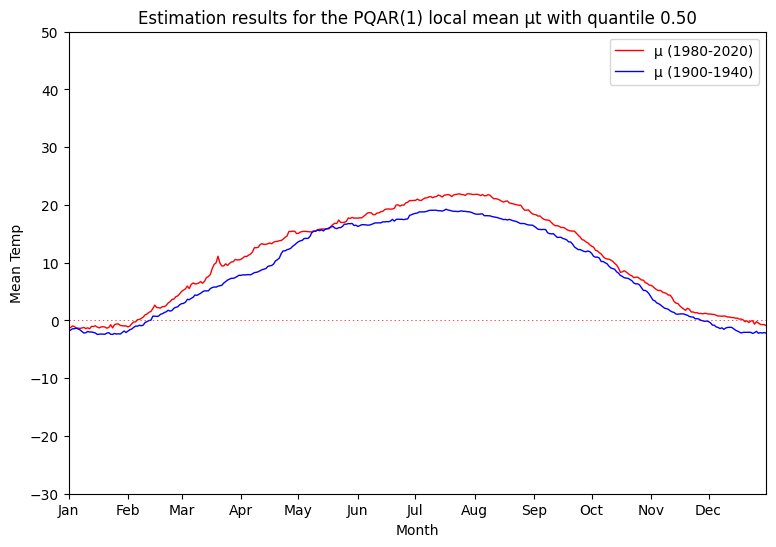

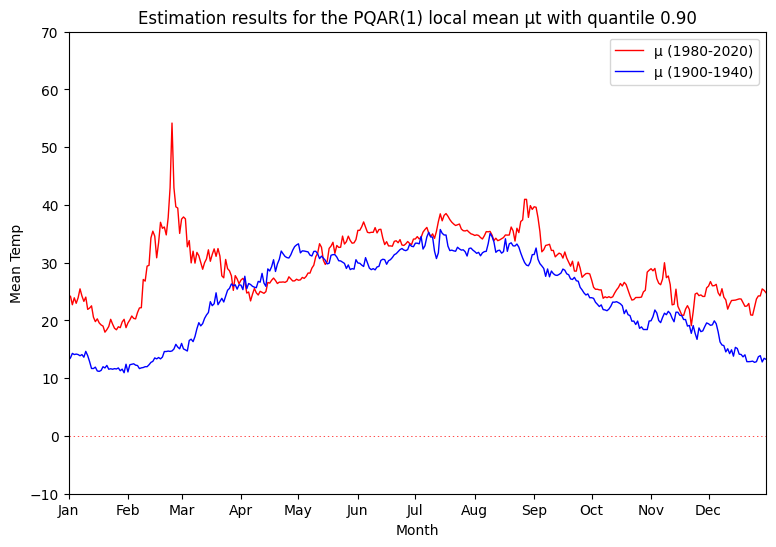

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Munchen_1980_2020_low, [1980, 1900], [2020, 1940], 'Mu', 'Munchen', 'PQAR(1)', q='0.10', df2=PQAR_df_Munchen_1900_1940_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Munchen_1980_2020_mean, [1980, 1900], [2020, 1940], 'Mu', 'Munchen', 'PQAR(1)', q='0.50', df2=PQAR_df_Munchen_1900_1940_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Munchen_1980_2020_high, [1980, 1900], [2020, 1940], 'Mu', 'Munchen', 'PQAR(1)', q='0.90', df2=PQAR_df_Munchen_1900_1940_high)

### Tortosa

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Tortosa_1980_2020 = estimate_PAR_params(df_Tortosa, 1980, 2020)
# PAR_df_Tortosa_1906_1946 = estimate_PAR_params(df_Tortosa, 1906, 1946) # dataset is from 1905

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Tortosa_1980_2020_low = estimate_PQAR_params(df_Tortosa, 1980, 2020, 0.10)
# PQAR_df_Tortosa_1906_1946_low = estimate_PQAR_params(df_Tortosa, 1906, 1946, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Tortosa_1980_2020_mean = estimate_PQAR_params(df_Tortosa, 1980, 2020, 0.50)
# PQAR_df_Tortosa_1906_1946_mean = estimate_PQAR_params(df_Tortosa, 1906, 1946, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Tortosa_1980_2020_high = estimate_PQAR_params(df_Tortosa, 1980, 2020, 0.90)
# PQAR_df_Tortosa_1906_1946_high = estimate_PQAR_params(df_Tortosa, 1906, 1946, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Tortosa_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Tortosa_1980_2020.feather")
# PAR_df_Tortosa_1906_1946.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Tortosa_1906_1946.feather")

# PQAR_df_Tortosa_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1980_2020_low.feather")
# PQAR_df_Tortosa_1906_1946_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1906_1946_low.feather")

# PQAR_df_Tortosa_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1980_2020_mean.feather")
# PQAR_df_Tortosa_1906_1946_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1906_1946_mean.feather")

# PQAR_df_Tortosa_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1980_2020_high.feather")
# PQAR_df_Tortosa_1906_1946_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1906_1946_high.feather")

In [ ]:
# Save df as feathers
PAR_df_Tortosa_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Tortosa_1980_2020.feather")
PAR_df_Tortosa_1906_1946 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Tortosa_1906_1946.feather")

PQAR_df_Tortosa_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1980_2020_low.feather")
PQAR_df_Tortosa_1906_1946_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1906_1946_low.feather")

PQAR_df_Tortosa_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1980_2020_mean.feather")
PQAR_df_Tortosa_1906_1946_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1906_1946_mean.feather")

PQAR_df_Tortosa_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1980_2020_high.feather")
PQAR_df_Tortosa_1906_1946_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Tortosa_1906_1946_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Tortosa_jan = PAR_df_Tortosa_1980_2020['Phi'].loc[14]-PAR_df_Tortosa_1906_1946['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Tortosa for PAR(1): {Delta_Phi_PAR_Tortosa_jan}')

Delta_Phi_PQAR_Tortosa_jan_low = PQAR_df_Tortosa_1980_2020_low['Phi'].loc[14]-PQAR_df_Tortosa_1906_1946_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Tortosa for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Tortosa_jan_low}')

Delta_Phi_PQAR_Tortosa_jan_mean = PQAR_df_Tortosa_1980_2020_mean['Phi'].loc[14]-PQAR_df_Tortosa_1906_1946_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Tortosa for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Tortosa_jan_mean}')

Delta_Phi_PQAR_Tortosa_jan_high = PQAR_df_Tortosa_1980_2020_high['Phi'].loc[14]-PQAR_df_Tortosa_1906_1946_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Tortosa for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Tortosa_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Tortosa_jul = PAR_df_Tortosa_1980_2020['Phi'].loc[195]-PAR_df_Tortosa_1906_1946['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Tortosa for PAR(1): {Delta_Phi_PAR_Tortosa_jul}')

Delta_Phi_PQAR_Tortosa_jul_low = PQAR_df_Tortosa_1980_2020_low['Phi'].loc[195]-PQAR_df_Tortosa_1906_1946_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Tortosa for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Tortosa_jul_low}')

Delta_Phi_PQAR_Tortosa_jul_mean = PQAR_df_Tortosa_1980_2020_mean['Phi'].loc[195]-PQAR_df_Tortosa_1906_1946_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Tortosa for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Tortosa_jul_mean}')

Delta_Phi_PQAR_Tortosa_jul_high = PQAR_df_Tortosa_1980_2020_high['Phi'].loc[195]-PQAR_df_Tortosa_1906_1946_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Tortosa for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Tortosa_jul_high}')

Difference in Phi for January 15 in Tortosa for PAR(1): 0.14814060872215296
Difference in Phi for January 15 in Tortosa for PQAR(1) with quantile 0.10: -0.0539254166498353
Difference in Phi for January 15 in Tortosa for PQAR(1) with quantile 0.50: -0.0027102014675848274
Difference in Phi for January 15 in Tortosa for PQAR(1) with quantile 0.90: 0.08445152470390471
Difference in Phi for July 15 in Tortosa for PAR(1): 0.20587000599900152
Difference in Phi for July 15 in Tortosa for PQAR(1) with quantile 0.10: -0.06042773928404577
Difference in Phi for July 15 in Tortosa for PQAR(1) with quantile 0.50: -0.09091063220256612
Difference in Phi for July 15 in Tortosa for PQAR(1) with quantile 0.90: 0.019199968545961177


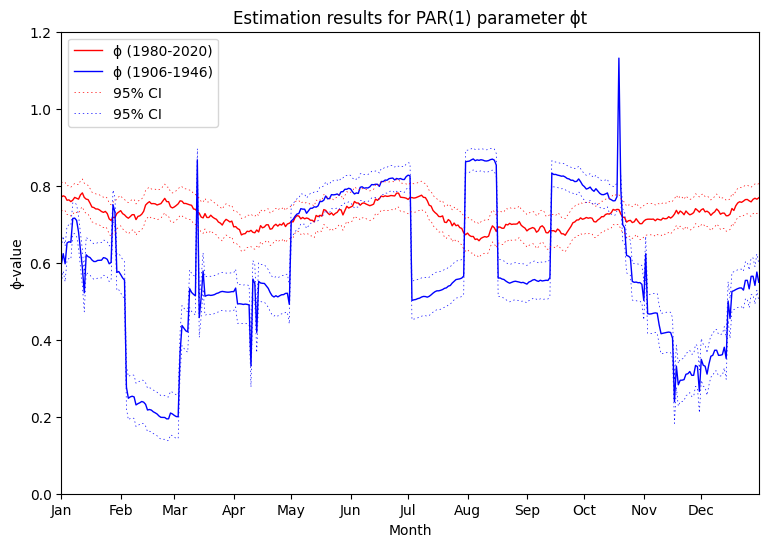

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_Tortosa_1980_2020, [1980, 1906], [2020, 1946], 'Phi', 'Tortosa', 'PAR(1)', df2=PAR_df_Tortosa_1906_1946)

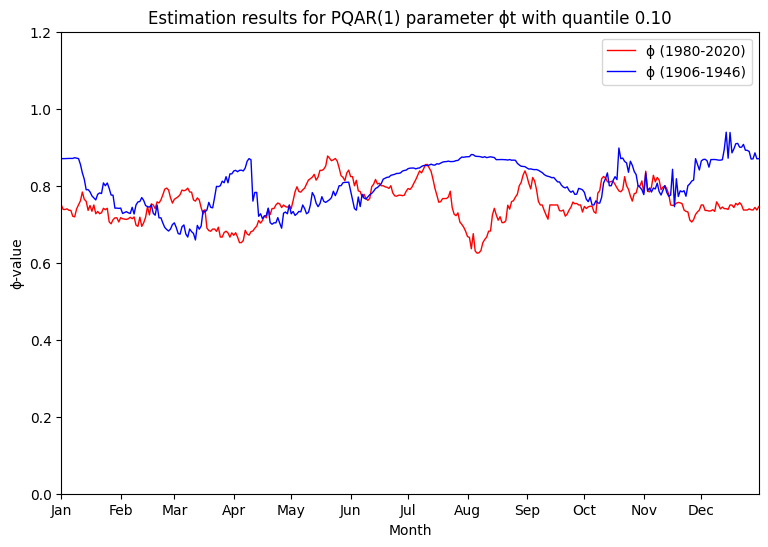

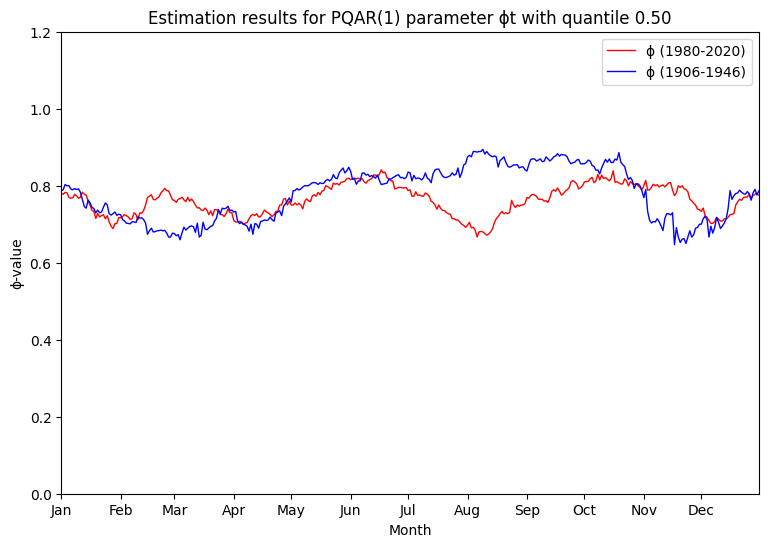

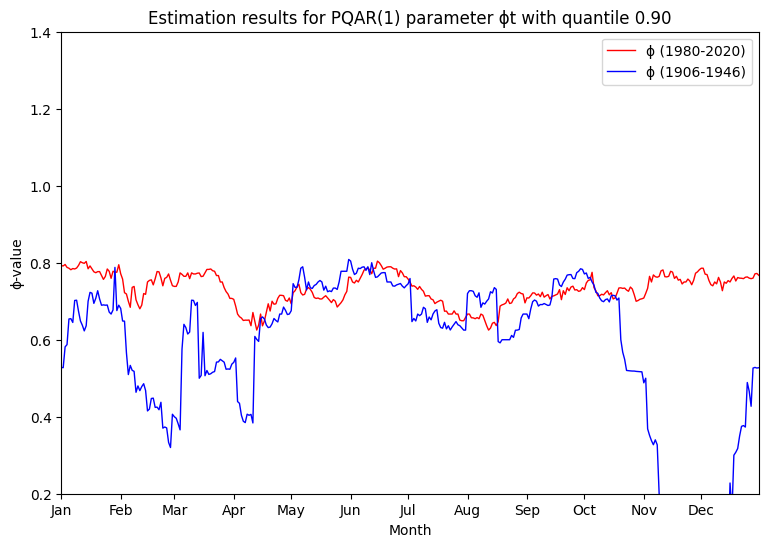

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Tortosa_1980_2020_low, [1980, 1906], [2020, 1946], 'Phi', 'Tortosa', 'PQAR(1)', q='0.10', df2=PQAR_df_Tortosa_1906_1946_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Tortosa_1980_2020_mean, [1980, 1906], [2020, 1946], 'Phi', 'Tortosa', 'PQAR(1)', q='0.50', df2=PQAR_df_Tortosa_1906_1946_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Tortosa_1980_2020_high, [1980, 1906], [2020, 1946], 'Phi', 'Tortosa', 'PQAR(1)', q='0.90', df2=PQAR_df_Tortosa_1906_1946_high)

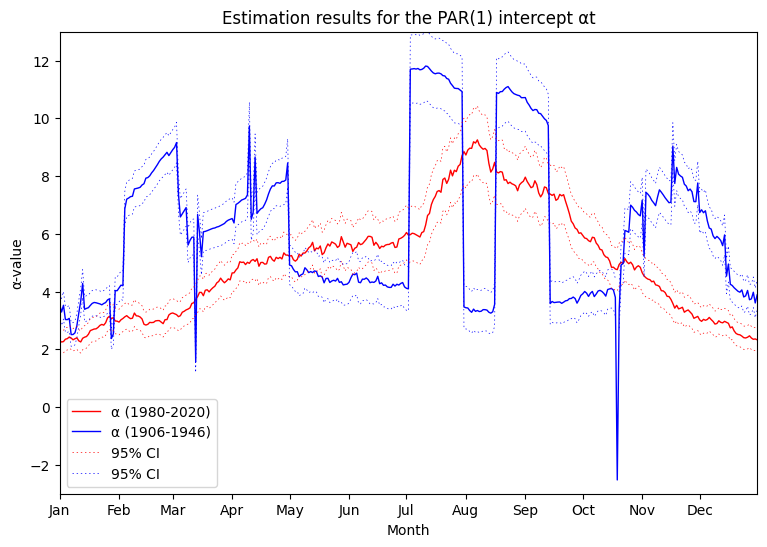

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Tortosa_1980_2020, [1980, 1906], [2020, 1946], 'Alpha', 'Tortosa', 'PAR(1)', df2=PAR_df_Tortosa_1906_1946)

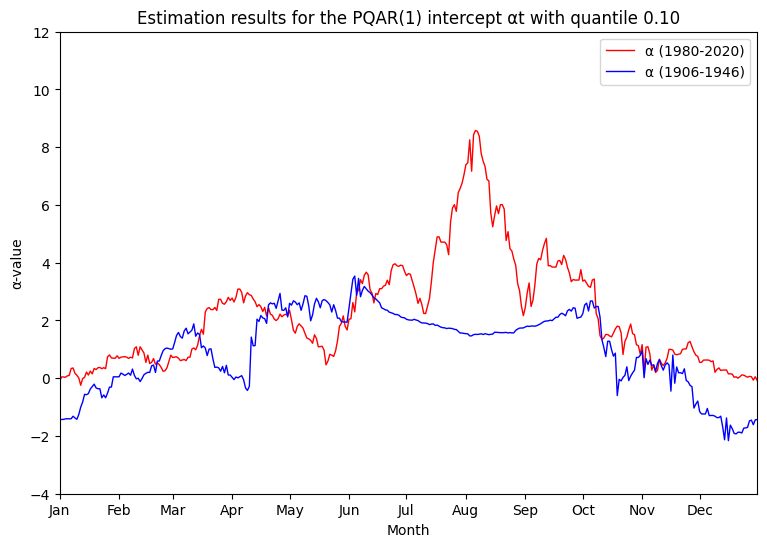

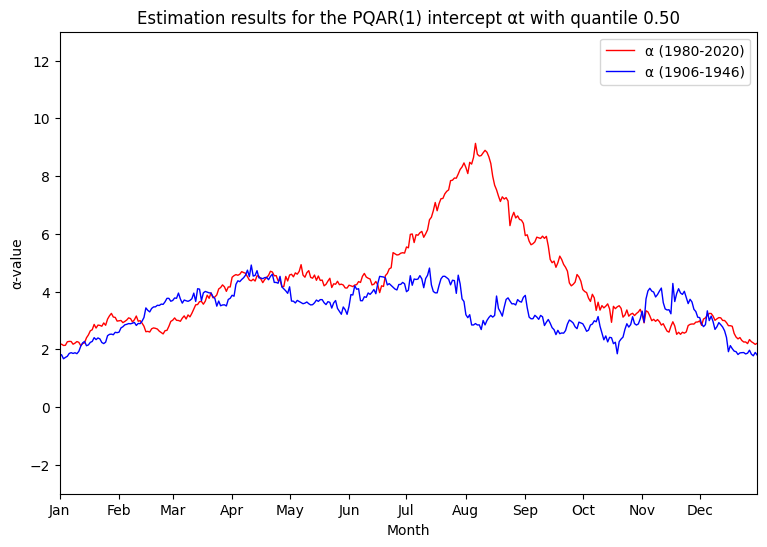

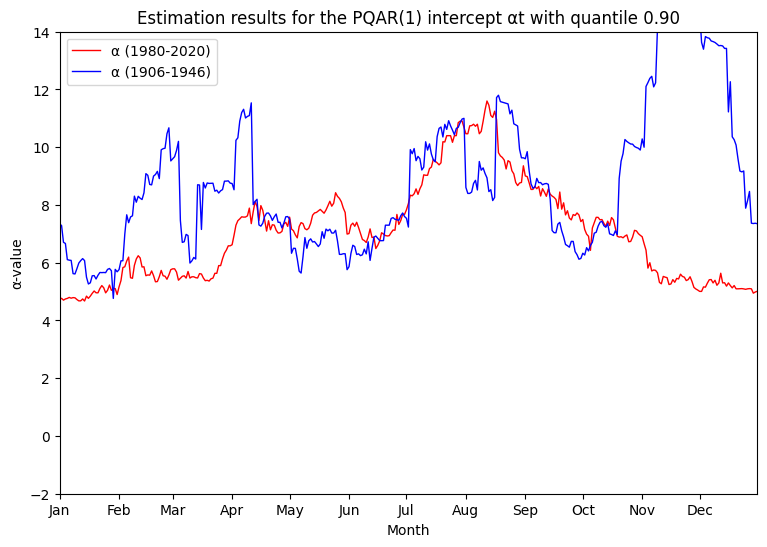

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Tortosa_1980_2020_low, [1980, 1906], [2020, 1946], 'Alpha', 'Tortosa', 'PQAR(1)', q='0.10', df2=PQAR_df_Tortosa_1906_1946_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Tortosa_1980_2020_mean, [1980, 1906], [2020, 1946], 'Alpha', 'Tortosa', 'PQAR(1)', q='0.50', df2=PQAR_df_Tortosa_1906_1946_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Tortosa_1980_2020_high, [1980, 1906], [2020, 1946], 'Alpha', 'Tortosa', 'PQAR(1)', q='0.90', df2=PQAR_df_Tortosa_1906_1946_high)

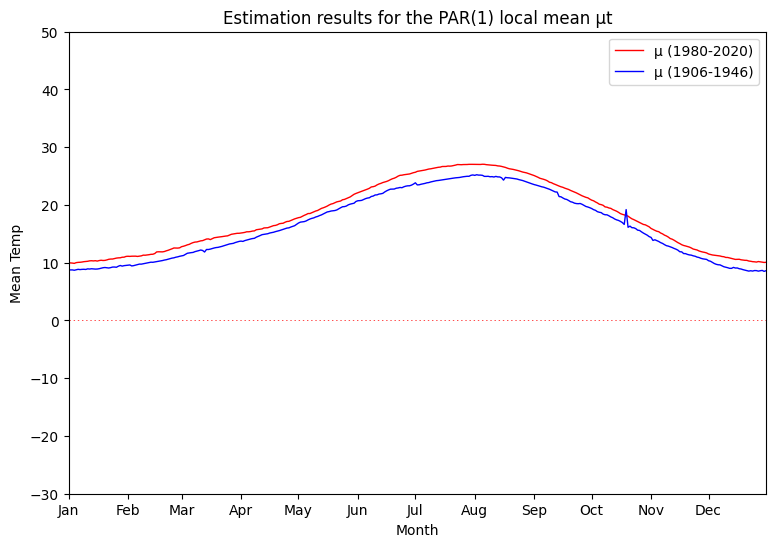

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Tortosa_1980_2020, [1980, 1906], [2020, 1946], 'Mu', 'Tortosa', 'PAR(1)', df2=PAR_df_Tortosa_1906_1946)

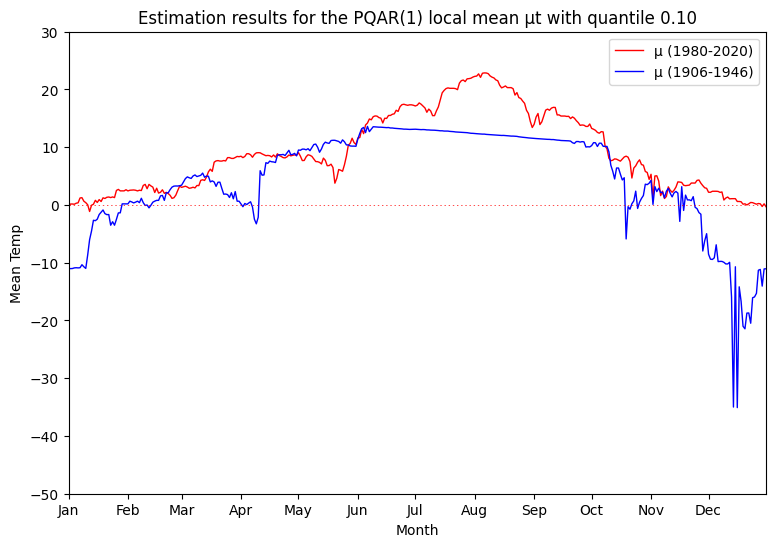

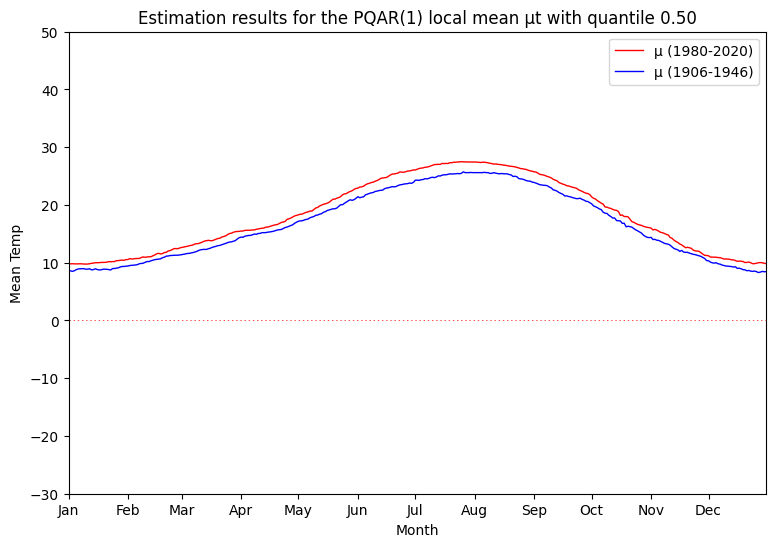

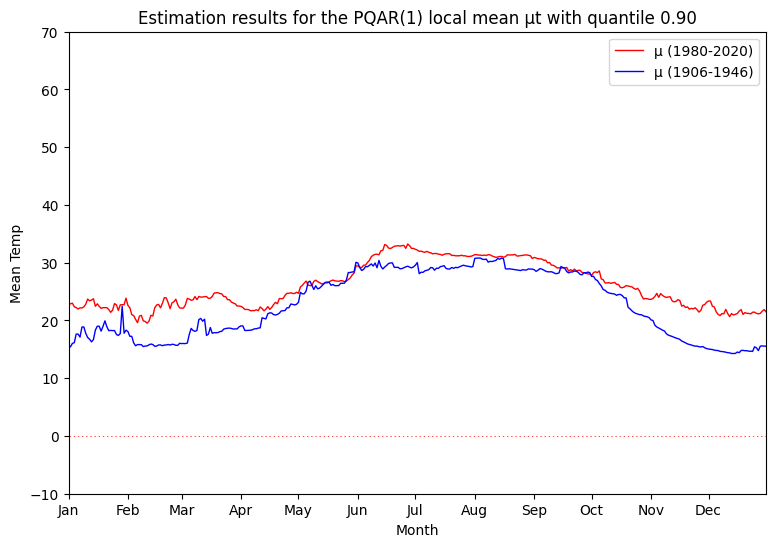

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Tortosa_1980_2020_low, [1980, 1906], [2020, 1946], 'Mu', 'Tortosa', 'PQAR(1)', q='0.10', df2=PQAR_df_Tortosa_1906_1946_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Tortosa_1980_2020_mean, [1980, 1906], [2020, 1946], 'Mu', 'Tortosa', 'PQAR(1)', q='0.50', df2=PQAR_df_Tortosa_1906_1946_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Tortosa_1980_2020_high, [1980, 1906], [2020, 1946], 'Mu', 'Tortosa', 'PQAR(1)', q='0.90', df2=PQAR_df_Tortosa_1906_1946_high)

### Bologna

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Bologna_1980_2020 = estimate_PAR_params(df_Bologna, 1980, 2020)
# PAR_df_Bologna_1900_1940 = estimate_PAR_params(df_Bologna, 1900, 1940)

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Bologna_1980_2020_low = estimate_PQAR_params(df_Bologna, 1980, 2020, 0.10)
# PQAR_df_Bologna_1900_1940_low = estimate_PQAR_params(df_Bologna, 1900, 1940, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Bologna_1980_2020_mean = estimate_PQAR_params(df_Bologna, 1980, 2020, 0.50)
# PQAR_df_Bologna_1900_1940_mean = estimate_PQAR_params(df_Bologna, 1900, 1940, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Bologna_1980_2020_high = estimate_PQAR_params(df_Bologna, 1980, 2020, 0.90)
# PQAR_df_Bologna_1900_1940_high = estimate_PQAR_params(df_Bologna, 1900, 1940, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Bologna_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bologna_1980_2020.feather")
# PAR_df_Bologna_1900_1940.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bologna_1900_1940.feather")

# PQAR_df_Bologna_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1980_2020_low.feather")
# PQAR_df_Bologna_1900_1940_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1900_1940_low.feather")

# PQAR_df_Bologna_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1980_2020_mean.feather")
# PQAR_df_Bologna_1900_1940_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1900_1940_mean.feather")

# PQAR_df_Bologna_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1980_2020_high.feather")
# PQAR_df_Bologna_1900_1940_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1900_1940_high.feather")

In [ ]:
# Read df
PAR_df_Bologna_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bologna_1980_2020.feather")
PAR_df_Bologna_1900_1940 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Bologna_1900_1940.feather")

PQAR_df_Bologna_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1980_2020_low.feather")
PQAR_df_Bologna_1900_1940_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1900_1940_low.feather")

PQAR_df_Bologna_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1980_2020_mean.feather")
PQAR_df_Bologna_1900_1940_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1900_1940_mean.feather")

PQAR_df_Bologna_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1980_2020_high.feather")
PQAR_df_Bologna_1900_1940_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Bologna_1900_1940_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Bologna_jan = PAR_df_Bologna_1980_2020['Phi'].loc[14]-PAR_df_Bologna_1900_1940['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Bologna for PAR(1): {Delta_Phi_PAR_Bologna_jan}')

Delta_Phi_PQAR_Bologna_jan_low = PQAR_df_Bologna_1980_2020_low['Phi'].loc[14]-PQAR_df_Bologna_1900_1940_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Bologna for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Bologna_jan_low}')

Delta_Phi_PQAR_Bologna_jan_mean = PQAR_df_Bologna_1980_2020_mean['Phi'].loc[14]-PQAR_df_Bologna_1900_1940_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Bologna for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Bologna_jan_mean}')

Delta_Phi_PQAR_Bologna_jan_high = PQAR_df_Bologna_1980_2020_high['Phi'].loc[14]-PQAR_df_Bologna_1900_1940_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Bologna for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Bologna_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Bologna_jul = PAR_df_Bologna_1980_2020['Phi'].loc[195]-PAR_df_Bologna_1900_1940['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Bologna for PAR(1): {Delta_Phi_PAR_Bologna_jul}')

Delta_Phi_PQAR_Bologna_jul_low = PQAR_df_Bologna_1980_2020_low['Phi'].loc[195]-PQAR_df_Bologna_1900_1940_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Bologna for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Bologna_jul_low}')

Delta_Phi_PQAR_Bologna_jul_mean = PQAR_df_Bologna_1980_2020_mean['Phi'].loc[195]-PQAR_df_Bologna_1900_1940_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Bologna for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Bologna_jul_mean}')

Delta_Phi_PQAR_Bologna_jul_high = PQAR_df_Bologna_1980_2020_high['Phi'].loc[195]-PQAR_df_Bologna_1900_1940_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Bologna for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Bologna_jul_high}')

Difference in Phi for January 15 in Bologna for PAR(1): -0.04911325527081434
Difference in Phi for January 15 in Bologna for PQAR(1) with quantile 0.10: -0.07089601247697264
Difference in Phi for January 15 in Bologna for PQAR(1) with quantile 0.50: -0.028632486485903663
Difference in Phi for January 15 in Bologna for PQAR(1) with quantile 0.90: -0.05391072350621706
Difference in Phi for July 15 in Bologna for PAR(1): -0.03743657625791863
Difference in Phi for July 15 in Bologna for PQAR(1) with quantile 0.10: -0.05293654009963544
Difference in Phi for July 15 in Bologna for PQAR(1) with quantile 0.50: -0.007536173233502863
Difference in Phi for July 15 in Bologna for PQAR(1) with quantile 0.90: -0.021183189699715443


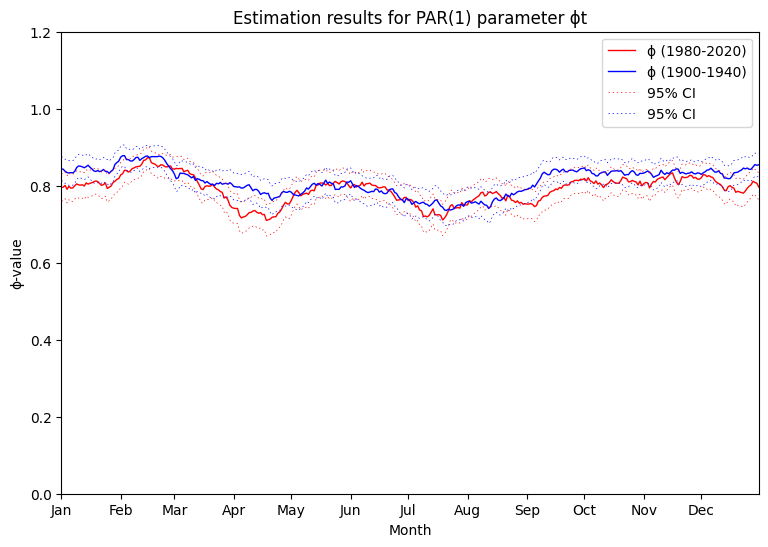

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_Bologna_1980_2020, [1980, 1900], [2020, 1940], 'Phi', 'Bologna', 'PAR(1)', df2=PAR_df_Bologna_1900_1940)

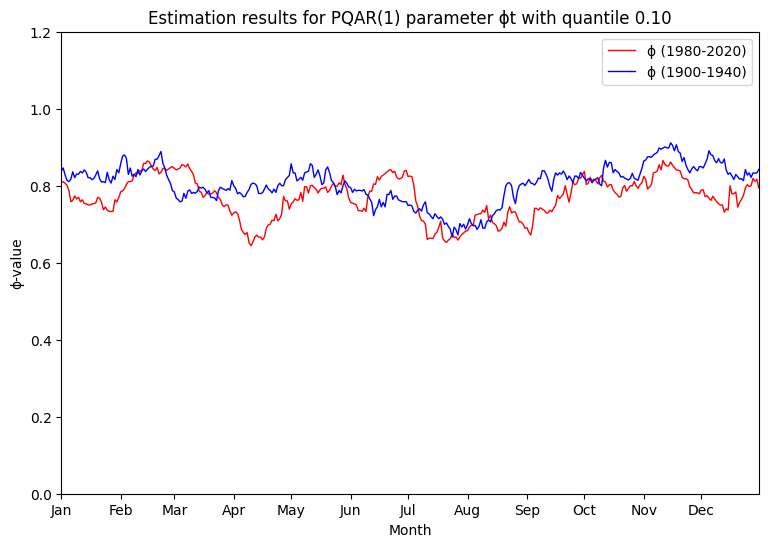

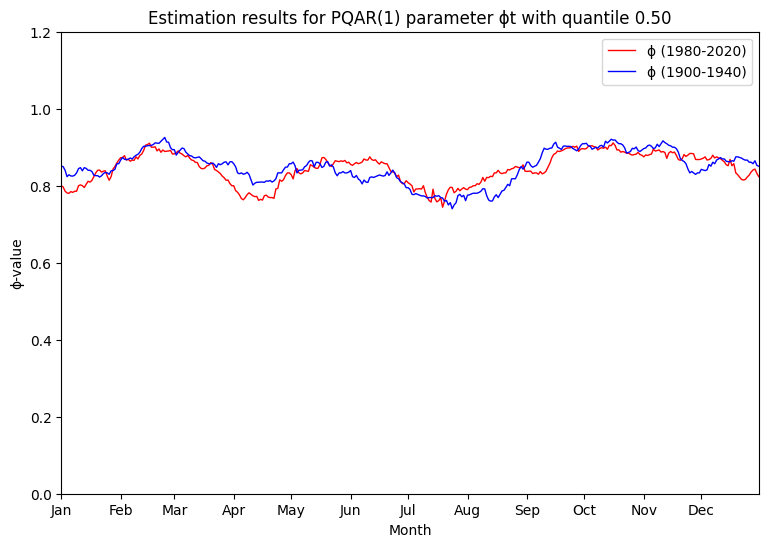

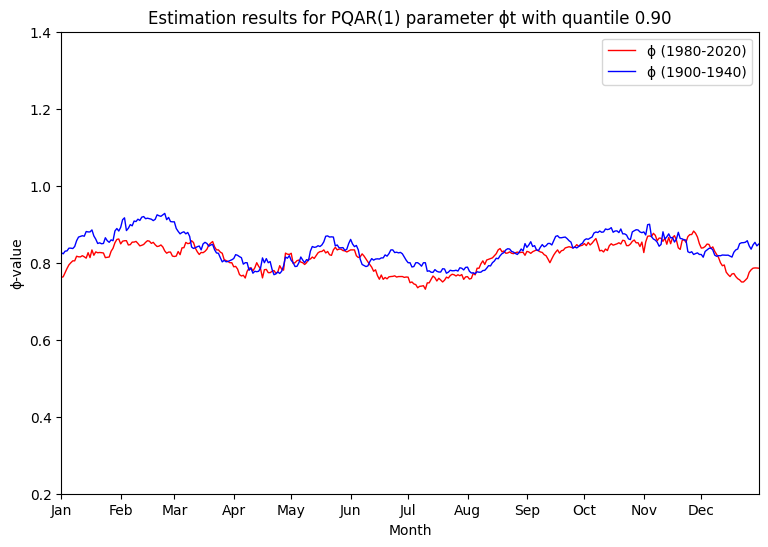

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Bologna_1980_2020_low, [1980, 1900], [2020, 1940], 'Phi', 'Bologna', 'PQAR(1)', q='0.10', df2=PQAR_df_Bologna_1900_1940_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Bologna_1980_2020_mean, [1980, 1900], [2020, 1940], 'Phi', 'Bologna', 'PQAR(1)', q='0.50', df2=PQAR_df_Bologna_1900_1940_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Bologna_1980_2020_high, [1980, 1900], [2020, 1940], 'Phi', 'Bologna', 'PQAR(1)', q='0.90', df2=PQAR_df_Bologna_1900_1940_high)

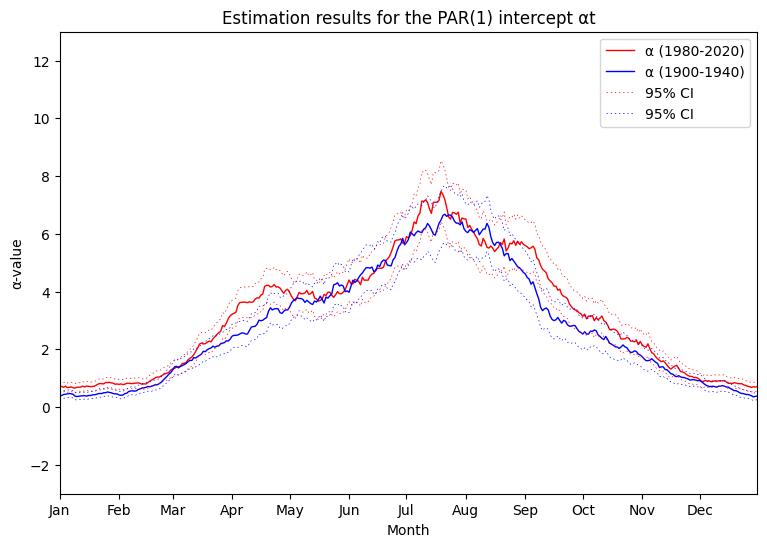

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Bologna_1980_2020, [1980, 1900], [2020, 1940], 'Alpha', 'Bologna', 'PAR(1)', df2=PAR_df_Bologna_1900_1940)

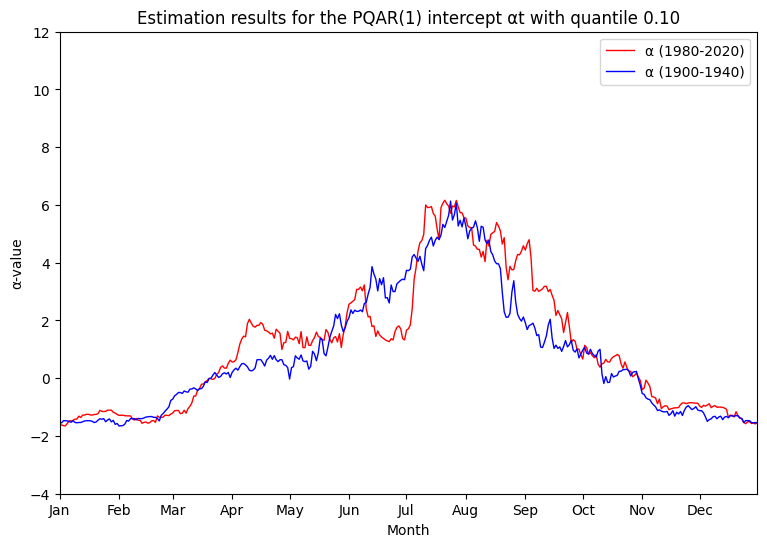

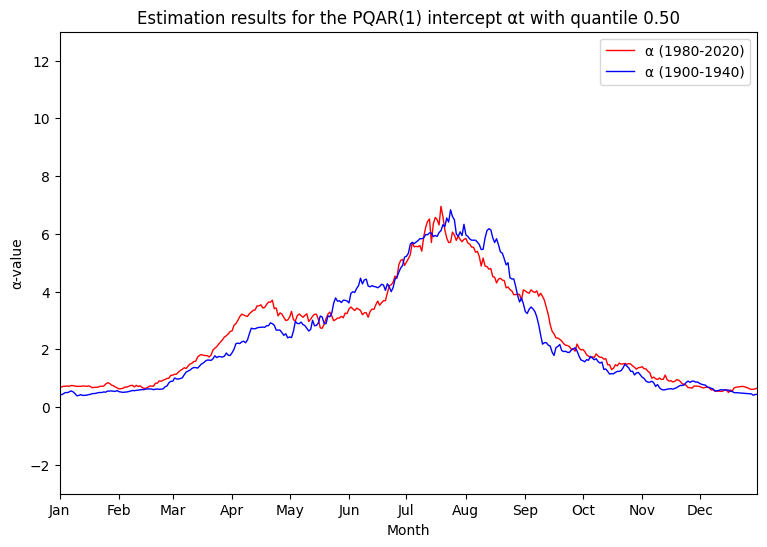

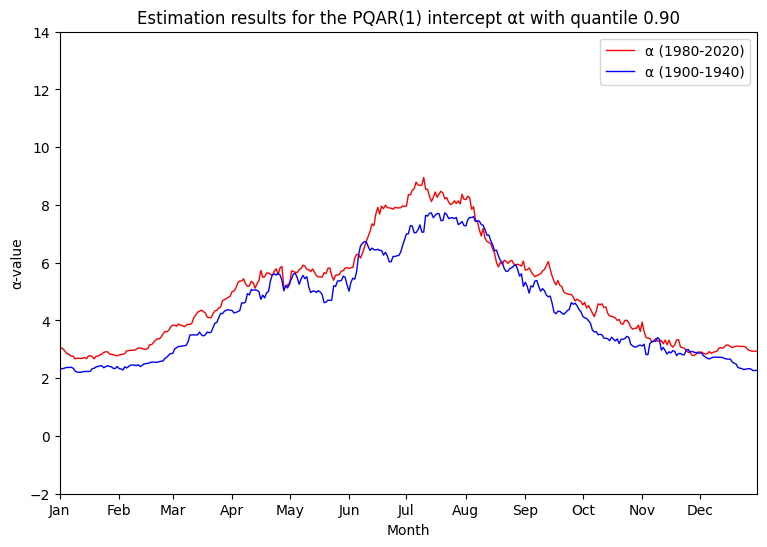

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Bologna_1980_2020_low, [1980, 1900], [2020, 1940], 'Alpha', 'Bologna', 'PQAR(1)', q='0.10', df2=PQAR_df_Bologna_1900_1940_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Bologna_1980_2020_mean, [1980, 1900], [2020, 1940], 'Alpha', 'Bologna', 'PQAR(1)', q='0.50', df2=PQAR_df_Bologna_1900_1940_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Bologna_1980_2020_high, [1980, 1900], [2020, 1940], 'Alpha', 'Bologna', 'PQAR(1)', q='0.90', df2=PQAR_df_Bologna_1900_1940_high)

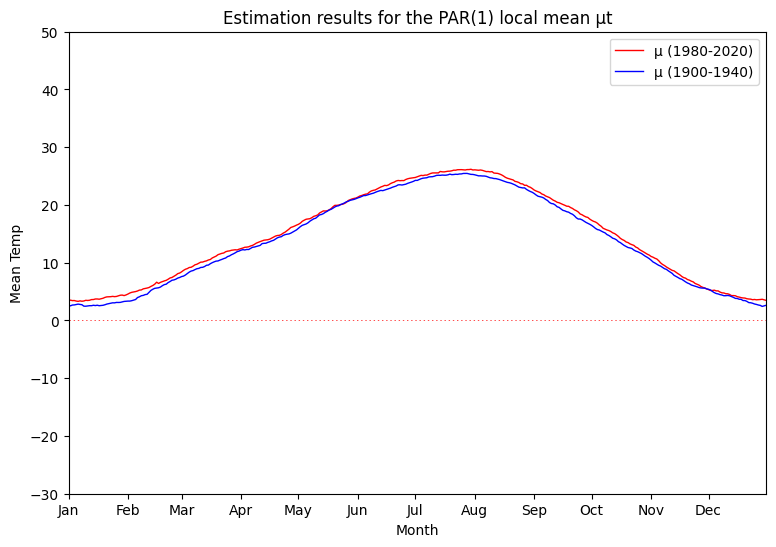

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Bologna_1980_2020, [1980, 1900], [2020, 1940], 'Mu', 'Bologna', 'PAR(1)', df2=PAR_df_Bologna_1900_1940)

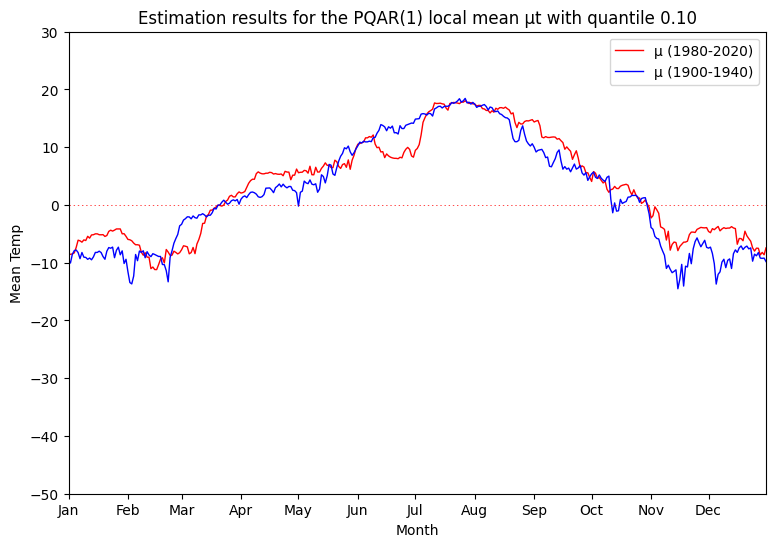

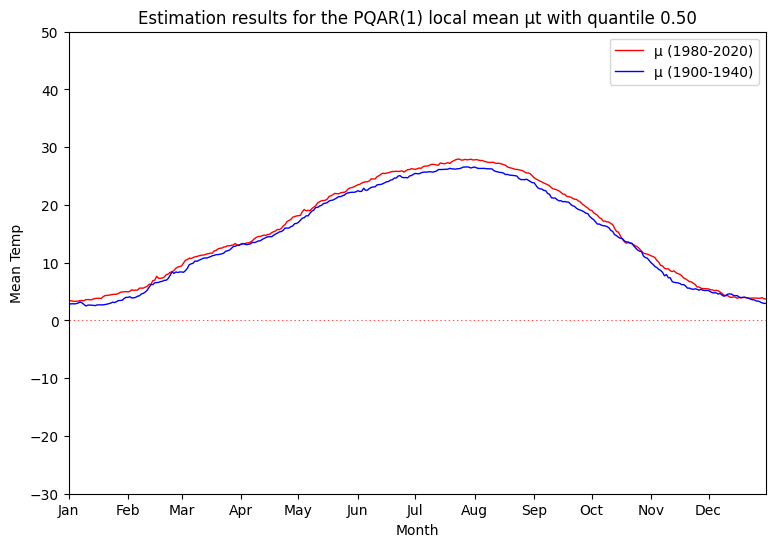

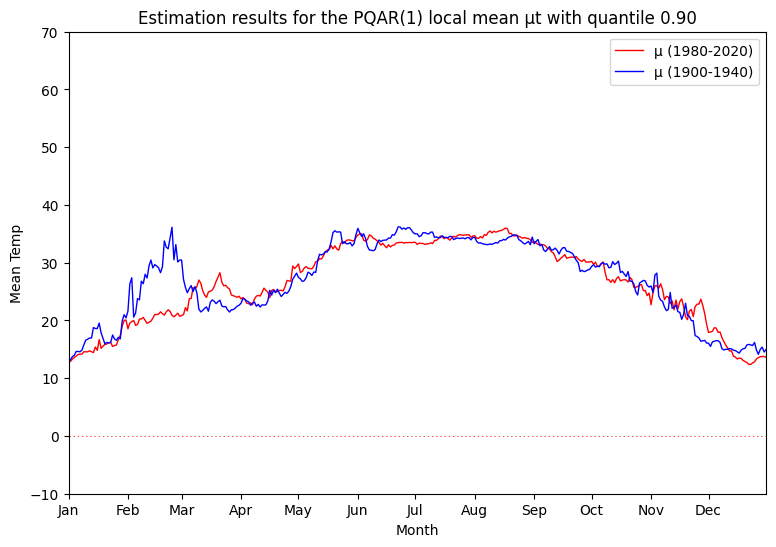

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Bologna_1980_2020_low, [1980, 1900], [2020, 1940], 'Mu', 'Bologna', 'PQAR(1)', q='0.10', df2=PQAR_df_Bologna_1900_1940_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Bologna_1980_2020_mean, [1980, 1900], [2020, 1940], 'Mu', 'Bologna', 'PQAR(1)', q='0.50', df2=PQAR_df_Bologna_1900_1940_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Bologna_1980_2020_high, [1980, 1900], [2020, 1940], 'Mu', 'Bologna', 'PQAR(1)', q='0.90', df2=PQAR_df_Bologna_1900_1940_high)

### Lissabon

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Lissabon_1980_2020 = estimate_PAR_params(df_Lissabon, 1980, 2020)
# PAR_df_Lissabon_1902_1942 = estimate_PAR_params(df_Lissabon, 1902, 1942) # dataset is from 1901

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Lissabon_1980_2020_low = estimate_PQAR_params(df_Lissabon, 1980, 2020, 0.10)
# PQAR_df_Lissabon_1902_1942_low = estimate_PQAR_params(df_Lissabon, 1902, 1942, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Lissabon_1980_2020_mean = estimate_PQAR_params(df_Lissabon, 1980, 2020, 0.50)
# PQAR_df_Lissabon_1902_1942_mean = estimate_PQAR_params(df_Lissabon, 1902, 1942, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Lissabon_1980_2020_high = estimate_PQAR_params(df_Lissabon, 1980, 2020, 0.90)
# PQAR_df_Lissabon_1902_1942_high = estimate_PQAR_params(df_Lissabon, 1902, 1942, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Lissabon_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Lissabon_1980_2020.feather")
# PAR_df_Lissabon_1902_1942.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Lissabon_1902_1942.feather")

# PQAR_df_Lissabon_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1980_2020_low.feather")
# PQAR_df_Lissabon_1902_1942_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1902_1942_low.feather")

# PQAR_df_Lissabon_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1980_2020_mean.feather")
# PQAR_df_Lissabon_1902_1942_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1902_1942_mean.feather")

# PQAR_df_Lissabon_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1980_2020_high.feather")
# PQAR_df_Lissabon_1902_1942_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1902_1942_high.feather")

In [ ]:
# Read df
PAR_df_Lissabon_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Lissabon_1980_2020.feather")
PAR_df_Lissabon_1902_1942 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Lissabon_1902_1942.feather")

PQAR_df_Lissabon_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1980_2020_low.feather")
PQAR_df_Lissabon_1902_1942_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1902_1942_low.feather")

PQAR_df_Lissabon_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1980_2020_mean.feather")
PQAR_df_Lissabon_1902_1942_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1902_1942_mean.feather")

PQAR_df_Lissabon_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1980_2020_high.feather")
PQAR_df_Lissabon_1902_1942_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Lissabon_1902_1942_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Lissabon_jan = PAR_df_Lissabon_1980_2020['Phi'].loc[14]-PAR_df_Lissabon_1902_1942['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Lissabon for PAR(1): {Delta_Phi_PAR_Lissabon_jan}')

Delta_Phi_PQAR_Lissabon_jan_low = PQAR_df_Lissabon_1980_2020_low['Phi'].loc[14]-PQAR_df_Lissabon_1902_1942_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Lissabon for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Lissabon_jan_low}')

Delta_Phi_PQAR_Lissabon_jan_mean = PQAR_df_Lissabon_1980_2020_mean['Phi'].loc[14]-PQAR_df_Lissabon_1902_1942_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Lissabon for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Lissabon_jan_mean}')

Delta_Phi_PQAR_Lissabon_jan_high = PQAR_df_Lissabon_1980_2020_high['Phi'].loc[14]-PQAR_df_Lissabon_1902_1942_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Lissabon for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Lissabon_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Lissabon_jul = PAR_df_Lissabon_1980_2020['Phi'].loc[195]-PAR_df_Lissabon_1902_1942['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Lissabon for PAR(1): {Delta_Phi_PAR_Lissabon_jul}')

Delta_Phi_PQAR_Lissabon_jul_low = PQAR_df_Lissabon_1980_2020_low['Phi'].loc[195]-PQAR_df_Lissabon_1902_1942_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Lissabon for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Lissabon_jul_low}')

Delta_Phi_PQAR_Lissabon_jul_mean = PQAR_df_Lissabon_1980_2020_mean['Phi'].loc[195]-PQAR_df_Lissabon_1902_1942_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Lissabon for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Lissabon_jul_mean}')

Delta_Phi_PQAR_Lissabon_jul_high = PQAR_df_Lissabon_1980_2020_high['Phi'].loc[195]-PQAR_df_Lissabon_1902_1942_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Lissabon for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Lissabon_jul_high}')

Difference in Phi for January 15 in Lissabon for PAR(1): 0.04549675189580438
Difference in Phi for January 15 in Lissabon for PQAR(1) with quantile 0.10: -0.011562063531957212
Difference in Phi for January 15 in Lissabon for PQAR(1) with quantile 0.50: 0.05558976989706799
Difference in Phi for January 15 in Lissabon for PQAR(1) with quantile 0.90: 0.1545426535242329
Difference in Phi for July 15 in Lissabon for PAR(1): 0.014182725839318344
Difference in Phi for July 15 in Lissabon for PQAR(1) with quantile 0.10: 0.026189841034990113
Difference in Phi for July 15 in Lissabon for PQAR(1) with quantile 0.50: 0.03280545276185143
Difference in Phi for July 15 in Lissabon for PQAR(1) with quantile 0.90: 0.05138233000502046


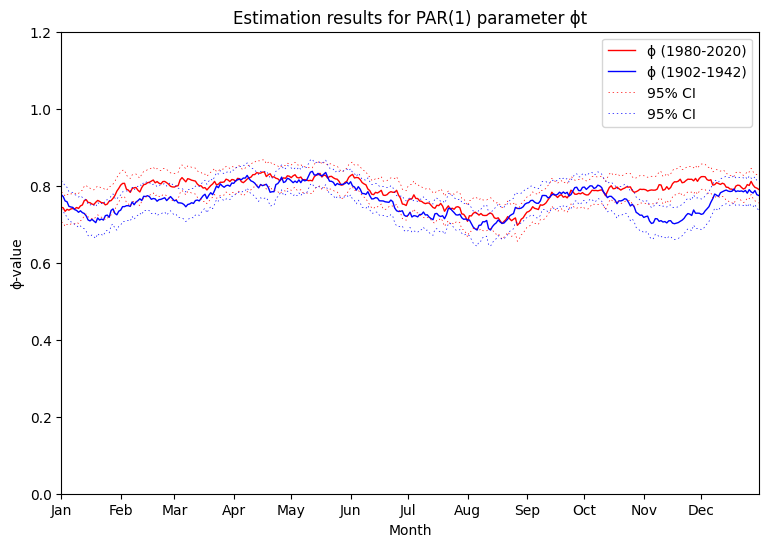

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_Lissabon_1980_2020, [1980, 1902], [2020, 1942], 'Phi', 'Lissabon', 'PAR(1)', df2=PAR_df_Lissabon_1902_1942)

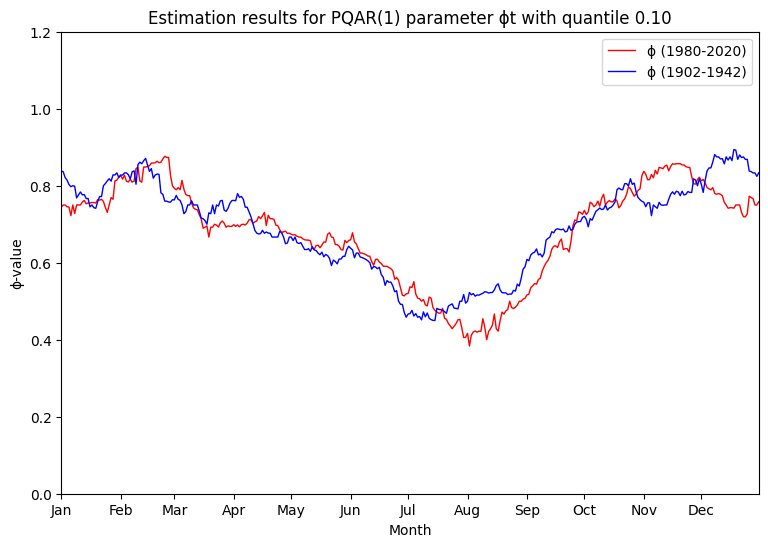

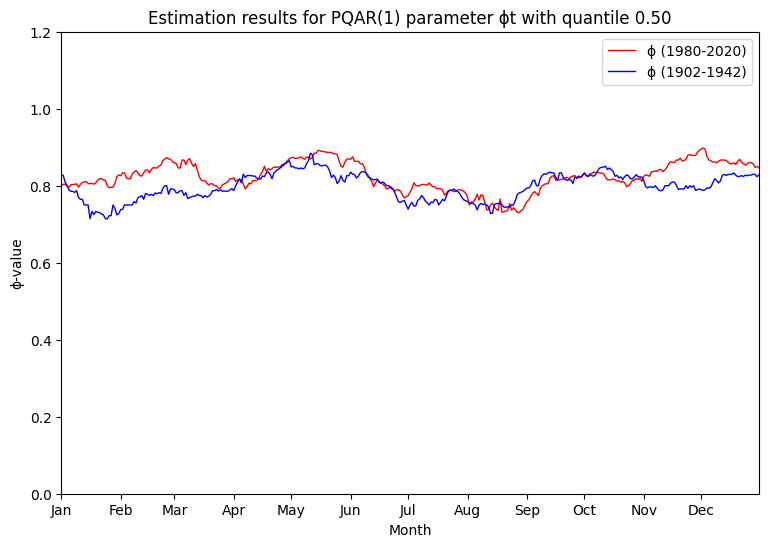

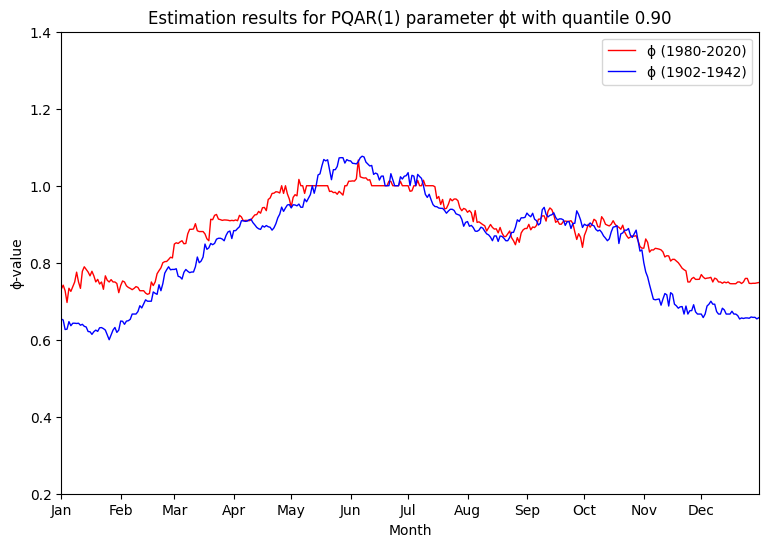

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Lissabon_1980_2020_low, [1980, 1902], [2020, 1942], 'Phi', 'Lissabon', 'PQAR(1)', q='0.10', df2=PQAR_df_Lissabon_1902_1942_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Lissabon_1980_2020_mean, [1980, 1902], [2020, 1942], 'Phi', 'Lissabon', 'PQAR(1)', q='0.50', df2=PQAR_df_Lissabon_1902_1942_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Lissabon_1980_2020_high, [1980, 1902], [2020, 1942], 'Phi', 'Lissabon', 'PQAR(1)', q='0.90', df2=PQAR_df_Lissabon_1902_1942_high)

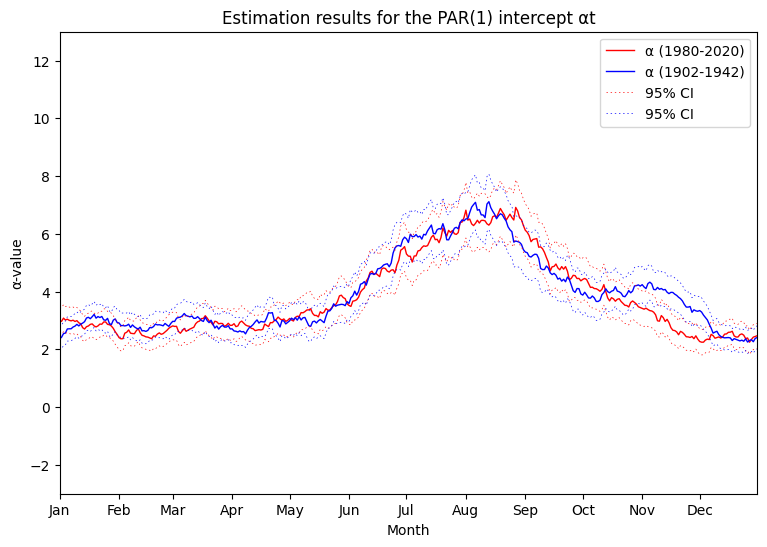

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Lissabon_1980_2020, [1980, 1902], [2020, 1942], 'Alpha', 'Lissabon', 'PAR(1)', df2=PAR_df_Lissabon_1902_1942)

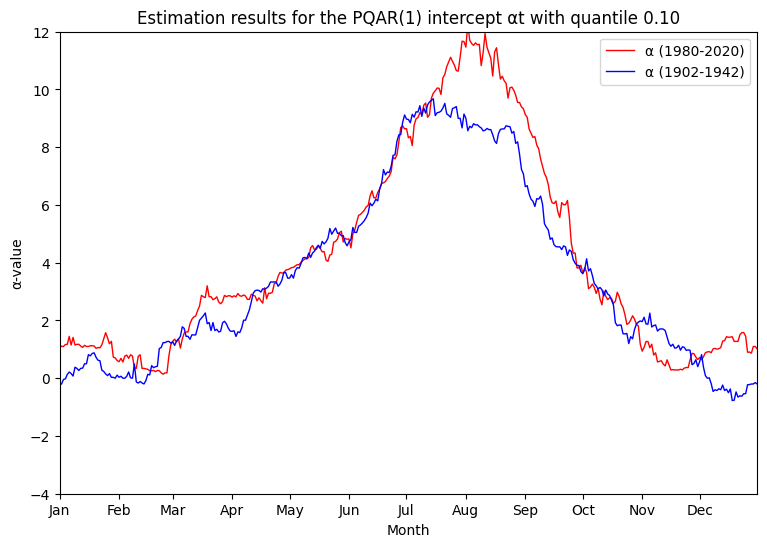

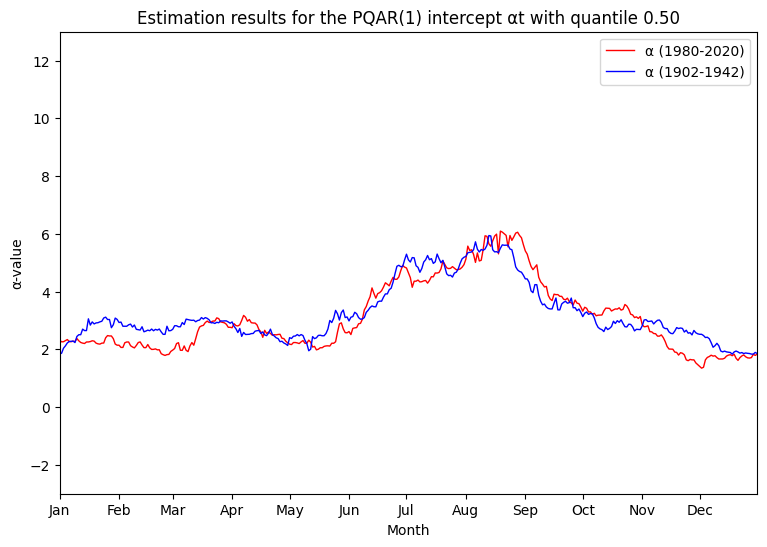

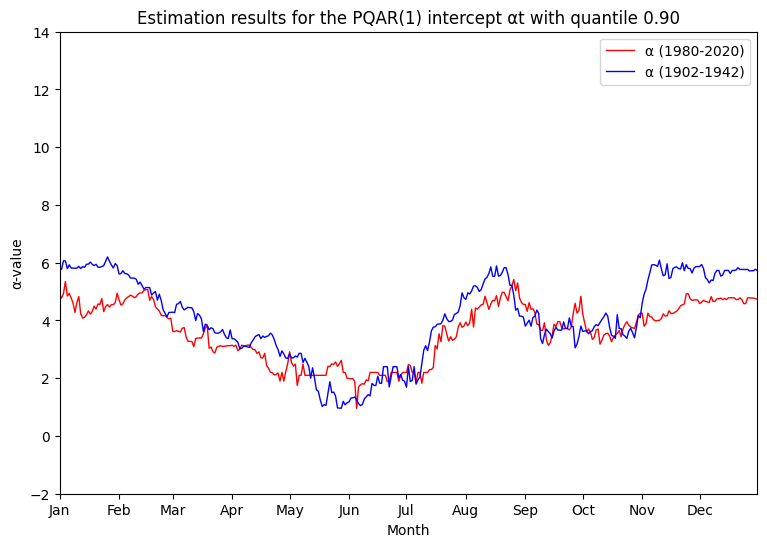

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Lissabon_1980_2020_low, [1980, 1902], [2020, 1942], 'Alpha', 'Lissabon', 'PQAR(1)', q='0.10', df2=PQAR_df_Lissabon_1902_1942_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Lissabon_1980_2020_mean, [1980, 1902], [2020, 1942], 'Alpha', 'Lissabon', 'PQAR(1)', q='0.50', df2=PQAR_df_Lissabon_1902_1942_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Lissabon_1980_2020_high, [1980, 1902], [2020, 1942], 'Alpha', 'Lissabon', 'PQAR(1)', q='0.90', df2=PQAR_df_Lissabon_1902_1942_high)

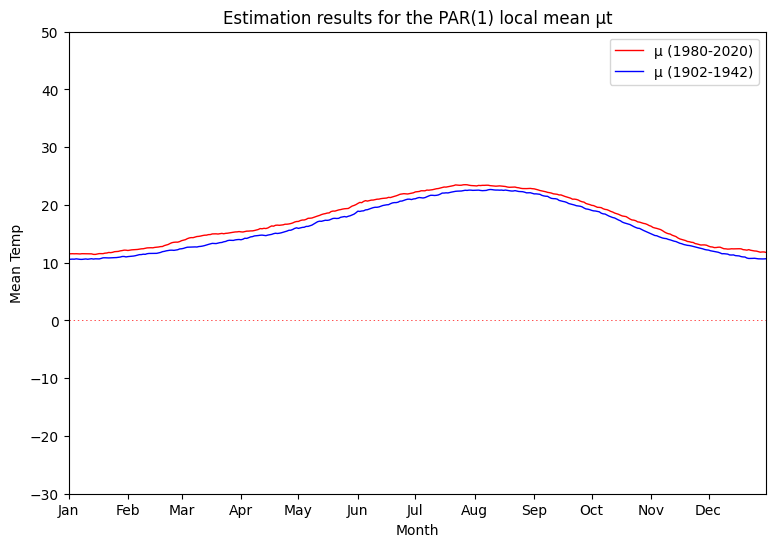

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Lissabon_1980_2020, [1980, 1902], [2020, 1942], 'Mu', 'Lissabon', 'PAR(1)', df2=PAR_df_Lissabon_1902_1942)

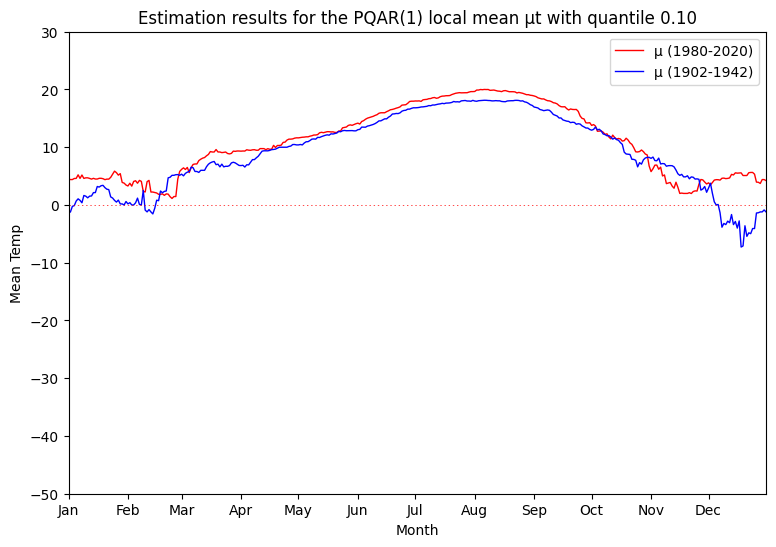

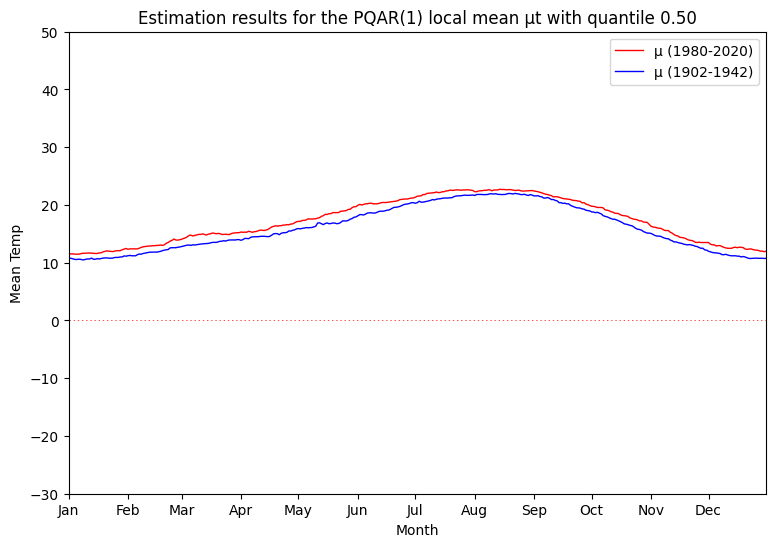

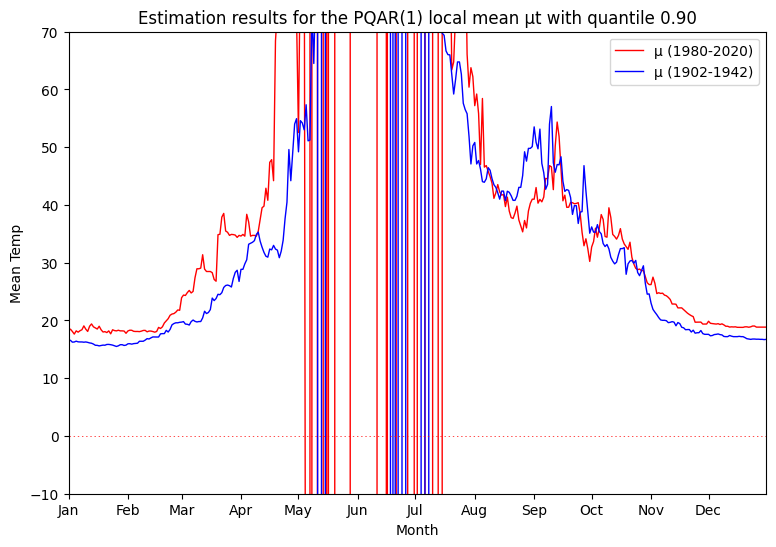

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Lissabon_1980_2020_low, [1980, 1902], [2020, 1942], 'Mu', 'Lissabon', 'PQAR(1)', q='0.10', df2=PQAR_df_Lissabon_1902_1942_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Lissabon_1980_2020_mean, [1980, 1902], [2020, 1942], 'Mu', 'Lissabon', 'PQAR(1)', q='0.50', df2=PQAR_df_Lissabon_1902_1942_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Lissabon_1980_2020_high, [1980, 1902], [2020, 1942], 'Mu', 'Lissabon', 'PQAR(1)', q='0.90', df2=PQAR_df_Lissabon_1902_1942_high)

### Zagreb

In [ ]:
# # Calculate the PAR parameters for two different time periods
# PAR_df_Zagreb_1980_2020 = estimate_PAR_params(df_Zagreb, 1980, 2020)
# PAR_df_Zagreb_1900_1940 = estimate_PAR_params(df_Zagreb, 1900, 1940)

# # Calculate the PQAR parameters with quantile 0.1 for two different time periods
# PQAR_df_Zagreb_1980_2020_low = estimate_PQAR_params(df_Zagreb, 1980, 2020, 0.10)
# PQAR_df_Zagreb_1900_1940_low = estimate_PQAR_params(df_Zagreb, 1900, 1940, 0.10)

# # Calculate the PQAR parameters with quantile 0.5 for two different time periods
# PQAR_df_Zagreb_1980_2020_mean = estimate_PQAR_params(df_Zagreb, 1980, 2020, 0.50)
# PQAR_df_Zagreb_1900_1940_mean = estimate_PQAR_params(df_Zagreb, 1900, 1940, 0.50)

# # Calculate the PQAR parameters with quantile 0.9 for two different time periods
# PQAR_df_Zagreb_1980_2020_high = estimate_PQAR_params(df_Zagreb, 1980, 2020, 0.90)
# PQAR_df_Zagreb_1900_1940_high = estimate_PQAR_params(df_Zagreb, 1900, 1940, 0.90)

In [ ]:
# # Save df as feathers
# PAR_df_Zagreb_1980_2020.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Zagreb_1980_2020.feather")
# PAR_df_Zagreb_1900_1940.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Zagreb_1900_1940.feather")

# PQAR_df_Zagreb_1980_2020_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1980_2020_low.feather")
# PQAR_df_Zagreb_1900_1940_low.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1900_1940_low.feather")

# PQAR_df_Zagreb_1980_2020_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1980_2020_mean.feather")
# PQAR_df_Zagreb_1900_1940_mean.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1900_1940_mean.feather")

# PQAR_df_Zagreb_1980_2020_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1980_2020_high.feather")
# PQAR_df_Zagreb_1900_1940_high.to_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1900_1940_high.feather")

In [ ]:
# Read df
PAR_df_Zagreb_1980_2020 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Zagreb_1980_2020.feather")
PAR_df_Zagreb_1900_1940 = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PAR_df_Zagreb_1900_1940.feather")

PQAR_df_Zagreb_1980_2020_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1980_2020_low.feather")
PQAR_df_Zagreb_1900_1940_low = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1900_1940_low.feather")

PQAR_df_Zagreb_1980_2020_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1980_2020_mean.feather")
PQAR_df_Zagreb_1900_1940_mean = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1900_1940_mean.feather")

PQAR_df_Zagreb_1980_2020_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1980_2020_high.feather")
PQAR_df_Zagreb_1900_1940_high = pd.read_feather("/content/drive/MyDrive/CaseStudy/DataFrames/PQAR_df_Zagreb_1900_1940_high.feather")

In [ ]:
# Compute difference in Phi for January 15 for different models
Delta_Phi_PAR_Zagreb_jan = PAR_df_Zagreb_1980_2020['Phi'].loc[14]-PAR_df_Zagreb_1900_1940['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Zagreb for PAR(1): {Delta_Phi_PAR_Zagreb_jan}')

Delta_Phi_PQAR_Zagreb_jan_low = PQAR_df_Zagreb_1980_2020_low['Phi'].loc[14]-PQAR_df_Zagreb_1900_1940_low['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Zagreb for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Zagreb_jan_low}')

Delta_Phi_PQAR_Zagreb_jan_mean = PQAR_df_Zagreb_1980_2020_mean['Phi'].loc[14]-PQAR_df_Zagreb_1900_1940_mean['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Zagreb for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Zagreb_jan_mean}')

Delta_Phi_PQAR_Zagreb_jan_high = PQAR_df_Zagreb_1980_2020_high['Phi'].loc[14]-PQAR_df_Zagreb_1900_1940_high['Phi'].loc[14]
print(f'Difference in Phi for January 15 in Zagreb for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Zagreb_jan_high}')

# Compute difference in Phi for July 15 for different models
Delta_Phi_PAR_Zagreb_jul = PAR_df_Zagreb_1980_2020['Phi'].loc[195]-PAR_df_Zagreb_1900_1940['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Zagreb for PAR(1): {Delta_Phi_PAR_Zagreb_jul}')

Delta_Phi_PQAR_Zagreb_jul_low = PQAR_df_Zagreb_1980_2020_low['Phi'].loc[195]-PQAR_df_Zagreb_1900_1940_low['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Zagreb for PQAR(1) with quantile 0.10: {Delta_Phi_PQAR_Zagreb_jul_low}')

Delta_Phi_PQAR_Zagreb_jul_mean = PQAR_df_Zagreb_1980_2020_mean['Phi'].loc[195]-PQAR_df_Zagreb_1900_1940_mean['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Zagreb for PQAR(1) with quantile 0.50: {Delta_Phi_PQAR_Zagreb_jul_mean}')

Delta_Phi_PQAR_Zagreb_jul_high = PQAR_df_Zagreb_1980_2020_high['Phi'].loc[195]-PQAR_df_Zagreb_1900_1940_high['Phi'].loc[195]
print(f'Difference in Phi for July 15 in Zagreb for PQAR(1) with quantile 0.90: {Delta_Phi_PQAR_Zagreb_jul_high}')

Difference in Phi for January 15 in Zagreb for PAR(1): 0.0036234716109262433
Difference in Phi for January 15 in Zagreb for PQAR(1) with quantile 0.10: -0.020633382509345655
Difference in Phi for January 15 in Zagreb for PQAR(1) with quantile 0.50: -0.00033838401734176404
Difference in Phi for January 15 in Zagreb for PQAR(1) with quantile 0.90: 0.0773770439051723
Difference in Phi for July 15 in Zagreb for PAR(1): 0.02194060409997267
Difference in Phi for July 15 in Zagreb for PQAR(1) with quantile 0.10: -0.09418990537108518
Difference in Phi for July 15 in Zagreb for PQAR(1) with quantile 0.50: 0.03941041436898429
Difference in Phi for July 15 in Zagreb for PQAR(1) with quantile 0.90: 0.018853447559807446


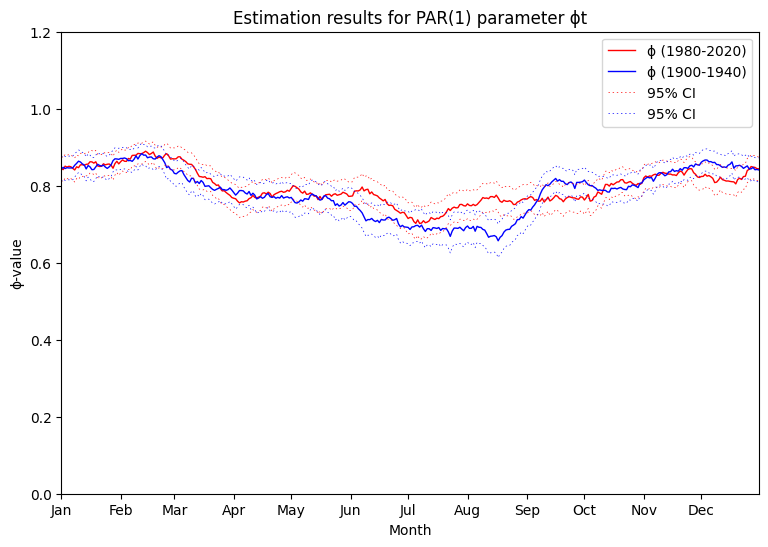

In [ ]:
# Plot the Phi parameter of the PAR model
plot(PAR_df_Zagreb_1980_2020, [1980, 1900], [2020, 1940], 'Phi', 'Zagreb', 'PAR(1)', df2=PAR_df_Zagreb_1900_1940)

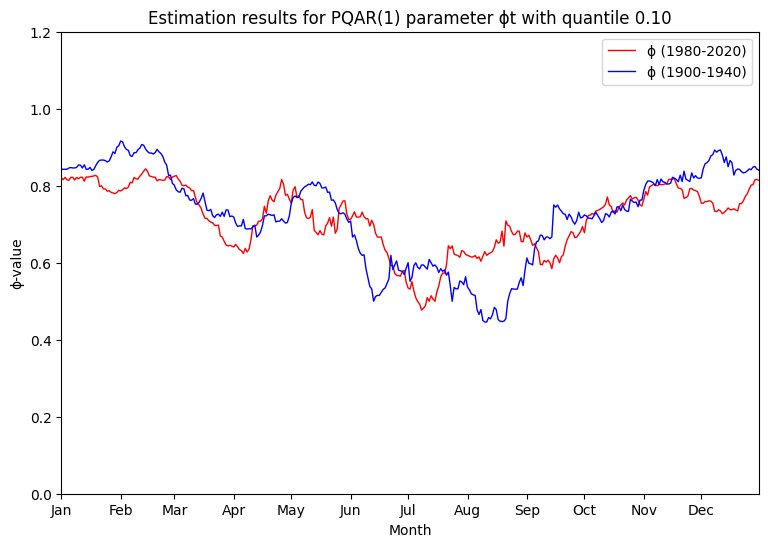

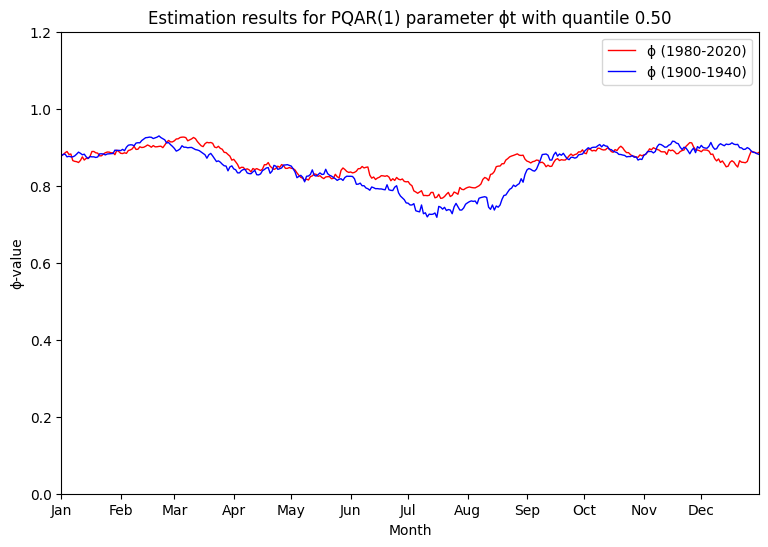

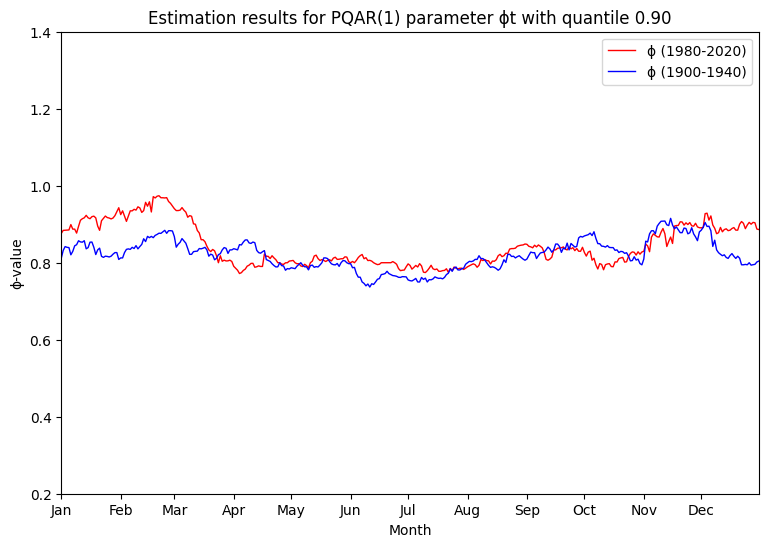

In [ ]:
# Plot the Phi parameter of the PQAR model with quantile 0.1
plot(PQAR_df_Zagreb_1980_2020_low, [1980, 1900], [2020, 1940], 'Phi', 'Zagreb', 'PQAR(1)', q='0.10', df2=PQAR_df_Zagreb_1900_1940_low)
# Plot the Phi parameter of the PQAR model with quantile 0.5
plot(PQAR_df_Zagreb_1980_2020_mean, [1980, 1900], [2020, 1940], 'Phi', 'Zagreb', 'PQAR(1)', q='0.50', df2=PQAR_df_Zagreb_1900_1940_mean)
# Plot the Phi parameter of the PQAR model with quantile 0.9
plot(PQAR_df_Zagreb_1980_2020_high, [1980, 1900], [2020, 1940], 'Phi', 'Zagreb', 'PQAR(1)', q='0.90', df2=PQAR_df_Zagreb_1900_1940_high)


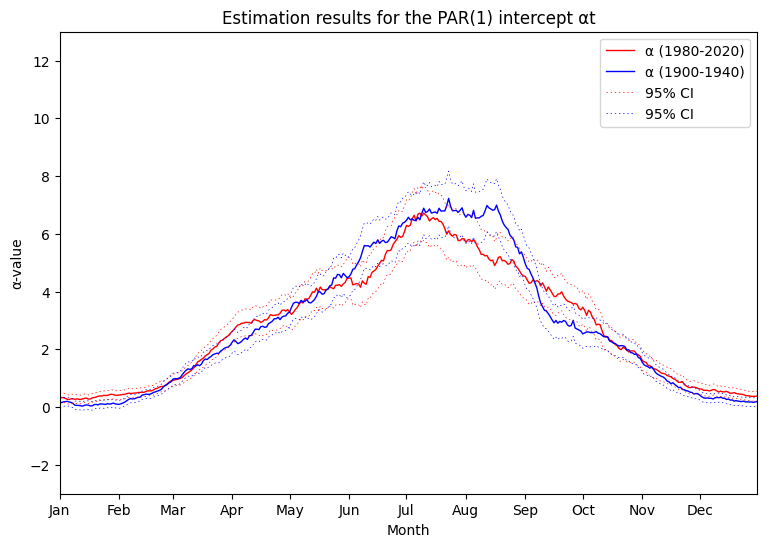

In [ ]:
# Plot the intercept Alpha of the PAR model
plot(PAR_df_Zagreb_1980_2020, [1980, 1900], [2020, 1940], 'Alpha', 'Zagreb', 'PAR(1)', df2=PAR_df_Zagreb_1900_1940)

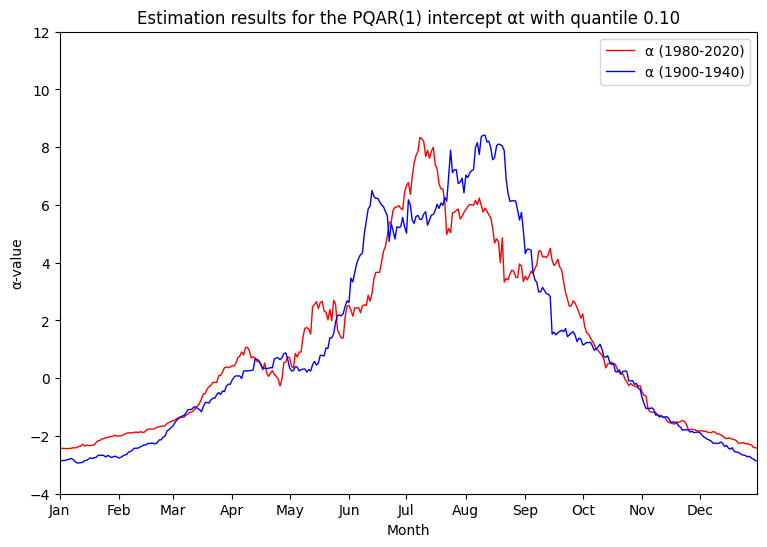

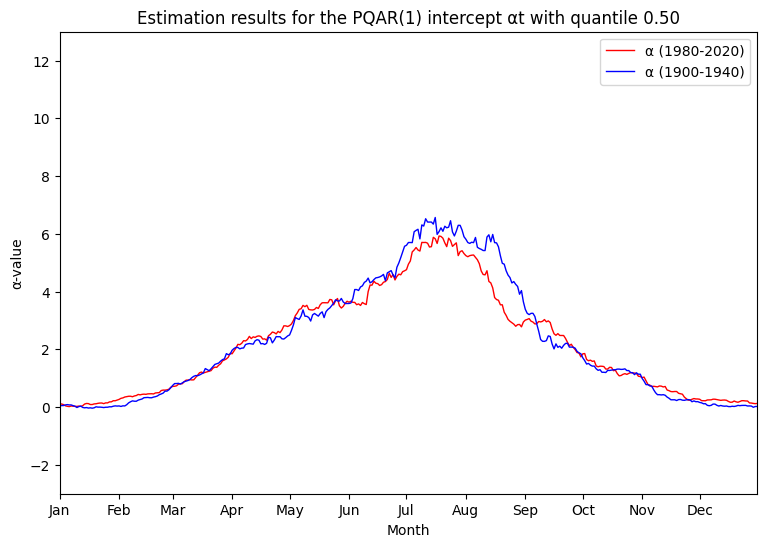

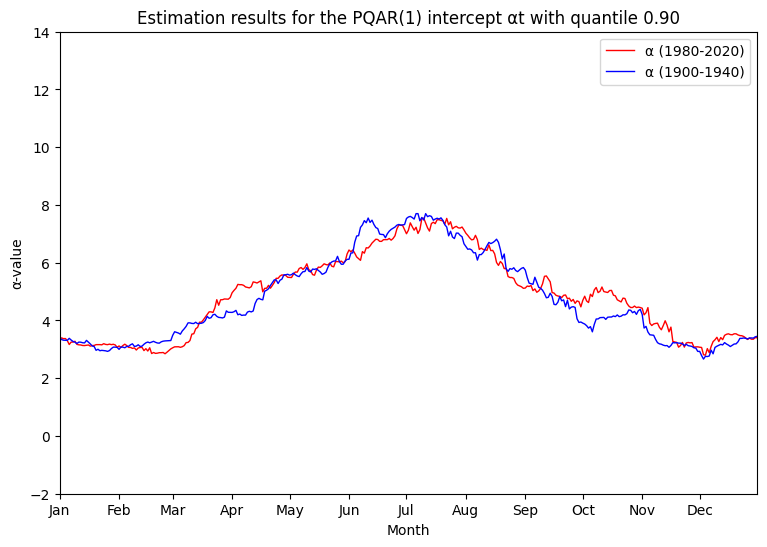

In [ ]:
# Plot the intercept Alpha of the PQAR model with quantile 0.1
plot(PQAR_df_Zagreb_1980_2020_low, [1980, 1900], [2020, 1940], 'Alpha', 'Zagreb', 'PQAR(1)', q='0.10', df2=PQAR_df_Zagreb_1900_1940_low)
# Plot the intercept Alpha of the PQAR model with quantile 0.5
plot(PQAR_df_Zagreb_1980_2020_mean, [1980, 1900], [2020, 1940], 'Alpha', 'Zagreb', 'PQAR(1)', q='0.50', df2=PQAR_df_Zagreb_1900_1940_mean)
# Plot the intercept Alpha of the PQAR model with quantile 0.9
plot(PQAR_df_Zagreb_1980_2020_high, [1980, 1900], [2020, 1940], 'Alpha', 'Zagreb', 'PQAR(1)', q='0.90', df2=PQAR_df_Zagreb_1900_1940_high)

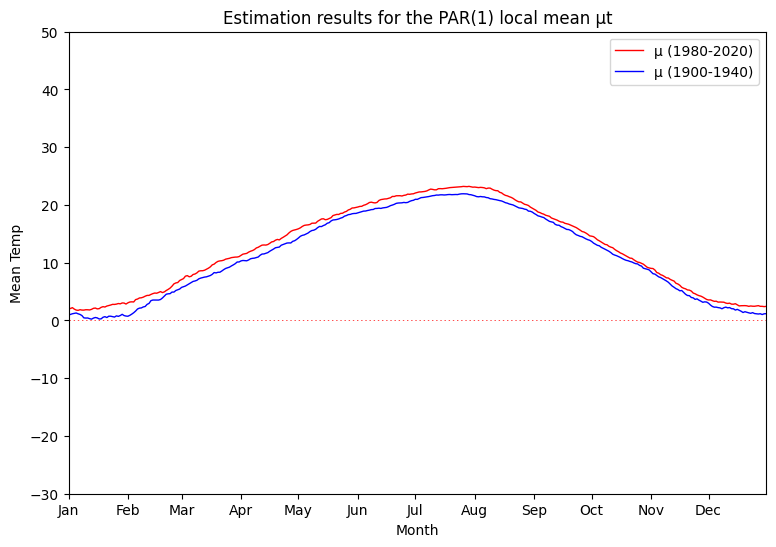

In [ ]:
# Plot the local mean Mu of the PAR model
plot(PAR_df_Zagreb_1980_2020, [1980, 1900], [2020, 1940], 'Mu', 'Zagreb', 'PAR(1)', df2=PAR_df_Zagreb_1900_1940)

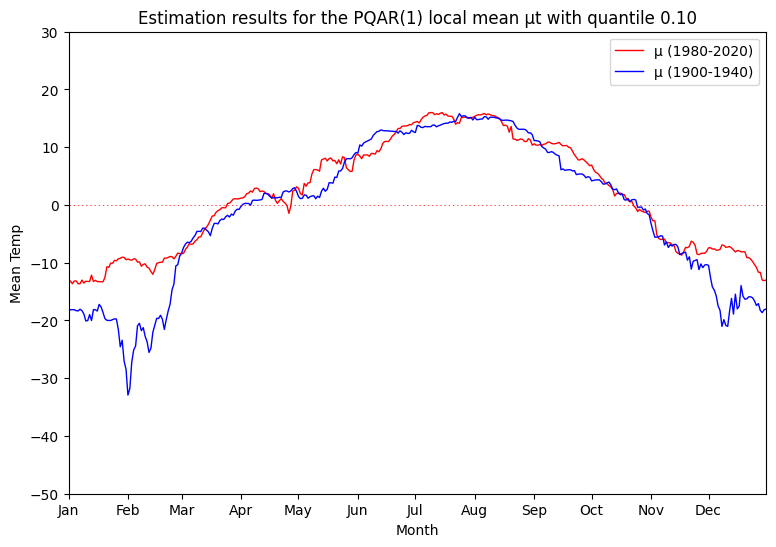

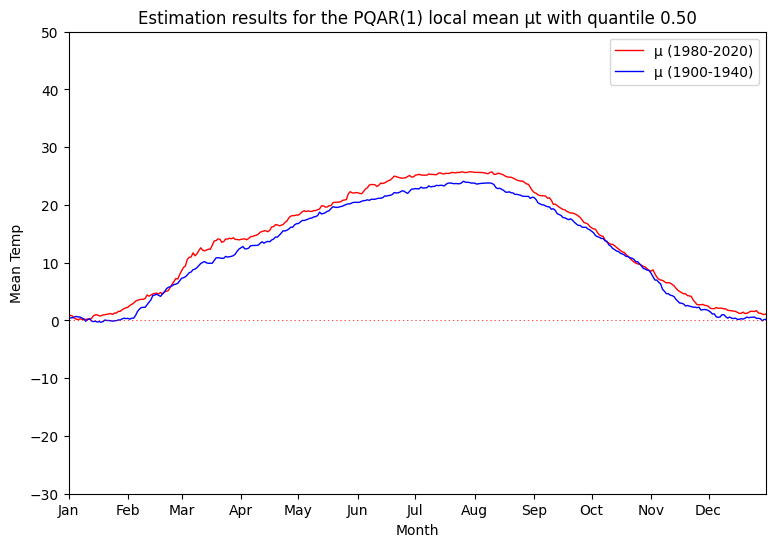

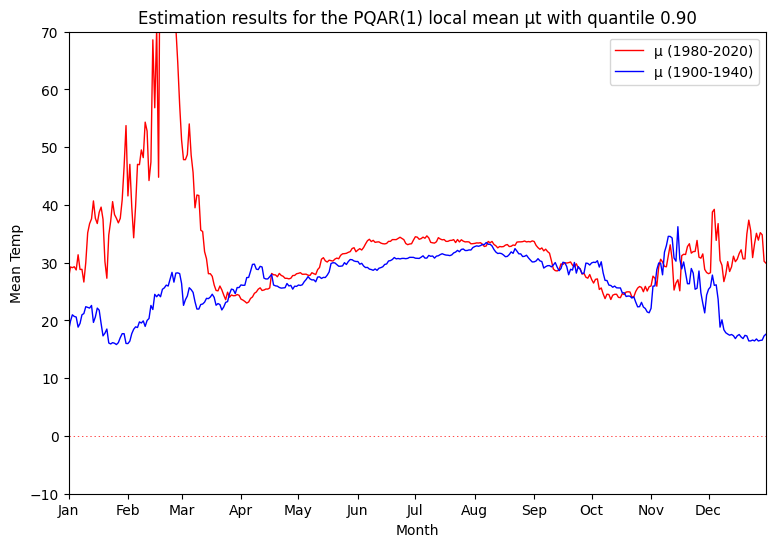

In [ ]:
# Plot the the local mean Mu of the PQAR model with quantile 0.1
plot(PQAR_df_Zagreb_1980_2020_low, [1980, 1900], [2020, 1940], 'Mu', 'Zagreb', 'PQAR(1)', q='0.10', df2=PQAR_df_Zagreb_1900_1940_low)
# Plot the the local mean Mu of the PQAR model with quantile 0.5
plot(PQAR_df_Zagreb_1980_2020_mean, [1980, 1900], [2020, 1940], 'Mu', 'Zagreb', 'PQAR(1)', q='0.50', df2=PQAR_df_Zagreb_1900_1940_mean)
# Plot the the local mean Mu of the PQAR model with quantile 0.9
plot(PQAR_df_Zagreb_1980_2020_high, [1980, 1900], [2020, 1940], 'Mu', 'Zagreb', 'PQAR(1)', q='0.90', df2=PQAR_df_Zagreb_1900_1940_high)